<a href="https://colab.research.google.com/github/praeprae/praeprae/blob/KaggleCompetition/%5BPrivate_Score_0_77%5D_EDA_%F0%9F%8E%AF_Ensemble_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Kidney Stone Prediction

## Download Data and Tools

In [238]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [239]:
!pip install -q kaggle
!mkdir ~/.kaggle
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle
!chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [240]:
!kaggle competitions download -c playground-series-s3e12

playground-series-s3e12.zip: Skipping, found more recently modified local copy (use --force to force download)


In [241]:
!mkdir /content/playground
!unzip /content/playground-series-s3e12.zip -d /content/playground

mkdir: cannot create directory ‘/content/playground’: File exists
Archive:  /content/playground-series-s3e12.zip
replace /content/playground/sample_submission.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [242]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-6ffdd766-f7cc-4104-bd93-a8ecf536d084)


In [327]:
import pandas as pd
import numpy as np
import os
from matplotlib import pyplot as plt
import seaborn as sns

In [401]:
train_ori = pd.read_csv('/content/kindey_stone_urine_analysis.csv')
train_data = pd.read_csv('/content/playground/train.csv')
train_data = train_data.drop('id', axis = 1)
train_data = pd.concat((train_data, train_ori), axis = 0)
print(train_ori)
print(train_data)

    gravity    ph  osmo  cond  urea   calc  target
0     1.021  4.91   725  14.0   443   2.45       0
1     1.017  5.74   577  20.0   296   4.49       0
2     1.008  7.20   321  14.9   101   2.36       0
3     1.011  5.51   408  12.6   224   2.15       0
4     1.005  6.52   187   7.5    91   1.16       0
..      ...   ...   ...   ...   ...    ...     ...
74    1.025  7.90   721  23.6   301   9.04       1
75    1.017  4.81   410  13.3   195   0.58       1
76    1.024  5.40   803  21.8   394   7.82       1
77    1.016  6.81   594  21.4   255  12.20       1
78    1.015  6.03   416  12.8   178   9.39       1

[79 rows x 7 columns]
    gravity    ph  osmo  cond  urea   calc  target
0     1.013  6.19   443  14.8   124   1.45       0
1     1.025  5.40   703  23.6   394   4.18       0
2     1.009  6.13   371  24.5   159   9.04       0
3     1.021  4.91   442  20.8   398   6.63       1
4     1.021  5.53   874  17.8   385   2.21       1
..      ...   ...   ...   ...   ...    ...     ...
74    1.

In [402]:
test_data = pd.read_csv('/content/playground/test.csv')
test_data = test_data.drop('id', axis = 1)
print(test_data)

     gravity    ph  osmo  cond  urea   calc
0      1.017  5.24   345  11.5   152   1.16
1      1.020  5.68   874  29.0   385   3.46
2      1.024  5.36   698  19.5   354  13.00
3      1.020  5.33   668  25.3   252   3.46
4      1.011  5.87   567  29.0   457   2.36
..       ...   ...   ...   ...   ...    ...
271    1.029  6.27   853  21.4   364   7.31
272    1.012  5.62   410  14.0   195   1.45
273    1.031  5.68   874  29.0   380   4.49
274    1.019  5.47   543  21.4   170   1.64
275    1.017  6.19   698  29.0   252   3.53

[276 rows x 6 columns]


In [403]:
features = train_data.columns.to_list()
print(features)

['gravity', 'ph', 'osmo', 'cond', 'urea', 'calc', 'target']


## EDA

### Correlation Heatmap

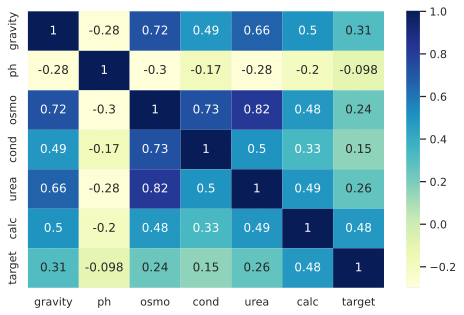

In [291]:
 # plotting correlation heatmap
dataplot = sns.heatmap(train_data[features].corr(), cmap="YlGnBu", annot=True)
  
# displaying heatmap
plt.show()

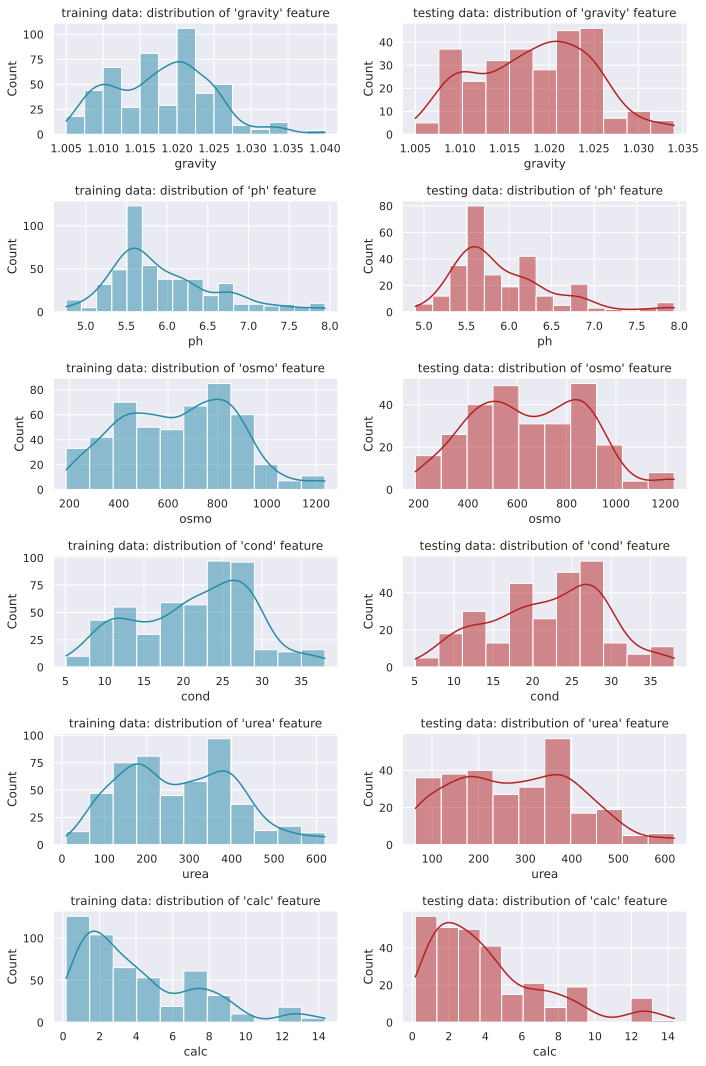

In [292]:
plt.figure(figsize=(10,15))
i = 1
for col in train_data.columns[0:6]:
    plt.subplot(6,2,i)
    sns.histplot(x=train_data[col],color='#288BA8',kde=True,lw=1)
    plt.title("training data: distribution of '{}' feature".format(col));
   
    plt.subplot(6,2,i+1)
    sns.histplot(x=test_data[col],color='#B22222',kde=True,lw=1)
    plt.title("testing data: distribution of '{}' feature".format(col));
    i+=2
plt.tight_layout()

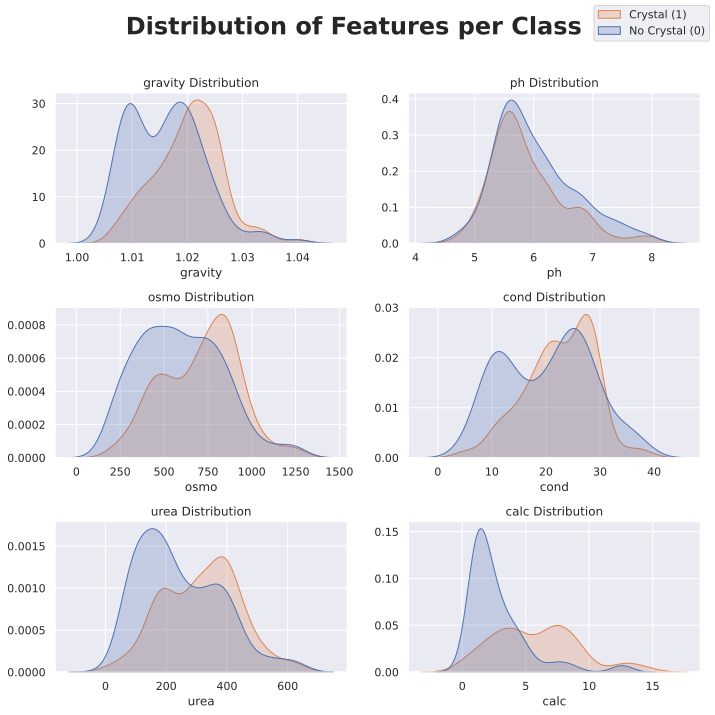

In [293]:
fig, ax = plt.subplots(3, 2, figsize = (10, 10), dpi = 300)
ax = ax.flatten()

for i, column in enumerate(train_data.columns[0:6]):
    sns.kdeplot(data = train_data, x = column, ax=ax[i], fill = True, legend = False, hue = 'target')
    
    ax[i].set_title(f'{column} Distribution')
    ax[i].set_xlabel(column)
    ax[i].set_ylabel(None)
    
fig.suptitle('Distribution of Features per Class\n', fontsize = 24, fontweight = 'bold')
fig.legend(['Crystal (1)', 'No Crystal (0)'])
plt.tight_layout()


In [294]:
print(train_data.describe())
print(test_data.describe())

          gravity          ph         osmo        cond        urea  \
count  493.000000  493.000000   493.000000  493.000000  493.000000   
mean     1.017929    5.967160   645.344828   21.337931  276.693712   
std      0.006761    0.655861   235.320087    7.579484  135.568157   
min      1.005000    4.760000   187.000000    5.100000   10.000000   
25%      1.012000    5.530000   450.000000   15.500000  164.000000   
50%      1.018000    5.770000   668.000000   21.900000  272.000000   
75%      1.022000    6.280000   838.000000   27.600000  385.000000   
max      1.040000    7.940000  1236.000000   38.000000  620.000000   

             calc      target  
count  493.000000  493.000000  
mean     4.118540    0.442191  
std      3.221149    0.497151  
min      0.170000    0.000000  
25%      1.450000    0.000000  
50%      3.160000    0.000000  
75%      6.630000    1.000000  
max     14.340000    1.000000  
          gravity          ph         osmo        cond        urea        calc
co

In [295]:
print(train_data.isna().sum())
print(test_data.isna().sum())

gravity    0
ph         0
osmo       0
cond       0
urea       0
calc       0
target     0
dtype: int64
gravity    0
ph         0
osmo       0
cond       0
urea       0
calc       0
dtype: int64


### Remove Outlier from train_data.urea

In [404]:
print(train_data.loc[train_data.urea < 64])

     gravity    ph  osmo  cond  urea  calc  target
68     1.020  4.76   312   8.8    10  0.27       0
114    1.007  6.88   242  10.9    14  0.65       1
70     1.028  4.76   312  12.4    10  0.27       1


In [405]:
train_data = train_data[train_data['urea'] >= 64]

In [406]:
train_label = train_data['target']
print(train_label)

0     0
1     0
2     0
3     1
4     1
     ..
74    1
75    1
76    1
77    1
78    1
Name: target, Length: 490, dtype: int64


## Data Engineering

In [407]:
from sklearn.preprocessing import StandardScaler, LabelEncoder
standardScaler = StandardScaler()

def FeatureEngineer(dataF):

  dataF['gravity'] = (dataF['gravity'] - 1) * 100
  dataF = standardScaler.fit_transform(dataF[features[:-1]])
  dataF = pd.DataFrame(dataF, columns=features[:-1])
  dataF['osmo_sum'] = dataF['osmo'] + dataF['gravity'] + dataF['urea']
  dataF['calc_cond'] = dataF['calc'] + dataF['cond']
  dataF['calc_osmo'] = dataF['calc'] + dataF['osmo']
  dataF = dataF.drop(['osmo', 'urea'], axis=1)

  return dataF

In [408]:
train_data = FeatureEngineer(train_data)
test_data = FeatureEngineer(test_data)

In [409]:
def Drop_ph(dataF):

  dataF = dataF.drop(['ph'], axis=1)

  return dataF

In [410]:
train_data = Drop_ph(train_data)
test_data = Drop_ph(test_data)

In [411]:
print(train_data)
print(test_data)

      gravity      cond      calc  osmo_sum  calc_cond  calc_osmo
0   -0.730811 -0.874807 -0.837261 -2.754008  -1.712068  -1.710875
1    1.049292  0.291062  0.012031  2.147992   0.303093   0.248969
2   -1.324178  0.410298  1.523959 -3.394183   1.934257   0.342808
3    0.455924 -0.079897  0.774217  0.469600   0.694320  -0.103668
4    0.455924 -0.477352 -0.600828  2.217980  -1.078180   0.366511
..        ...       ...       ...       ...        ...        ...
485  1.049292  0.291062  1.523959  1.532079   1.815020   1.837781
486 -0.137443 -1.073535 -1.107915 -1.772685  -2.181450  -2.122483
487  0.900950  0.052588  1.144421  2.426785   1.197010   1.808494
488 -0.285785 -0.000406  2.507022 -0.688133   2.506617   2.278383
489 -0.434127 -1.139777  1.632842 -2.170381   0.493065   0.643903

[490 rows x 6 columns]
      gravity      cond      calc  osmo_sum  calc_cond  calc_osmo
0   -0.202805 -1.416467 -0.946130 -2.474325  -2.362597  -2.259600
1    0.254749  0.970087 -0.200085  1.956014   0.7700

In [412]:
edited_features = train_data.columns.to_list()
# edited_features.remove('target')
print(edited_features)

['gravity', 'cond', 'calc', 'osmo_sum', 'calc_cond', 'calc_osmo']


In [413]:
train_data.reset_index(drop=True, inplace=True)
train_label.reset_index(drop=True, inplace=True)
train_data = pd.concat([train_data, train_label], axis=1)
train_data

,gravity,cond,calc,osmo_sum,calc_cond,calc_osmo,target
0,-0.730811,-0.874807,-0.837261,-2.754008,-1.712068,-1.710875,0
1,1.049292,0.291062,0.012031,2.147992,0.303093,0.248969,0
2,-1.324178,0.410298,1.523959,-3.394183,1.934257,0.342808,0
3,0.455924,-0.079897,0.774217,0.469600,0.694320,-0.103668,1
4,0.455924,-0.477352,-0.600828,2.217980,-1.078180,0.366511,1
...,...,...,...,...,...,...,...
485,1.049292,0.291062,1.523959,1.532079,1.815020,1.837781,1
486,-0.137443,-1.073535,-1.107915,-1.772685,-2.181450,-2.122483,1
487,0.900950,0.052588,1.144421,2.426785,1.197010,1.808494,1
488,-0.285785,-0.000406,2.507022,-0.688133,2.506617,2.278383,1


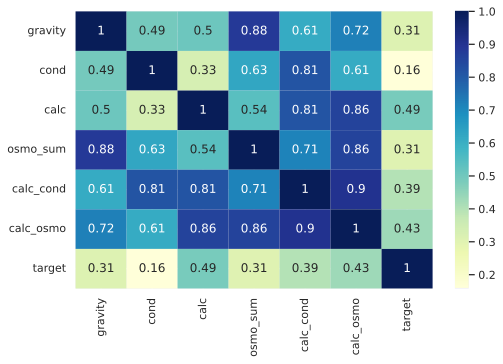

In [414]:
 # plotting correlation heatmap
dataplot = sns.heatmap(train_data.corr(), cmap="YlGnBu", annot=True)
  
# displaying heatmap
plt.show()

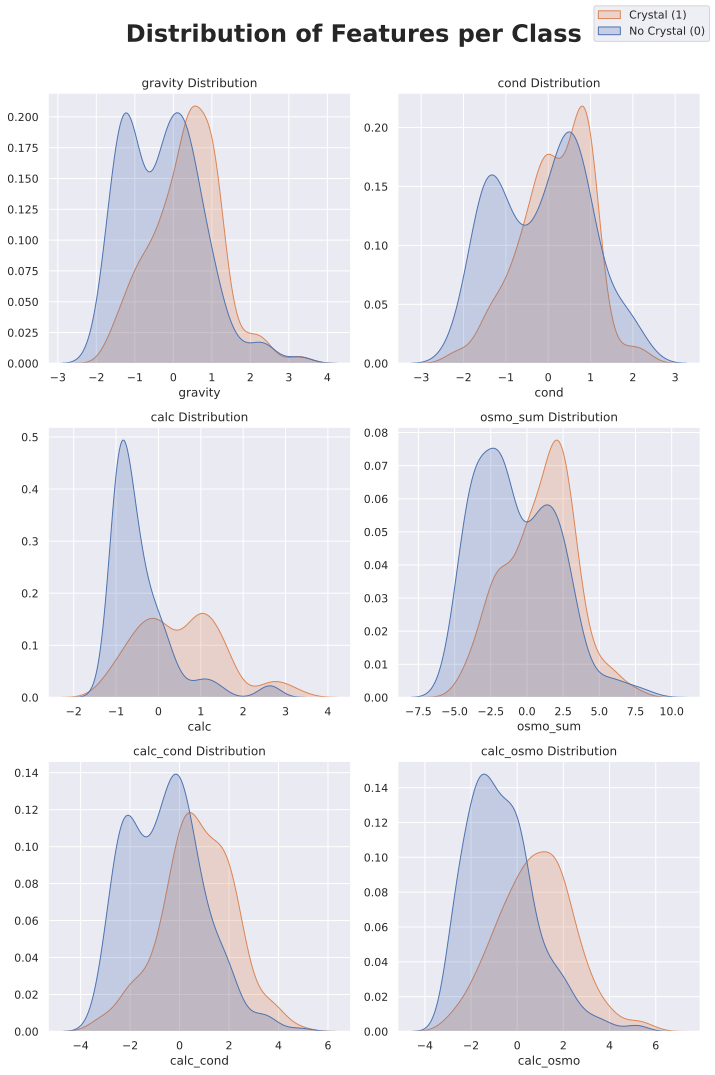

In [415]:
fig, ax = plt.subplots(3, 2, figsize = (10, 15), dpi = 300)
ax = ax.flatten()

for i, column in enumerate(edited_features):
    sns.kdeplot(data = train_data, x = column, ax=ax[i], fill = True, legend = False, hue = 'target')
    
    ax[i].set_title(f'{column} Distribution')
    ax[i].set_xlabel(column)
    ax[i].set_ylabel(None)
    
fig.suptitle('Distribution of Features per Class\n', fontsize = 24, fontweight = 'bold')
fig.legend(['Crystal (1)', 'No Crystal (0)'])
plt.tight_layout()

In [416]:
train_data.to_csv('FE_train.csv', index=False)
test_data.to_csv('FE_test.csv', index=False)

## Model CatBoost, XGBoost, LightGBM

### Install Tools

In [384]:
!pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [385]:
!pip install catboost
!pip install lightgbm
!pip install xgboost
!pip install scikit-learn
!pip install ipywidgets
!jupyter nbextension enable --py widgetsnbextension

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Enabling notebook extension jupyter-js-widgets/extension...
Paths used for configuration of notebook: 
    	/root/.jupyter/nbconfig/notebook.json
Paths used for configuration of notebook: 
    	
      - Validating: OK
Paths used for configuration of notebook: 
    	/root/.jupyter/nbconfig/notebook.json


In [387]:
import optuna
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt
# import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.metrics import roc_auc_score, RocCurveDisplay
from sklearn.model_selection import StratifiedKFold
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

sns.set()

%config InlineBackend.figure_format = 'svg'

plt.rcParams["figure.figsize"] = (8, 5)
plt.rcParams["image.cmap"] = "viridis"

### Train Model

In [417]:
X = train_data.drop(columns='target').reset_index(drop=True)
y = train_data['target'].reset_index(drop=True)
test = test_data

In [418]:
features = X.columns
rs = RobustScaler()
X[features] = rs.fit_transform(X[features])
test[features] = rs.transform(test[features])

In [419]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=22)

In [420]:
# CatBoost Classifier
def objective_cbc(trial):
    params = {'iterations' : trial.suggest_int('iterations',50,300), 
              'learning_rate' : trial.suggest_float('learning_rate', 0.01, 1), 
              'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 0.01, 3),
              'depth' : trial.suggest_int('depth', 1, 7),
              'subsample': trial.suggest_float('subsample', 0.5,0.8),
              'bagging_temperature': trial.suggest_float("bagging_temperature", 0.0, 10.0),
              'od_type': trial.suggest_categorical("od_type", ["IncToDec", "Iter"]),
              'od_wait': trial.suggest_int("od_wait", 10, 50),}
    
    preds = []
    
    for i, (train_idx, test_idx) in enumerate(cv.split(X, y)):
        X_train, y_train = X.loc[train_idx], y[train_idx]
        X_test, y_test = X.loc[test_idx], y[test_idx]
        
        model = CatBoostClassifier(**params,
                                   verbose=False,
                                   eval_metric='AUC')
        model.fit(X_train, y_train, eval_set=(X_test, y_test))
        model_pred = model.predict_proba(X_test)
        
        preds.append(roc_auc_score(y_test, model_pred[:, 1]))
    
    return np.mean(preds)

In [421]:
study_cbc = optuna.create_study(study_name="cbc", direction="maximize")
study_cbc.optimize(objective_cbc, n_trials=200, n_jobs=-1)

[I 2023-04-19 04:41:41,793] A new study created in memory with name: cbc
[I 2023-04-19 04:41:42,890] Trial 1 finished with value: 0.8159740819043144 and parameters: {'iterations': 204, 'learning_rate': 0.8795553253389007, 'l2_leaf_reg': 1.7565669035293248, 'depth': 5, 'subsample': 0.7286770187419092, 'bagging_temperature': 2.11645915171649, 'od_type': 'Iter', 'od_wait': 24}. Best is trial 1 with value: 0.8159740819043144.
[I 2023-04-19 04:41:43,905] Trial 0 finished with value: 0.8281730091613813 and parameters: {'iterations': 132, 'learning_rate': 0.7429171449884834, 'l2_leaf_reg': 2.7137717523680185, 'depth': 7, 'subsample': 0.7939884124186605, 'bagging_temperature': 0.9091310341570846, 'od_type': 'Iter', 'od_wait': 33}. Best is trial 0 with value: 0.8281730091613813.
[I 2023-04-19 04:41:44,638] Trial 2 finished with value: 0.8222760551248923 and parameters: {'iterations': 188, 'learning_rate': 0.875708402384281, 'l2_leaf_reg': 2.7457379563048296, 'depth': 3, 'subsample': 0.585239292

In [422]:
# XGBoost
def objective_xgb(trial):
    params = {'max_depth': trial.suggest_int('max_depth', 3, 12), 
              'subsample': trial.suggest_float('subsample', 0, 1), 
              'colsample_bytree': trial.suggest_float('colsample_bytree', 0, 1),
              'reg_alpha': trial.suggest_float('reg_alpha', 0, 1),
              'reg_lambda': trial.suggest_float('reg_lambda', 0, 1),
              'gamma': trial.suggest_float('gamma', 0, 1),
              'min_gain_to_split': trial.suggest_float('min_gain_to_split', 0, 15)}
    
    preds = []
    
    for i, (train_idx, test_idx) in enumerate(cv.split(X, y)):
        X_train, y_train = X.loc[train_idx], y[train_idx]
        X_test, y_test = X.loc[test_idx], y[test_idx]
        
        model = XGBClassifier(**params, eval_metric='auc', n_estimators=10000)
        model.fit(X_train, y_train, 
                  eval_set=[(X_test, y_test)], 
                  early_stopping_rounds=100, 
                  verbose=1000)
        model_pred = model.predict_proba(X_test)
        
        preds.append(roc_auc_score(y_test, model_pred[:, 1]))
    
    return np.mean(preds)

In [423]:
study_xgb = optuna.create_study(study_name="xgb", direction="maximize")
study_xgb.optimize(objective_xgb, n_trials=200, n_jobs=-1)

[I 2023-04-19 04:43:35,996] A new study created in memory with name: xgb


[0]	validation_0-auc:0.67780
[0]	validation_0-auc:0.74440
[102]	validation_0-auc:0.72812
[0]	validation_0-auc:0.70402
[120]	validation_0-auc:0.77040
[0]	validation_0-auc:0.74503
[213]	validation_0-auc:0.74841
[113]	validation_0-auc:0.79789
[0]	validation_0-auc:0.60803
[0]	validation_0-auc:0.76110
[107]	validation_0-auc:0.77378
[0]	validation_0-auc:0.69641
[105]	validation_0-auc:0.82896
[0]	validation_0-auc:0.77717
[136]	validation_0-auc:0.73383
[0]	validation_0-auc:0.63447
[106]	validation_0-auc:0.76004
[0]	validation_0-auc:0.76852
[106]	validation_0-auc:0.81355


[I 2023-04-19 04:43:37,188] Trial 0 finished with value: 0.8095409521572312 and parameters: {'max_depth': 12, 'subsample': 0.9557925805010925, 'colsample_bytree': 0.5334280753176303, 'reg_alpha': 0.4161324765332711, 'reg_lambda': 0.0725117822189929, 'gamma': 0.3618219819997015, 'min_gain_to_split': 14.335272386220238}. Best is trial 0 with value: 0.8095409521572312.


[0]	validation_0-auc:0.73129
[103]	validation_0-auc:0.74989
[0]	validation_0-auc:0.75433
[113]	validation_0-auc:0.77632
[0]	validation_0-auc:0.69789
[110]	validation_0-auc:0.76681
[0]	validation_0-auc:0.76258
[144]	validation_0-auc:0.82156
[0]	validation_0-auc:0.77104
[567]	validation_0-auc:0.74832


[I 2023-04-19 04:43:37,777] Trial 1 finished with value: 0.7632765640905176 and parameters: {'max_depth': 10, 'subsample': 0.8232593670485329, 'colsample_bytree': 0.2924899793430632, 'reg_alpha': 0.2227776076691188, 'reg_lambda': 0.49509452816401534, 'gamma': 0.1138661103179317, 'min_gain_to_split': 14.716350624638551}. Best is trial 0 with value: 0.8095409521572312.


[0]	validation_0-auc:0.75624
[118]	validation_0-auc:0.80345


[I 2023-04-19 04:43:37,854] Trial 2 finished with value: 0.8220756009709497 and parameters: {'max_depth': 10, 'subsample': 0.1432128457565477, 'colsample_bytree': 0.7060962865095695, 'reg_alpha': 0.8975393016999891, 'reg_lambda': 0.590833601714667, 'gamma': 0.666219413141748, 'min_gain_to_split': 0.9481858450530339}. Best is trial 2 with value: 0.8220756009709497.


[0]	validation_0-auc:0.73362
[103]	validation_0-auc:0.77928
[0]	validation_0-auc:0.76195
[103]	validation_0-auc:0.74419
[0]	validation_0-auc:0.79704
[131]	validation_0-auc:0.81903
[0]	validation_0-auc:0.73552
[109]	validation_0-auc:0.79239
[0]	validation_0-auc:0.76533
[108]	validation_0-auc:0.81205
[115]	validation_0-auc:0.81480
[0]	validation_0-auc:0.80930
[0]	validation_0-auc:0.76554
[106]	validation_0-auc:0.76934
[0]	validation_0-auc:0.79630
[108]	validation_0-auc:0.77611
[0]	validation_0-auc:0.78451
[108]	validation_0-auc:0.79672


[I 2023-04-19 04:43:38,737] Trial 3 finished with value: 0.8280941194894684 and parameters: {'max_depth': 4, 'subsample': 0.6845328951072117, 'colsample_bytree': 0.5363521712635451, 'reg_alpha': 0.559585032257034, 'reg_lambda': 0.6330917383793505, 'gamma': 0.04917854946923028, 'min_gain_to_split': 14.948659503223293}. Best is trial 3 with value: 0.8280941194894684.


[119]	validation_0-auc:0.82534
[0]	validation_0-auc:0.78013


[I 2023-04-19 04:43:38,766] Trial 4 finished with value: 0.8093152454780362 and parameters: {'max_depth': 6, 'subsample': 0.8229021150914584, 'colsample_bytree': 0.6873198246926485, 'reg_alpha': 0.11633433748125932, 'reg_lambda': 0.6824532953011038, 'gamma': 0.6186687634426798, 'min_gain_to_split': 3.8607985915599636}. Best is trial 3 with value: 0.8280941194894684.


[0]	validation_0-auc:0.70444
[101]	validation_0-auc:0.75560
[0]	validation_0-auc:0.76638
[107]	validation_0-auc:0.76406
[0]	validation_0-auc:0.77082
[132]	validation_0-auc:0.80381
[0]	validation_0-auc:0.69197
[106]	validation_0-auc:0.78605
[0]	validation_0-auc:0.72643
[293]	validation_0-auc:0.83108
[0]	validation_0-auc:0.72896
[287]	validation_0-auc:0.81649
[160]	validation_0-auc:0.78584
[0]	validation_0-auc:0.69387
[0]	validation_0-auc:0.79419
[124]	validation_0-auc:0.80429


[I 2023-04-19 04:43:39,761] Trial 5 finished with value: 0.8246431367942995 and parameters: {'max_depth': 5, 'subsample': 0.44851092446669694, 'colsample_bytree': 0.7417367118338789, 'reg_alpha': 0.5203322936338413, 'reg_lambda': 0.818982235048648, 'gamma': 0.5625773658121327, 'min_gain_to_split': 8.077425729436207}. Best is trial 3 with value: 0.8280941194894684.


[0]	validation_0-auc:0.73171
[113]	validation_0-auc:0.72918
[0]	validation_0-auc:0.78093
[108]	validation_0-auc:0.75476
[0]	validation_0-auc:0.78224
[108]	validation_0-auc:0.80008


[I 2023-04-19 04:43:40,005] Trial 6 finished with value: 0.818636167880354 and parameters: {'max_depth': 6, 'subsample': 0.4537644351059946, 'colsample_bytree': 0.5544611273080978, 'reg_alpha': 0.11614942289139252, 'reg_lambda': 0.9933030266457045, 'gamma': 0.35075121632883677, 'min_gain_to_split': 3.762179460813285}. Best is trial 3 with value: 0.8280941194894684.


[0]	validation_0-auc:0.72410
[106]	validation_0-auc:0.79619
[0]	validation_0-auc:0.76469
[108]	validation_0-auc:0.72727
[0]	validation_0-auc:0.74144
[184]	validation_0-auc:0.78266
[0]	validation_0-auc:0.71712
[267]	validation_0-auc:0.80634
[0]	validation_0-auc:0.76279
[106]	validation_0-auc:0.78161
[128]	validation_0-auc:0.79260
[0]	validation_0-auc:0.70686
[0]	validation_0-auc:0.75772
[111]	validation_0-auc:0.74186
[119]	validation_0-auc:0.78199
[0]	validation_0-auc:0.76578


[I 2023-04-19 04:43:40,762] Trial 7 finished with value: 0.8145049330514447 and parameters: {'max_depth': 7, 'subsample': 0.7750224973764759, 'colsample_bytree': 0.3464019173706052, 'reg_alpha': 0.7808723732958185, 'reg_lambda': 0.3330196395364622, 'gamma': 0.2957109897826258, 'min_gain_to_split': 10.829605006842854}. Best is trial 3 with value: 0.8280941194894684.


[0]	validation_0-auc:0.75222
[135]	validation_0-auc:0.74249
[0]	validation_0-auc:0.73467
[168]	validation_0-auc:0.80892


[I 2023-04-19 04:43:41,003] Trial 8 finished with value: 0.8150779108918643 and parameters: {'max_depth': 5, 'subsample': 0.2637584117484798, 'colsample_bytree': 0.6740776700989981, 'reg_alpha': 0.9706591159833126, 'reg_lambda': 0.3387948962969003, 'gamma': 0.5681797145212273, 'min_gain_to_split': 6.129972283642585}. Best is trial 3 with value: 0.8280941194894684.


[0]	validation_0-auc:0.74017
[170]	validation_0-auc:0.78140
[0]	validation_0-auc:0.69789
[203]	validation_0-auc:0.74820
[0]	validation_0-auc:0.71818
[139]	validation_0-auc:0.74207
[0]	validation_0-auc:0.68118
[171]	validation_0-auc:0.78774
[0]	validation_0-auc:0.76620
[120]	validation_0-auc:0.76575
[0]	validation_0-auc:0.60867
[108]	validation_0-auc:0.78830


[I 2023-04-19 04:43:41,580] Trial 9 finished with value: 0.8166801738313367 and parameters: {'max_depth': 7, 'subsample': 0.16808967453371215, 'colsample_bytree': 0.6932036087813414, 'reg_alpha': 0.6025957411611549, 'reg_lambda': 0.7565573484291731, 'gamma': 0.40685071603545686, 'min_gain_to_split': 2.3994926826082414}. Best is trial 3 with value: 0.8280941194894684.


[0]	validation_0-auc:0.80655
[100]	validation_0-auc:0.75560
[0]	validation_0-auc:0.77315
[131]	validation_0-auc:0.79789
[0]	validation_0-auc:0.73742
[261]	validation_0-auc:0.78351
[0]	validation_0-auc:0.69767
[106]	validation_0-auc:0.78837
[0]	validation_0-auc:0.76808
[146]	validation_0-auc:0.77442
[0]	validation_0-auc:0.79125
[146]	validation_0-auc:0.76173
[0]	validation_0-auc:0.64962
[132]	validation_0-auc:0.83375


[I 2023-04-19 04:43:42,355] Trial 11 finished with value: 0.8230169916216428 and parameters: {'max_depth': 3, 'subsample': 0.6111638331726391, 'colsample_bytree': 0.9609427124737734, 'reg_alpha': 0.6799977628268435, 'reg_lambda': 0.9507598768799487, 'gamma': 0.90786746301035, 'min_gain_to_split': 11.567299389046163}. Best is trial 3 with value: 0.8280941194894684.


[0]	validation_0-auc:0.76871
[126]	validation_0-auc:0.74123
[0]	validation_0-auc:0.65137
[129]	validation_0-auc:0.76068
[0]	validation_0-auc:0.62981
[168]	validation_0-auc:0.79260
[0]	validation_0-auc:0.70423
[126]	validation_0-auc:0.77400
[0]	validation_0-auc:0.70728
[274]	validation_0-auc:0.75337


[I 2023-04-19 04:43:42,888] Trial 10 finished with value: 0.7763702920679665 and parameters: {'max_depth': 9, 'subsample': 0.8292904554911722, 'colsample_bytree': 0.022345279327803946, 'reg_alpha': 0.030065031447001567, 'reg_lambda': 0.9017467522125472, 'gamma': 0.7950338217559901, 'min_gain_to_split': 12.9714964814466}. Best is trial 3 with value: 0.8280941194894684.


[0]	validation_0-auc:0.79070
[127]	validation_0-auc:0.79588


[I 2023-04-19 04:43:43,019] Trial 12 finished with value: 0.8120844099913869 and parameters: {'max_depth': 3, 'subsample': 0.5221027489788276, 'colsample_bytree': 0.002460115989966871, 'reg_alpha': 0.42292531079973944, 'reg_lambda': 0.8192355086564204, 'gamma': 0.12565131063185192, 'min_gain_to_split': 8.135140319316049}. Best is trial 3 with value: 0.8280941194894684.


[0]	validation_0-auc:0.74524
[111]	validation_0-auc:0.73658
[0]	validation_0-auc:0.76808
[103]	validation_0-auc:0.75772
[0]	validation_0-auc:0.78499
[106]	validation_0-auc:0.77717
[105]	validation_0-auc:0.74545
[0]	validation_0-auc:0.75539
[0]	validation_0-auc:0.71607
[115]	validation_0-auc:0.78097
[0]	validation_0-auc:0.81353
[119]	validation_0-auc:0.76850
[213]	validation_0-auc:0.78520
[0]	validation_0-auc:0.74221
[0]	validation_0-auc:0.75645
[107]	validation_0-auc:0.78535


[I 2023-04-19 04:43:44,128] Trial 14 finished with value: 0.820541069610837 and parameters: {'max_depth': 4, 'subsample': 0.3410028115095812, 'colsample_bytree': 0.8969520955837248, 'reg_alpha': 0.5166921942510778, 'reg_lambda': 0.7614732430037741, 'gamma': 0.01761965656200503, 'min_gain_to_split': 9.28321017454933}. Best is trial 3 with value: 0.8280941194894684.


[150]	validation_0-auc:0.78245
[0]	validation_0-auc:0.76073
[0]	validation_0-auc:0.50000
[100]	validation_0-auc:0.50000
[114]	validation_0-auc:0.80219
[0]	validation_0-auc:0.50000


[I 2023-04-19 04:43:44,449] Trial 13 finished with value: 0.8233260903609741 and parameters: {'max_depth': 3, 'subsample': 0.4934079340954689, 'colsample_bytree': 0.9299779764610978, 'reg_alpha': 0.45458285583888347, 'reg_lambda': 0.7914800104012322, 'gamma': 0.02145510240392899, 'min_gain_to_split': 9.000743442264016}. Best is trial 3 with value: 0.8280941194894684.


[100]	validation_0-auc:0.50000
[0]	validation_0-auc:0.81924
[0]	validation_0-auc:0.50000
[99]	validation_0-auc:0.50000
[0]	validation_0-auc:0.50000
[99]	validation_0-auc:0.75433
[0]	validation_0-auc:0.79789
[99]	validation_0-auc:0.50000
[0]	validation_0-auc:0.50000
[100]	validation_0-auc:0.50000


[I 2023-04-19 04:43:45,132] Trial 15 finished with value: 0.5 and parameters: {'max_depth': 5, 'subsample': 0.0024193346730424503, 'colsample_bytree': 0.7928514213037933, 'reg_alpha': 0.35668388082041785, 'reg_lambda': 0.6344588494912173, 'gamma': 0.4919123210245523, 'min_gain_to_split': 6.558305667764294}. Best is trial 3 with value: 0.8280941194894684.


[107]	validation_0-auc:0.79746
[0]	validation_0-auc:0.74080
[0]	validation_0-auc:0.79535
[112]	validation_0-auc:0.76913
[114]	validation_0-auc:0.78795
[0]	validation_0-auc:0.80655
[0]	validation_0-auc:0.75624
[102]	validation_0-auc:0.79535
[0]	validation_0-auc:0.77125
[104]	validation_0-auc:0.75497
[0]	validation_0-auc:0.77778
[104]	validation_0-auc:0.79873
[0]	validation_0-auc:0.77611
[118]	validation_0-auc:0.81608


[I 2023-04-19 04:43:46,370] Trial 16 finished with value: 0.8224710281105629 and parameters: {'max_depth': 5, 'subsample': 0.6492878568576571, 'colsample_bytree': 0.8358580000969038, 'reg_alpha': 0.31922903210320264, 'reg_lambda': 0.6227939571917148, 'gamma': 0.4933603215939033, 'min_gain_to_split': 5.873302934796289}. Best is trial 3 with value: 0.8280941194894684.


[104]	validation_0-auc:0.76723
[0]	validation_0-auc:0.77273
[0]	validation_0-auc:0.79281
[102]	validation_0-auc:0.81818
[103]	validation_0-auc:0.75264


[I 2023-04-19 04:43:46,725] Trial 17 finished with value: 0.8202239448751077 and parameters: {'max_depth': 5, 'subsample': 0.6476204745000296, 'colsample_bytree': 0.823858022330359, 'reg_alpha': 0.5835264627757926, 'reg_lambda': 0.5056742259565576, 'gamma': 0.21919101531788776, 'min_gain_to_split': 11.779812294333919}. Best is trial 3 with value: 0.8280941194894684.


[0]	validation_0-auc:0.70169
[0]	validation_0-auc:0.80042
[119]	validation_0-auc:0.75180[102]	validation_0-auc:0.74630

[0]	validation_0-auc:0.71945
[0]	validation_0-auc:0.70169
[121]	validation_0-auc:0.76321
[125]	validation_0-auc:0.77104
[0]	validation_0-auc:0.73023
[0]	validation_0-auc:0.67421
[126]	validation_0-auc:0.74947
[0]	validation_0-auc:0.78535
[124]	validation_0-auc:0.78668
[0]	validation_0-auc:0.70402
[124]	validation_0-auc:0.81734


[I 2023-04-19 04:43:47,597] Trial 18 finished with value: 0.8245583744420955 and parameters: {'max_depth': 8, 'subsample': 0.38591852458574644, 'colsample_bytree': 0.43241537219403564, 'reg_alpha': 0.5438477463468193, 'reg_lambda': 0.8742877026909723, 'gamma': 0.2300067657147224, 'min_gain_to_split': 11.199448461783025}. Best is trial 3 with value: 0.8280941194894684.


[0]	validation_0-auc:0.74440
[111]	validation_0-auc:0.75391
[0]	validation_0-auc:0.77949
[121]	validation_0-auc:0.74271
[0]	validation_0-auc:0.77715
[123]	validation_0-auc:0.81187


[I 2023-04-19 04:43:47,914] Trial 19 finished with value: 0.8309212277816929 and parameters: {'max_depth': 8, 'subsample': 0.3449090198923289, 'colsample_bytree': 0.4520703658513927, 'reg_alpha': 0.6894926803052784, 'reg_lambda': 0.8650253472906858, 'gamma': 0.24098777662733817, 'min_gain_to_split': 9.927797550542442}. Best is trial 19 with value: 0.8309212277816929.


[0]	validation_0-auc:0.79725
[107]	validation_0-auc:0.80254
[0]	validation_0-auc:0.74419
[102]	validation_0-auc:0.77252
[0]	validation_0-auc:0.76956
[104]	validation_0-auc:0.80719
[0]	validation_0-auc:0.75285
[145]	validation_0-auc:0.81670
[0]	validation_0-auc:0.77167
[147]	validation_0-auc:0.77019
[0]	validation_0-auc:0.77715
[129]	validation_0-auc:0.81332
[0]	validation_0-auc:0.77357
[111]	validation_0-auc:0.81145


[I 2023-04-19 04:43:48,608] Trial 20 finished with value: 0.8256843630099443 and parameters: {'max_depth': 4, 'subsample': 0.5521476219084466, 'colsample_bytree': 0.6244750214359933, 'reg_alpha': 0.7022591329286055, 'reg_lambda': 0.9213497092148794, 'gamma': 0.7081386223339032, 'min_gain_to_split': 13.48700702188047}. Best is trial 19 with value: 0.8309212277816929.


[0]	validation_0-auc:0.74017
[120]	validation_0-auc:0.76681
[0]	validation_0-auc:0.77315
[108]	validation_0-auc:0.75053
[0]	validation_0-auc:0.70951
[129]	validation_0-auc:0.82407


[I 2023-04-19 04:43:48,967] Trial 21 finished with value: 0.8240858194346566 and parameters: {'max_depth': 8, 'subsample': 0.5666212730030213, 'colsample_bytree': 0.5753509833564042, 'reg_alpha': 0.7303941994293381, 'reg_lambda': 0.9874493877851718, 'gamma': 0.15132243741045548, 'min_gain_to_split': 13.601593650336948}. Best is trial 19 with value: 0.8309212277816929.


[131]	validation_0-auc:0.80677
[0]	validation_0-auc:0.78414
[0]	validation_0-auc:0.72960
[106]	validation_0-auc:0.75983
[0]	validation_0-auc:0.73996
[108]	validation_0-auc:0.80550
[0]	validation_0-auc:0.80275
[106]	validation_0-auc:0.80719
[0]	validation_0-auc:0.76300
[104]	validation_0-auc:0.78457
[0]	validation_0-auc:0.77904
[152]	validation_0-auc:0.79556
[0]	validation_0-auc:0.74059
[134]	validation_0-auc:0.79049
[0]	validation_0-auc:0.79588
[108]	validation_0-auc:0.79377
[105]	validation_0-auc:0.78704


[I 2023-04-19 04:43:49,712] Trial 22 finished with value: 0.8249647639182524 and parameters: {'max_depth': 8, 'subsample': 0.5803926571121538, 'colsample_bytree': 0.5579101729035842, 'reg_alpha': 0.6716785632811142, 'reg_lambda': 0.9198854802852287, 'gamma': 0.7306180201199057, 'min_gain_to_split': 12.965674238373003}. Best is trial 19 with value: 0.8309212277816929.
[I 2023-04-19 04:43:49,717] Trial 23 finished with value: 0.817940646777856 and parameters: {'max_depth': 4, 'subsample': 0.6814452085234644, 'colsample_bytree': 0.43024816321293, 'reg_alpha': 0.7858773440442894, 'reg_lambda': 0.9078292743073072, 'gamma': 0.7447607967772607, 'min_gain_to_split': 14.854723813793488}. Best is trial 19 with value: 0.8309212277816929.


[0]	validation_0-auc:0.80042
[0]	validation_0-auc:0.74228
[101]	validation_0-auc:0.75518
[100]	validation_0-auc:0.76533
[0]	validation_0-auc:0.73214
[0]	validation_0-auc:0.74482
[137]	validation_0-auc:0.77336
[138]	validation_0-auc:0.80592
[0]	validation_0-auc:0.65920
[0]	validation_0-auc:0.68266
[163]	validation_0-auc:0.80909
[132]	validation_0-auc:0.79133
[0]	validation_0-auc:0.66913
[0]	validation_0-auc:0.71395
[109]	validation_0-auc:0.77315
[0]	validation_0-auc:0.76957
[112]	validation_0-auc:0.74820
[0]	validation_0-auc:0.78346
[163]	validation_0-auc:0.80261


[I 2023-04-19 04:43:50,717] Trial 25 finished with value: 0.8202078928823114 and parameters: {'max_depth': 6, 'subsample': 0.38497798049536436, 'colsample_bytree': 0.5935068951372837, 'reg_alpha': 0.6413952313787247, 'reg_lambda': 0.8874169841854003, 'gamma': 0.9623379280978905, 'min_gain_to_split': 13.202456892889389}. Best is trial 19 with value: 0.8309212277816929.


[0]	validation_0-auc:0.75877
[117]	validation_0-auc:0.76978


[I 2023-04-19 04:43:50,798] Trial 24 finished with value: 0.8199796413749902 and parameters: {'max_depth': 6, 'subsample': 0.39086533319957434, 'colsample_bytree': 0.6208929093603217, 'reg_alpha': 0.6115993151351329, 'reg_lambda': 0.7203077168747516, 'gamma': 0.0048722206676434995, 'min_gain_to_split': 13.095267961272384}. Best is trial 19 with value: 0.8309212277816929.


[0]	validation_0-auc:0.77865
[113]	validation_0-auc:0.76152
[0]	validation_0-auc:0.76469
[106]	validation_0-auc:0.75307
[0]	validation_0-auc:0.68753
[119]	validation_0-auc:0.80127
[0]	validation_0-auc:0.76723
[130]	validation_0-auc:0.78985
[113]	validation_0-auc:0.81099
[0]	validation_0-auc:0.76660
[0]	validation_0-auc:0.74334
[175]	validation_0-auc:0.81797
[0]	validation_0-auc:0.69873
[146]	validation_0-auc:0.77061
[0]	validation_0-auc:0.78451
[135]	validation_0-auc:0.75877
[131]	validation_0-auc:0.80766


[I 2023-04-19 04:43:51,610] Trial 26 finished with value: 0.8282201863597212 and parameters: {'max_depth': 4, 'subsample': 0.7124308608507719, 'colsample_bytree': 0.46484276645290484, 'reg_alpha': 0.8006065677422434, 'reg_lambda': 0.7263393098922223, 'gamma': 0.06253978380656548, 'min_gain_to_split': 10.209162559162845}. Best is trial 19 with value: 0.8309212277816929.


[0]	validation_0-auc:0.78114
[0]	validation_0-auc:0.74165
[106]	validation_0-auc:0.79461


[I 2023-04-19 04:43:51,792] Trial 27 finished with value: 0.8269064677785607 and parameters: {'max_depth': 4, 'subsample': 0.5203821469436049, 'colsample_bytree': 0.46818158796279585, 'reg_alpha': 0.836449188052506, 'reg_lambda': 0.840173002670633, 'gamma': 0.22234924118147031, 'min_gain_to_split': 10.165100879542454}. Best is trial 19 with value: 0.8309212277816929.


[120]	validation_0-auc:0.76871
[0]	validation_0-auc:0.74165
[0]	validation_0-auc:0.77230
[103]	validation_0-auc:0.80465
[0]	validation_0-auc:0.76956
[105]	validation_0-auc:0.74503
[0]	validation_0-auc:0.77230
[119]	validation_0-auc:0.79662
[112]	validation_0-auc:0.81522
[0]	validation_0-auc:0.76956
[0]	validation_0-auc:0.72410
[119]	validation_0-auc:0.75370
[0]	validation_0-auc:0.76010
[190]	validation_0-auc:0.81522
[0]	validation_0-auc:0.76638
[136]	validation_0-auc:0.80724


[I 2023-04-19 04:43:52,662] Trial 28 finished with value: 0.8217524077989194 and parameters: {'max_depth': 9, 'subsample': 0.7155639570672634, 'colsample_bytree': 0.4701171276927029, 'reg_alpha': 0.8309818762107003, 'reg_lambda': 0.6969328848519664, 'gamma': 0.09826978497661931, 'min_gain_to_split': 10.089631222387183}. Best is trial 19 with value: 0.8309212277816929.


[0]	validation_0-auc:0.68351
[109]	validation_0-auc:0.74271
[0]	validation_0-auc:0.76010
[174]	validation_0-auc:0.77844
[124]	validation_0-auc:0.79966


[I 2023-04-19 04:43:52,981] Trial 29 finished with value: 0.8181602850207501 and parameters: {'max_depth': 9, 'subsample': 0.704300383644481, 'colsample_bytree': 0.48996876873976386, 'reg_alpha': 0.8535772774383258, 'reg_lambda': 0.7167741971374729, 'gamma': 0.07328647368438448, 'min_gain_to_split': 9.84529620863311}. Best is trial 19 with value: 0.8309212277816929.


[0]	validation_0-auc:0.76892
[0]	validation_0-auc:0.71522
[108]	validation_0-auc:0.79873
[105]	validation_0-auc:0.76321
[0]	validation_0-auc:0.77526
[0]	validation_0-auc:0.75581
[105]	validation_0-auc:0.81903
[0]	validation_0-auc:0.72812
[111]	validation_0-auc:0.79323
[0]	validation_0-auc:0.74186
[102]	validation_0-auc:0.76723
[0]	validation_0-auc:0.75947
[105]	validation_0-auc:0.80381
[0]	validation_0-auc:0.75877
[108]	validation_0-auc:0.82997
[108]	validation_0-auc:0.76808


[I 2023-04-19 04:43:53,786] Trial 30 finished with value: 0.8121135776368333 and parameters: {'max_depth': 12, 'subsample': 0.9299381833883523, 'colsample_bytree': 0.5049955560644579, 'reg_alpha': 0.7155572343269185, 'reg_lambda': 0.018573196131013825, 'gamma': 0.0747289400846302, 'min_gain_to_split': 12.306304786156861}. Best is trial 19 with value: 0.8309212277816929.


[0]	validation_0-auc:0.73506
[0]	validation_0-auc:0.76765
[104]	validation_0-auc:0.74588
[0]	validation_0-auc:0.76279
[138]	validation_0-auc:0.82660


[I 2023-04-19 04:43:54,073] Trial 31 finished with value: 0.8119877065225903 and parameters: {'max_depth': 12, 'subsample': 0.9695814740369622, 'colsample_bytree': 0.36266749192176906, 'reg_alpha': 0.7371824594160556, 'reg_lambda': 0.8290933556360407, 'gamma': 0.16547659648678864, 'min_gain_to_split': 12.405094417339136}. Best is trial 19 with value: 0.8309212277816929.


[0]	validation_0-auc:0.78879
[117]	validation_0-auc:0.78309
[0]	validation_0-auc:0.73066
[106]	validation_0-auc:0.75729
[0]	validation_0-auc:0.76279
[112]	validation_0-auc:0.81057
[0]	validation_0-auc:0.76660
[117]	validation_0-auc:0.79493
[0]	validation_0-auc:0.73658
[118]	validation_0-auc:0.76765
[0]	validation_0-auc:0.77820
[113]	validation_0-auc:0.79377


[I 2023-04-19 04:43:54,654] Trial 32 finished with value: 0.822986453684128 and parameters: {'max_depth': 4, 'subsample': 0.627322275960511, 'colsample_bytree': 0.40062603458277224, 'reg_alpha': 0.7701633009920357, 'reg_lambda': 0.8193598650141187, 'gamma': 0.1642815750304065, 'min_gain_to_split': 11.125505256372524}. Best is trial 19 with value: 0.8309212277816929.


[0]	validation_0-auc:0.76871
[216]	validation_0-auc:0.81311
[0]	validation_0-auc:0.76660
[127]	validation_0-auc:0.75349
[0]	validation_0-auc:0.64524
[119]	validation_0-auc:0.78203
[0]	validation_0-auc:0.77820
[124]	validation_0-auc:0.81355
[131]	validation_0-auc:0.78816


[I 2023-04-19 04:43:55,040] Trial 33 finished with value: 0.8301198026779423 and parameters: {'max_depth': 4, 'subsample': 0.6301381708286111, 'colsample_bytree': 0.4068767787285368, 'reg_alpha': 0.9221729986588656, 'reg_lambda': 0.8442577946810187, 'gamma': 0.1869973432279623, 'min_gain_to_split': 10.901975697338262}. Best is trial 19 with value: 0.8309212277816929.


[0]	validation_0-auc:0.62939
[0]	validation_0-auc:0.77146
[102]	validation_0-auc:0.75095
[0]	validation_0-auc:0.71078
[270]	validation_0-auc:0.79175
[0]	validation_0-auc:0.71755
[126]	validation_0-auc:0.76681
[0]	validation_0-auc:0.70202
[127]	validation_0-auc:0.76237
[0]	validation_0-auc:0.61670
[138]	validation_0-auc:0.79840


[I 2023-04-19 04:43:55,659] Trial 34 finished with value: 0.8161518283611308 and parameters: {'max_depth': 3, 'subsample': 0.5230579934640599, 'colsample_bytree': 0.2889263202421686, 'reg_alpha': 0.89480717752184, 'reg_lambda': 0.7634300514806915, 'gamma': 0.23830998318138985, 'min_gain_to_split': 14.48728101565823}. Best is trial 19 with value: 0.8309212277816929.


[0]	validation_0-auc:0.73150
[214]	validation_0-auc:0.78753
[0]	validation_0-auc:0.71945
[119]	validation_0-auc:0.76068
[0]	validation_0-auc:0.77082
[150]	validation_0-auc:0.77061
[0]	validation_0-auc:0.71044
[113]	validation_0-auc:0.78393
[0]	validation_0-auc:0.76723
[227]	validation_0-auc:0.76389


[I 2023-04-19 04:43:56,338] Trial 35 finished with value: 0.7889139456581317 and parameters: {'max_depth': 11, 'subsample': 0.7548486829671921, 'colsample_bytree': 0.28813307299447943, 'reg_alpha': 0.999706031885736, 'reg_lambda': 0.7638342073853859, 'gamma': 0.07168846124096342, 'min_gain_to_split': 14.187135737172143}. Best is trial 19 with value: 0.8309212277816929.


[0]	validation_0-auc:0.77336
[239]	validation_0-auc:0.83150
[0]	validation_0-auc:0.81987
[102]	validation_0-auc:0.74419
[0]	validation_0-auc:0.78140
[99]	validation_0-auc:0.78161
[0]	validation_0-auc:0.75253
[131]	validation_0-auc:0.80846
[0]	validation_0-auc:0.75560
[106]	validation_0-auc:0.80598


[I 2023-04-19 04:43:56,860] Trial 36 finished with value: 0.8220108057317359 and parameters: {'max_depth': 11, 'subsample': 0.7691712261072527, 'colsample_bytree': 0.5214626496799635, 'reg_alpha': 0.9892089601723251, 'reg_lambda': 0.6689507368199916, 'gamma': 0.06330915600346515, 'min_gain_to_split': 14.178382790345665}. Best is trial 19 with value: 0.8309212277816929.


[0]	validation_0-auc:0.75518
[110]	validation_0-auc:0.75729
[0]	validation_0-auc:0.74355
[212]	validation_0-auc:0.81353
[0]	validation_0-auc:0.80550
[119]	validation_0-auc:0.79239
[0]	validation_0-auc:0.71860
[101]	validation_0-auc:0.76047
[0]	validation_0-auc:0.77420
[125]	validation_0-auc:0.81692


[I 2023-04-19 04:43:57,708] Trial 37 finished with value: 0.822853731109545 and parameters: {'max_depth': 7, 'subsample': 0.5994719844625407, 'colsample_bytree': 0.5292834795868876, 'reg_alpha': 0.8854450484303373, 'reg_lambda': 0.66943166461368, 'gamma': 0.2930107370052783, 'min_gain_to_split': 10.556223777364412}. Best is trial 19 with value: 0.8309212277816929.


[267]	validation_0-auc:0.82114
[0]	validation_0-auc:0.75201
[0]	validation_0-auc:0.76216
[112]	validation_0-auc:0.76237
[116]	validation_0-auc:0.77104
[0]	validation_0-auc:0.75231
[0]	validation_0-auc:0.74271
[117]	validation_0-auc:0.78943
[118]	validation_0-auc:0.80682
[0]	validation_0-auc:0.71839


[I 2023-04-19 04:43:58,592] Trial 38 finished with value: 0.8137221047686163 and parameters: {'max_depth': 7, 'subsample': 0.8436800232639041, 'colsample_bytree': 0.3678415200297952, 'reg_alpha': 0.9182353107530982, 'reg_lambda': 0.604490015392834, 'gamma': 0.15378644141055975, 'min_gain_to_split': 10.937011839447983}. Best is trial 19 with value: 0.8309212277816929.


[0]	validation_0-auc:0.76469
[170]	validation_0-auc:0.81903
[103]	validation_0-auc:0.75307
[0]	validation_0-auc:0.76216
[0]	validation_0-auc:0.78816
[104]	validation_0-auc:0.79915
[116]	validation_0-auc:0.78203
[0]	validation_0-auc:0.74242[0]	validation_0-auc:0.75137

[102]	validation_0-auc:0.80892


[I 2023-04-19 04:43:59,705] Trial 39 finished with value: 0.8124573251898835 and parameters: {'max_depth': 6, 'subsample': 0.8479040502215591, 'colsample_bytree': 0.3401116136853704, 'reg_alpha': 0.9279701455226511, 'reg_lambda': 0.590634451970478, 'gamma': 0.1696142495018823, 'min_gain_to_split': 12.208373986292745}. Best is trial 19 with value: 0.8309212277816929.


[0]	validation_0-auc:0.77653
[233]	validation_0-auc:0.80169
[0]	validation_0-auc:0.74693
[100]	validation_0-auc:0.76998
[0]	validation_0-auc:0.76279
[119]	validation_0-auc:0.77865
[0]	validation_0-auc:0.78346
[117]	validation_0-auc:0.78774
[0]	validation_0-auc:0.77209
[110]	validation_0-auc:0.76473


[I 2023-04-19 04:44:00,686] Trial 40 finished with value: 0.8242925377809099 and parameters: {'max_depth': 6, 'subsample': 0.6747769353050225, 'colsample_bytree': 0.33493407875613046, 'reg_alpha': 0.639077917127117, 'reg_lambda': 0.8535361867749476, 'gamma': 0.36273243938758803, 'min_gain_to_split': 11.92982644285728}. Best is trial 19 with value: 0.8309212277816929.


[0]	validation_0-auc:0.72326
[127]	validation_0-auc:0.81903
[0]	validation_0-auc:0.81268
[105]	validation_0-auc:0.75011
[0]	validation_0-auc:0.70254
[140]	validation_0-auc:0.76934
[126]	validation_0-auc:0.79070
[0]	validation_0-auc:0.79461
[0]	validation_0-auc:0.73552
[105]	validation_0-auc:0.79209
[145]	validation_0-auc:0.80317


[I 2023-04-19 04:44:01,417] Trial 41 finished with value: 0.8229895857802834 and parameters: {'max_depth': 5, 'subsample': 0.6961746061696313, 'colsample_bytree': 0.6479745110264947, 'reg_alpha': 0.7776850834289016, 'reg_lambda': 0.848903266645883, 'gamma': 0.11202111085460592, 'min_gain_to_split': 9.031470728296393}. Best is trial 19 with value: 0.8309212277816929.


[0]	validation_0-auc:0.71734
[0]	validation_0-auc:0.75624
[107]	validation_0-auc:0.71416
[0]	validation_0-auc:0.69683
[117]	validation_0-auc:0.78203
[0]	validation_0-auc:0.78114
[123]	validation_0-auc:0.80640


[I 2023-04-19 04:44:01,749] Trial 42 finished with value: 0.8250604886070002 and parameters: {'max_depth': 4, 'subsample': 0.4494876703894018, 'colsample_bytree': 0.4595275854083826, 'reg_alpha': 0.8253346365198978, 'reg_lambda': 0.8599446129666034, 'gamma': 0.2028051255542529, 'min_gain_to_split': 10.219034277916307}. Best is trial 19 with value: 0.8309212277816929.


[131]	validation_0-auc:0.77082
[0]	validation_0-auc:0.76892
[0]	validation_0-auc:0.74292
[107]	validation_0-auc:0.73911
[0]	validation_0-auc:0.69260
[132]	validation_0-auc:0.79493
[0]	validation_0-auc:0.77590
[264]	validation_0-auc:0.80359
[0]	validation_0-auc:0.65856
[174]	validation_0-auc:0.79915
[134]	validation_0-auc:0.75708
[0]	validation_0-auc:0.75222
[0]	validation_0-auc:0.78114
[117]	validation_0-auc:0.77273
[0]	validation_0-auc:0.78683
[107]	validation_0-auc:0.79209


[I 2023-04-19 04:44:02,519] Trial 43 finished with value: 0.824119880980346 and parameters: {'max_depth': 4, 'subsample': 0.47292911920599856, 'colsample_bytree': 0.4641036125229845, 'reg_alpha': 0.854252569797498, 'reg_lambda': 0.7945377472041678, 'gamma': 0.195806948744581, 'min_gain_to_split': 10.1484730741108}. Best is trial 19 with value: 0.8309212277816929.


[0]	validation_0-auc:0.77548
[126]	validation_0-auc:0.79630


[I 2023-04-19 04:44:02,644] Trial 44 finished with value: 0.8209991386735572 and parameters: {'max_depth': 4, 'subsample': 0.5898649823949869, 'colsample_bytree': 0.46664845704389074, 'reg_alpha': 0.8544683350440165, 'reg_lambda': 0.7974956021012488, 'gamma': 0.27176253059950695, 'min_gain_to_split': 9.577732834445236}. Best is trial 19 with value: 0.8309212277816929.


[0]	validation_0-auc:0.78816
[109]	validation_0-auc:0.75264
[0]	validation_0-auc:0.69619
[99]	validation_0-auc:0.72304
[0]	validation_0-auc:0.72896
[131]	validation_0-auc:0.79281
[0]	validation_0-auc:0.69852
[132]	validation_0-auc:0.79154
[0]	validation_0-auc:0.69852
[212]	validation_0-auc:0.81332
[0]	validation_0-auc:0.69598
[128]	validation_0-auc:0.79091
[175]	validation_0-auc:0.80338
[0]	validation_0-auc:0.77673
[0]	validation_0-auc:0.73214
[128]	validation_0-auc:0.81481


[I 2023-04-19 04:44:03,402] Trial 46 finished with value: 0.8223016991621643 and parameters: {'max_depth': 3, 'subsample': 0.5221440529212378, 'colsample_bytree': 0.5492034073312251, 'reg_alpha': 0.810120844900228, 'reg_lambda': 0.9631749797180891, 'gamma': 0.26101744670911414, 'min_gain_to_split': 8.605806000345234}. Best is trial 19 with value: 0.8309212277816929.


[0]	validation_0-auc:0.76533
[154]	validation_0-auc:0.80867
[0]	validation_0-auc:0.77504
[110]	validation_0-auc:0.75729
[0]	validation_0-auc:0.76490
[106]	validation_0-auc:0.79915
[0]	validation_0-auc:0.71649
[110]	validation_0-auc:0.80598


[I 2023-04-19 04:44:03,805] Trial 45 finished with value: 0.8269579516091143 and parameters: {'max_depth': 3, 'subsample': 0.5417887571314682, 'colsample_bytree': 0.5417457635328874, 'reg_alpha': 0.9484190500894972, 'reg_lambda': 0.9515604814348575, 'gamma': 0.2855103944496843, 'min_gain_to_split': 8.270600709295946}. Best is trial 19 with value: 0.8309212277816929.


[116]	validation_0-auc:0.81353
[0]	validation_0-auc:0.75095
[0]	validation_0-auc:0.80655
[99]	validation_0-auc:0.73150
[0]	validation_0-auc:0.79556
[141]	validation_0-auc:0.78710
[0]	validation_0-auc:0.76473
[106]	validation_0-auc:0.81566


[I 2023-04-19 04:44:04,161] Trial 47 finished with value: 0.8305837444209537 and parameters: {'max_depth': 3, 'subsample': 0.7373316002318567, 'colsample_bytree': 0.4024095142206223, 'reg_alpha': 0.9350866835057718, 'reg_lambda': 0.9527632563104301, 'gamma': 0.10986339144501646, 'min_gain_to_split': 10.829335088750337}. Best is trial 19 with value: 0.8309212277816929.


[106]	validation_0-auc:0.80338
[0]	validation_0-auc:0.76998
[0]	validation_0-auc:0.75159
[106]	validation_0-auc:0.81226
[0]	validation_0-auc:0.76047
[137]	validation_0-auc:0.79767
[112]	validation_0-auc:0.74757
[0]	validation_0-auc:0.77315
[0]	validation_0-auc:0.74841
[108]	validation_0-auc:0.79197
[0]	validation_0-auc:0.74080
[126]	validation_0-auc:0.81187


[I 2023-04-19 04:44:04,705] Trial 48 finished with value: 0.8288125440451022 and parameters: {'max_depth': 3, 'subsample': 0.6290732464149167, 'colsample_bytree': 0.7124367662961039, 'reg_alpha': 0.9472405107887326, 'reg_lambda': 0.981330371201142, 'gamma': 0.3298348347718094, 'min_gain_to_split': 7.454791561153369}. Best is trial 19 with value: 0.8309212277816929.


[0]	validation_0-auc:0.77040
[105]	validation_0-auc:0.80085
[0]	validation_0-auc:0.76638
[102]	validation_0-auc:0.75772
[0]	validation_0-auc:0.70592
[119]	validation_0-auc:0.78245
[0]	validation_0-auc:0.77462
[103]	validation_0-auc:0.80261


[I 2023-04-19 04:44:05,095] Trial 49 finished with value: 0.824505324563464 and parameters: {'max_depth': 5, 'subsample': 0.7341035864550707, 'colsample_bytree': 0.4002921297009341, 'reg_alpha': 0.9449615992185666, 'reg_lambda': 0.9733174768172462, 'gamma': 0.04218718486365089, 'min_gain_to_split': 7.547056957461255}. Best is trial 19 with value: 0.8309212277816929.


[0]	validation_0-auc:0.80634
[131]	validation_0-auc:0.78562
[0]	validation_0-auc:0.60507
[101]	validation_0-auc:0.74503
[0]	validation_0-auc:0.79556
[232]	validation_0-auc:0.79070
[0]	validation_0-auc:0.72622
[131]	validation_0-auc:0.80888
[0]	validation_0-auc:0.74461
[175]	validation_0-auc:0.79725
[212]	validation_0-auc:0.80677
[0]	validation_0-auc:0.69781
[0]	validation_0-auc:0.76216
[107]	validation_0-auc:0.77442
[0]	validation_0-auc:0.77420
[106]	validation_0-auc:0.80976


[I 2023-04-19 04:44:06,370] Trial 51 finished with value: 0.8236254012998199 and parameters: {'max_depth': 3, 'subsample': 0.6515454671012634, 'colsample_bytree': 0.7147707060611656, 'reg_alpha': 0.8914562472777197, 'reg_lambda': 0.9968455526141297, 'gamma': 0.11308747189447199, 'min_gain_to_split': 9.111269295858156}. Best is trial 19 with value: 0.8309212277816929.


[254]	validation_0-auc:0.78998


[I 2023-04-19 04:44:06,419] Trial 50 finished with value: 0.8113836034766269 and parameters: {'max_depth': 3, 'subsample': 0.6359905658935483, 'colsample_bytree': 0.2385312561085775, 'reg_alpha': 0.9220801558194658, 'reg_lambda': 0.9945511088731928, 'gamma': 0.34447360737513705, 'min_gain_to_split': 7.560821226963912}. Best is trial 19 with value: 0.8309212277816929.


[0]	validation_0-auc:0.81522
[0]	validation_0-auc:0.81522
[99]	validation_0-auc:0.75645
[0]	validation_0-auc:0.77822
[99]	validation_0-auc:0.75307
[0]	validation_0-auc:0.77738
[152]	validation_0-auc:0.79323
[0]	validation_0-auc:0.73721
[153]	validation_0-auc:0.79958
[0]	validation_0-auc:0.74989
[139]	validation_0-auc:0.82326
[0]	validation_0-auc:0.74715
[139]	validation_0-auc:0.82199
[0]	validation_0-auc:0.76258
[165]	validation_0-auc:0.78245
[143]	validation_0-auc:0.77357
[0]	validation_0-auc:0.77252
[0]	validation_0-auc:0.77252
[112]	validation_0-auc:0.80093


[I 2023-04-19 04:44:07,296] Trial 52 finished with value: 0.8222372954349698 and parameters: {'max_depth': 3, 'subsample': 0.7922414104063873, 'colsample_bytree': 0.7452004874000135, 'reg_alpha': 0.9786671427963006, 'reg_lambda': 0.9323911989531497, 'gamma': 0.004407897330687582, 'min_gain_to_split': 11.430780001763056}. Best is trial 19 with value: 0.8309212277816929.


[0]	validation_0-auc:0.79958
[150]	validation_0-auc:0.81818
[102]	validation_0-auc:0.76490


[I 2023-04-19 04:44:07,473] Trial 53 finished with value: 0.8247251585623678 and parameters: {'max_depth': 3, 'subsample': 0.7835930571916967, 'colsample_bytree': 0.7533964177701742, 'reg_alpha': 0.9595856921743696, 'reg_lambda': 0.9252175966599498, 'gamma': 0.1291178953682105, 'min_gain_to_split': 11.281516284387578}. Best is trial 19 with value: 0.8309212277816929.


[0]	validation_0-auc:0.80529
[0]	validation_0-auc:0.78985
[114]	validation_0-auc:0.80550
[0]	validation_0-auc:0.74989
[103]	validation_0-auc:0.75518
[0]	validation_0-auc:0.81205
[109]	validation_0-auc:0.81099
[0]	validation_0-auc:0.77252
[115]	validation_0-auc:0.80465
[0]	validation_0-auc:0.69852
[139]	validation_0-auc:0.77315
[0]	validation_0-auc:0.78977
[139]	validation_0-auc:0.80803
[0]	validation_0-auc:0.80761
[102]	validation_0-auc:0.81566
[106]	validation_0-auc:0.76765


[I 2023-04-19 04:44:08,232] Trial 54 finished with value: 0.8237027249236553 and parameters: {'max_depth': 4, 'subsample': 0.737786528916318, 'colsample_bytree': 0.6679157096929711, 'reg_alpha': 0.9501632726311159, 'reg_lambda': 0.8888682157232716, 'gamma': 0.123118851669275, 'min_gain_to_split': 10.67777567539515}. Best is trial 19 with value: 0.8309212277816929.


[0]	validation_0-auc:0.77567
[0]	validation_0-auc:0.77400
[106]	validation_0-auc:0.75391
[142]	validation_0-auc:0.82155
[0]	validation_0-auc:0.77357


[I 2023-04-19 04:44:08,484] Trial 55 finished with value: 0.8321952078928824 and parameters: {'max_depth': 4, 'subsample': 0.7251669617958323, 'colsample_bytree': 0.5912078402881542, 'reg_alpha': 0.8891679566153945, 'reg_lambda': 0.887569386357769, 'gamma': 0.11348168257564953, 'min_gain_to_split': 10.708824200608548}. Best is trial 55 with value: 0.8321952078928824.


[0]	validation_0-auc:0.77992
[111]	validation_0-auc:0.80169
[0]	validation_0-auc:0.72114
[111]	validation_0-auc:0.75433
[0]	validation_0-auc:0.78457
[105]	validation_0-auc:0.80719
[0]	validation_0-auc:0.74588
[175]	validation_0-auc:0.81649
[0]	validation_0-auc:0.80888
[102]	validation_0-auc:0.76808
[0]	validation_0-auc:0.78809
[219]	validation_0-auc:0.80761
[0]	validation_0-auc:0.77252
[101]	validation_0-auc:0.77442
[125]	validation_0-auc:0.83418
[0]	validation_0-auc:0.78809


[I 2023-04-19 04:44:09,368] Trial 56 finished with value: 0.8212019418996164 and parameters: {'max_depth': 5, 'subsample': 0.6114884493562651, 'colsample_bytree': 0.5936446195308517, 'reg_alpha': 0.7614793182942585, 'reg_lambda': 0.8954812257089791, 'gamma': 0.03943031964603895, 'min_gain_to_split': 9.55129387667791}. Best is trial 55 with value: 0.8321952078928824.


[0]	validation_0-auc:0.77082
[105]	validation_0-auc:0.75856
[118]	validation_0-auc:0.82197


[I 2023-04-19 04:44:09,591] Trial 57 finished with value: 0.820608409678177 and parameters: {'max_depth': 5, 'subsample': 0.6057042384851715, 'colsample_bytree': 0.5708978140375477, 'reg_alpha': 0.8813264569914567, 'reg_lambda': 0.8756434340219283, 'gamma': 0.03923044885773566, 'min_gain_to_split': 9.546383960426478}. Best is trial 55 with value: 0.8321952078928824.


[0]	validation_0-auc:0.76279
[0]	validation_0-auc:0.76068
[107]	validation_0-auc:0.78985
[0]	validation_0-auc:0.75877
[103]	validation_0-auc:0.74926
[0]	validation_0-auc:0.76533
[109]	validation_0-auc:0.80127
[0]	validation_0-auc:0.76786
[104]	validation_0-auc:0.79535
[0]	validation_0-auc:0.75159
[108]	validation_0-auc:0.77400
[0]	validation_0-auc:0.78346
[107]	validation_0-auc:0.81187


[I 2023-04-19 04:44:10,276] Trial 58 finished with value: 0.8230259963980894 and parameters: {'max_depth': 8, 'subsample': 0.6772801039678016, 'colsample_bytree': 0.49870164214657525, 'reg_alpha': 0.8831723775088917, 'reg_lambda': 0.9490225520012068, 'gamma': 0.18745920656881504, 'min_gain_to_split': 8.746124309225825}. Best is trial 55 with value: 0.8321952078928824.


[0]	validation_0-auc:0.77759
[255]	validation_0-auc:0.80211
[0]	validation_0-auc:0.76786
[113]	validation_0-auc:0.75560
[0]	validation_0-auc:0.81311
[119]	validation_0-auc:0.76765
[0]	validation_0-auc:0.78346
[103]	validation_0-auc:0.80803
[0]	validation_0-auc:0.69852
[111]	validation_0-auc:0.78577


[I 2023-04-19 04:44:10,818] Trial 59 finished with value: 0.814069375929841 and parameters: {'max_depth': 8, 'subsample': 0.6704961022663889, 'colsample_bytree': 0.4290694578644126, 'reg_alpha': 0.8026080473569592, 'reg_lambda': 0.9530873260437932, 'gamma': 0.20032628084703763, 'min_gain_to_split': 8.730687408008205}. Best is trial 55 with value: 0.8321952078928824.


[0]	validation_0-auc:0.79408
[107]	validation_0-auc:0.81205
[0]	validation_0-auc:0.80761
[104]	validation_0-auc:0.75433
[0]	validation_0-auc:0.78457
[106]	validation_0-auc:0.78879
[0]	validation_0-auc:0.77567
[103]	validation_0-auc:0.79704
[0]	validation_0-auc:0.69641
[106]	validation_0-auc:0.80682


[I 2023-04-19 04:44:11,308] Trial 60 finished with value: 0.8298672774254168 and parameters: {'max_depth': 4, 'subsample': 0.7218091588703531, 'colsample_bytree': 0.6033777915079842, 'reg_alpha': 0.8022288987481017, 'reg_lambda': 0.929103262218434, 'gamma': 0.24583599800548683, 'min_gain_to_split': 10.811468365201838}. Best is trial 55 with value: 0.8321952078928824.


[109]	validation_0-auc:0.81480
[0]	validation_0-auc:0.80761
[0]	validation_0-auc:0.79408
[102]	validation_0-auc:0.78161
[0]	validation_0-auc:0.79188
[112]	validation_0-auc:0.76406
[108]	validation_0-auc:0.80976
[0]	validation_0-auc:0.81311


[I 2023-04-19 04:44:11,828] Trial 61 finished with value: 0.8246219951452509 and parameters: {'max_depth': 4, 'subsample': 0.7136740665660231, 'colsample_bytree': 0.6488272020131591, 'reg_alpha': 0.9207456971489842, 'reg_lambda': 0.9225146132594794, 'gamma': 0.09369190957943374, 'min_gain_to_split': 10.58617038288994}. Best is trial 55 with value: 0.8321952078928824.


[101]	validation_0-auc:0.81184
[0]	validation_0-auc:0.74186
[0]	validation_0-auc:0.69852
[101]	validation_0-auc:0.76237
[0]	validation_0-auc:0.76533
[152]	validation_0-auc:0.81691
[0]	validation_0-auc:0.80761
[122]	validation_0-auc:0.80592
[0]	validation_0-auc:0.68943
[109]	validation_0-auc:0.76808
[0]	validation_0-auc:0.77567
[107]	validation_0-auc:0.78872


[I 2023-04-19 04:44:12,957] Trial 62 finished with value: 0.8291513976979094 and parameters: {'max_depth': 4, 'subsample': 0.71856171236693, 'colsample_bytree': 0.6123638053098572, 'reg_alpha': 0.9155182263511391, 'reg_lambda': 0.9210973860291545, 'gamma': 0.3256848613539024, 'min_gain_to_split': 10.812588961431873}. Best is trial 55 with value: 0.8321952078928824.


[214]	validation_0-auc:0.82072
[0]	validation_0-auc:0.75412
[0]	validation_0-auc:0.70338
[112]	validation_0-auc:0.76237
[0]	validation_0-auc:0.70042
[143]	validation_0-auc:0.79218
[0]	validation_0-auc:0.76347
[115]	validation_0-auc:0.80803
[0]	validation_0-auc:0.72326
[116]	validation_0-auc:0.80303


[I 2023-04-19 04:44:13,949] Trial 63 finished with value: 0.8255594706757498 and parameters: {'max_depth': 3, 'subsample': 0.7437269242247065, 'colsample_bytree': 0.6193846294081699, 'reg_alpha': 0.7999722418506656, 'reg_lambda': 0.8788889677151637, 'gamma': 0.2579311904702129, 'min_gain_to_split': 11.69616741054704}. Best is trial 55 with value: 0.8321952078928824.


[108]	validation_0-auc:0.80994
[0]	validation_0-auc:0.76490
[0]	validation_0-auc:0.81818
[100]	validation_0-auc:0.74419
[140]	validation_0-auc:0.77294
[0]	validation_0-auc:0.80148
[0]	validation_0-auc:0.73737
[113]	validation_0-auc:0.79493
[127]	validation_0-auc:0.79251
[0]	validation_0-auc:0.76342


[I 2023-04-19 04:44:15,491] Trial 64 finished with value: 0.8191466995536762 and parameters: {'max_depth': 3, 'subsample': 0.8132257532274534, 'colsample_bytree': 0.6120830264620403, 'reg_alpha': 0.9988055862995081, 'reg_lambda': 0.8976530066109945, 'gamma': 0.31451822714231703, 'min_gain_to_split': 11.634717008294563}. Best is trial 55 with value: 0.8321952078928824.


[0]	validation_0-auc:0.80085
[105]	validation_0-auc:0.80465
[0]	validation_0-auc:0.76871
[99]	validation_0-auc:0.74292
[0]	validation_0-auc:0.77061
[112]	validation_0-auc:0.77653
[0]	validation_0-auc:0.77231
[112]	validation_0-auc:0.78393
[0]	validation_0-auc:0.75856
[116]	validation_0-auc:0.81776


[I 2023-04-19 04:44:16,576] Trial 65 finished with value: 0.8266134210320256 and parameters: {'max_depth': 4, 'subsample': 0.6301341057727424, 'colsample_bytree': 0.701643056122651, 'reg_alpha': 0.9665285371113802, 'reg_lambda': 0.9672804417409163, 'gamma': 0.33599758279526104, 'min_gain_to_split': 10.995766471673107}. Best is trial 55 with value: 0.8321952078928824.


[0]	validation_0-auc:0.75053
[120]	validation_0-auc:0.79323
[0]	validation_0-auc:0.77505
[105]	validation_0-auc:0.75349
[0]	validation_0-auc:0.72114
[112]	validation_0-auc:0.77104
[0]	validation_0-auc:0.78704
[120]	validation_0-auc:0.80254
[0]	validation_0-auc:0.73953
[121]	validation_0-auc:0.80135


[I 2023-04-19 04:44:17,148] Trial 66 finished with value: 0.8156268107430897 and parameters: {'max_depth': 9, 'subsample': 0.5631606920951808, 'colsample_bytree': 0.6924876682441494, 'reg_alpha': 0.8653638497460328, 'reg_lambda': 0.998509192057899, 'gamma': 0.2389732771676679, 'min_gain_to_split': 10.945500752805536}. Best is trial 55 with value: 0.8321952078928824.


[0]	validation_0-auc:0.76173
[116]	validation_0-auc:0.80634
[0]	validation_0-auc:0.79281
[101]	validation_0-auc:0.75349
[0]	validation_0-auc:0.77125
[119]	validation_0-auc:0.79641
[0]	validation_0-auc:0.77588
[104]	validation_0-auc:0.78351
[0]	validation_0-auc:0.73023
[116]	validation_0-auc:0.81712
[0]	validation_0-auc:0.81121
[138]	validation_0-auc:0.81019


[I 2023-04-19 04:44:17,762] Trial 67 finished with value: 0.8273800015660481 and parameters: {'max_depth': 9, 'subsample': 0.5710823207987759, 'colsample_bytree': 0.5879858722285404, 'reg_alpha': 0.8568234430243933, 'reg_lambda': 0.9972944962810274, 'gamma': 0.38964188336139227, 'min_gain_to_split': 9.494787181242515}. Best is trial 55 with value: 0.8321952078928824.


[0]	validation_0-auc:0.76934
[109]	validation_0-auc:0.78795
[0]	validation_0-auc:0.79545
[101]	validation_0-auc:0.75476
[0]	validation_0-auc:0.77104
[112]	validation_0-auc:0.81818


[I 2023-04-19 04:44:18,074] Trial 68 finished with value: 0.8249657426983008 and parameters: {'max_depth': 5, 'subsample': 0.6685223480528244, 'colsample_bytree': 0.6462945559801163, 'reg_alpha': 0.8346250995257763, 'reg_lambda': 0.8328562182573594, 'gamma': 0.40820271174247247, 'min_gain_to_split': 9.82073825447375}. Best is trial 55 with value: 0.8321952078928824.


[0]	validation_0-auc:0.76829
[105]	validation_0-auc:0.80127
[0]	validation_0-auc:0.73023
[102]	validation_0-auc:0.74080
[0]	validation_0-auc:0.77674
[106]	validation_0-auc:0.78795
[0]	validation_0-auc:0.81311
[114]	validation_0-auc:0.81226
[0]	validation_0-auc:0.71438
[103]	validation_0-auc:0.78626
[0]	validation_0-auc:0.79545
[121]	validation_0-auc:0.81439


[I 2023-04-19 04:44:18,749] Trial 69 finished with value: 0.8209478505990134 and parameters: {'max_depth': 5, 'subsample': 0.6614455278432959, 'colsample_bytree': 0.5576930810054874, 'reg_alpha': 0.9021748737444495, 'reg_lambda': 0.8302900846489273, 'gamma': 0.3101952865015152, 'min_gain_to_split': 10.556705037711628}. Best is trial 55 with value: 0.8321952078928824.


[0]	validation_0-auc:0.75666
[241]	validation_0-auc:0.81036
[0]	validation_0-auc:0.80761
[116]	validation_0-auc:0.76786
[0]	validation_0-auc:0.77992
[102]	validation_0-auc:0.79091
[0]	validation_0-auc:0.75042
[104]	validation_0-auc:0.79915
[0]	validation_0-auc:0.73129
[114]	validation_0-auc:0.80556


[I 2023-04-19 04:44:19,205] Trial 70 finished with value: 0.8217596507712785 and parameters: {'max_depth': 4, 'subsample': 0.7589549736526409, 'colsample_bytree': 0.5605128515195553, 'reg_alpha': 0.9094494882766764, 'reg_lambda': 0.9308089388893427, 'gamma': 0.23865660138187744, 'min_gain_to_split': 12.458566028766118}. Best is trial 55 with value: 0.8321952078928824.


[0]	validation_0-auc:0.75307
[107]	validation_0-auc:0.81121
[104]	validation_0-auc:0.75391
[0]	validation_0-auc:0.70655
[0]	validation_0-auc:0.79958
[102]	validation_0-auc:0.79366
[0]	validation_0-auc:0.73362
[140]	validation_0-auc:0.77104
[0]	validation_0-auc:0.79188
[119]	validation_0-auc:0.81184
[0]	validation_0-auc:0.80677
[111]	validation_0-auc:0.80724


[I 2023-04-19 04:44:19,825] Trial 71 finished with value: 0.8217594550152689 and parameters: {'max_depth': 4, 'subsample': 0.7147409749279522, 'colsample_bytree': 0.5201197988293345, 'reg_alpha': 0.7512222670420549, 'reg_lambda': 0.9311120391194079, 'gamma': 0.23927742741212066, 'min_gain_to_split': 12.036906177976135}. Best is trial 55 with value: 0.8321952078928824.


[0]	validation_0-auc:0.75307
[106]	validation_0-auc:0.77230
[0]	validation_0-auc:0.79188
[112]	validation_0-auc:0.77167
[0]	validation_0-auc:0.77992
[120]	validation_0-auc:0.80008


[I 2023-04-19 04:44:20,137] Trial 72 finished with value: 0.8225264270613106 and parameters: {'max_depth': 4, 'subsample': 0.7000310633532864, 'colsample_bytree': 0.5156354519214358, 'reg_alpha': 0.7462410022041733, 'reg_lambda': 0.8635318310430177, 'gamma': 0.14465654064450156, 'min_gain_to_split': 10.24544149390442}. Best is trial 55 with value: 0.8321952078928824.


[0]	validation_0-auc:0.76533
[114]	validation_0-auc:0.80042
[0]	validation_0-auc:0.73362
[108]	validation_0-auc:0.74672
[0]	validation_0-auc:0.74080
[135]	validation_0-auc:0.81099
[0]	validation_0-auc:0.80761
[113]	validation_0-auc:0.80169
[0]	validation_0-auc:0.71311
[104]	validation_0-auc:0.76258
[0]	validation_0-auc:0.79188
[152]	validation_0-auc:0.80296
[0]	validation_0-auc:0.75856
[112]	validation_0-auc:0.79966


[I 2023-04-19 04:44:20,791] Trial 73 finished with value: 0.823795121760238 and parameters: {'max_depth': 4, 'subsample': 0.7038605190409758, 'colsample_bytree': 0.6009292419367203, 'reg_alpha': 0.8207731661722648, 'reg_lambda': 0.865415452485647, 'gamma': 0.14230677738758019, 'min_gain_to_split': 10.171714075589843}. Best is trial 55 with value: 0.8321952078928824.


[0]	validation_0-auc:0.73552
[147]	validation_0-auc:0.78795
[0]	validation_0-auc:0.75274
[107]	validation_0-auc:0.76490
[106]	validation_0-auc:0.80135


[I 2023-04-19 04:44:21,029] Trial 74 finished with value: 0.8281344452274684 and parameters: {'max_depth': 3, 'subsample': 0.7243487436682323, 'colsample_bytree': 0.49347352999870203, 'reg_alpha': 0.8228322313082644, 'reg_lambda': 0.9052390812477551, 'gamma': 0.181727436082934, 'min_gain_to_split': 11.433439763805179}. Best is trial 55 with value: 0.8321952078928824.


[0]	validation_0-auc:0.69070
[0]	validation_0-auc:0.70338
[119]	validation_0-auc:0.80846
[0]	validation_0-auc:0.71416
[105]	validation_0-auc:0.74968
[0]	validation_0-auc:0.75497
[110]	validation_0-auc:0.80148
[0]	validation_0-auc:0.75729
[106]	validation_0-auc:0.80063
[0]	validation_0-auc:0.72326
[120]	validation_0-auc:0.78372
[0]	validation_0-auc:0.72643
[114]	validation_0-auc:0.80093


[I 2023-04-19 04:44:21,576] Trial 75 finished with value: 0.8233521259102654 and parameters: {'max_depth': 3, 'subsample': 0.8023990601684254, 'colsample_bytree': 0.4440022747668762, 'reg_alpha': 0.9391236319729516, 'reg_lambda': 0.8979676256437306, 'gamma': 0.17920147071304943, 'min_gain_to_split': 11.093447964472366}. Best is trial 55 with value: 0.8321952078928824.


[102]	validation_0-auc:0.80317
[0]	validation_0-auc:0.73658
[0]	validation_0-auc:0.75412
[113]	validation_0-auc:0.74841
[0]	validation_0-auc:0.74693
[141]	validation_0-auc:0.76723
[0]	validation_0-auc:0.73737
[107]	validation_0-auc:0.81268
[0]	validation_0-auc:0.75624
[113]	validation_0-auc:0.80261


[I 2023-04-19 04:44:22,031] Trial 76 finished with value: 0.820535588442565 and parameters: {'max_depth': 3, 'subsample': 0.7943404639054075, 'colsample_bytree': 0.6645322705814192, 'reg_alpha': 0.7053344745927493, 'reg_lambda': 0.7878881741965229, 'gamma': 0.09146555150858021, 'min_gain_to_split': 11.10269479975198}. Best is trial 55 with value: 0.8321952078928824.


[0]	validation_0-auc:0.76829
[127]	validation_0-auc:0.80465
[0]	validation_0-auc:0.77400
[104]	validation_0-auc:0.77252
[0]	validation_0-auc:0.77442
[108]	validation_0-auc:0.77019
[0]	validation_0-auc:0.74642
[107]	validation_0-auc:0.79154
[0]	validation_0-auc:0.71057
[112]	validation_0-auc:0.78662


[I 2023-04-19 04:44:22,507] Trial 77 finished with value: 0.8200653825072429 and parameters: {'max_depth': 5, 'subsample': 0.7839670785316412, 'colsample_bytree': 0.40810189523871493, 'reg_alpha': 0.7804770830818197, 'reg_lambda': 0.9679256186356544, 'gamma': 0.09144071458694542, 'min_gain_to_split': 10.709055408867917}. Best is trial 55 with value: 0.8321952078928824.


[0]	validation_0-auc:0.73150
[137]	validation_0-auc:0.81142
[0]	validation_0-auc:0.80761
[105]	validation_0-auc:0.73827
[0]	validation_0-auc:0.77590
[102]	validation_0-auc:0.78330
[0]	validation_0-auc:0.75042
[117]	validation_0-auc:0.80051


[I 2023-04-19 04:44:22,953] Trial 78 finished with value: 0.8199964763918253 and parameters: {'max_depth': 4, 'subsample': 0.7596155245107629, 'colsample_bytree': 0.6326269891295275, 'reg_alpha': 0.7810918079312137, 'reg_lambda': 0.9595345129567254, 'gamma': 0.218289129773873, 'min_gain_to_split': 10.563700182959202}. Best is trial 55 with value: 0.8321952078928824.


[103]	validation_0-auc:0.78774
[0]	validation_0-auc:0.75708
[0]	validation_0-auc:0.77104
[106]	validation_0-auc:0.75687
[0]	validation_0-auc:0.76025
[118]	validation_0-auc:0.77759
[0]	validation_0-auc:0.71311
[138]	validation_0-auc:0.82474
[117]	validation_0-auc:0.80381
[0]	validation_0-auc:0.81945
[0]	validation_0-auc:0.76554
[117]	validation_0-auc:0.78414
[0]	validation_0-auc:0.75210
[130]	validation_0-auc:0.81734
[99]	validation_0-auc:0.78076


[I 2023-04-19 04:44:23,617] Trial 80 finished with value: 0.820784981598935 and parameters: {'max_depth': 3, 'subsample': 0.6337208669021659, 'colsample_bytree': 0.48550170229145234, 'reg_alpha': 0.8768544151113835, 'reg_lambda': 0.8099434189127944, 'gamma': 0.27421455884015317, 'min_gain_to_split': 12.755412390403432}. Best is trial 55 with value: 0.8321952078928824.


[0]	validation_0-auc:0.75253
[0]	validation_0-auc:0.78478
[103]	validation_0-auc:0.75645
[0]	validation_0-auc:0.79662
[113]	validation_0-auc:0.81271


[I 2023-04-19 04:44:23,875] Trial 79 finished with value: 0.8169693054576775 and parameters: {'max_depth': 10, 'subsample': 0.7621707873822926, 'colsample_bytree': 0.538072463388296, 'reg_alpha': 0.875773101876846, 'reg_lambda': 0.8058614080395083, 'gamma': 0.20739429107781004, 'min_gain_to_split': 11.814980562361113}. Best is trial 55 with value: 0.8321952078928824.


[0]	validation_0-auc:0.76533
[110]	validation_0-auc:0.76617
[0]	validation_0-auc:0.74693
[117]	validation_0-auc:0.81099
[0]	validation_0-auc:0.77252
[113]	validation_0-auc:0.81268
[0]	validation_0-auc:0.71649
[214]	validation_0-auc:0.79958
[0]	validation_0-auc:0.75772
[113]	validation_0-auc:0.80740
[0]	validation_0-auc:0.80888
[149]	validation_0-auc:0.77780
[0]	validation_0-auc:0.76473
[107]	validation_0-auc:0.77146
[0]	validation_0-auc:0.79987
[105]	validation_0-auc:0.80682


[I 2023-04-19 04:44:24,641] Trial 82 finished with value: 0.8256827969618667 and parameters: {'max_depth': 3, 'subsample': 0.7307358130001319, 'colsample_bytree': 0.490836089300562, 'reg_alpha': 0.9127253942981894, 'reg_lambda': 0.9084512637542544, 'gamma': 0.16748342342989586, 'min_gain_to_split': 11.900295475553012}. Best is trial 55 with value: 0.8321952078928824.


[0]	validation_0-auc:0.75603
[106]	validation_0-auc:0.81860[100]	validation_0-auc:0.75518



[I 2023-04-19 04:44:24,839] Trial 81 finished with value: 0.8242022942604338 and parameters: {'max_depth': 10, 'subsample': 0.6901707421308831, 'colsample_bytree': 0.573451017300632, 'reg_alpha': 0.914051884052728, 'reg_lambda': 0.8476382504515126, 'gamma': 0.15226131592587974, 'min_gain_to_split': 9.728928216982641}. Best is trial 55 with value: 0.8321952078928824.


[0]	validation_0-auc:0.74271
[0]	validation_0-auc:0.78414
[110]	validation_0-auc:0.75856
[119]	validation_0-auc:0.79662
[0]	validation_0-auc:0.74080
[0]	validation_0-auc:0.69767
[107]	validation_0-auc:0.81142
[0]	validation_0-auc:0.71142
[108]	validation_0-auc:0.80465
[0]	validation_0-auc:0.76808
[255]	validation_0-auc:0.80803
[0]	validation_0-auc:0.76554
[128]	validation_0-auc:0.76892
[0]	validation_0-auc:0.78051
[102]	validation_0-auc:0.80766


[I 2023-04-19 04:44:25,526] Trial 83 finished with value: 0.823697439511393 and parameters: {'max_depth': 3, 'subsample': 0.6818499569232996, 'colsample_bytree': 0.575803218903494, 'reg_alpha': 0.8313378975515346, 'reg_lambda': 0.845935278458112, 'gamma': 0.14902774552352452, 'min_gain_to_split': 11.304326042413928}. Best is trial 55 with value: 0.8321952078928824.


[109]	validation_0-auc:0.78330
[0]	validation_0-auc:0.78704
[0]	validation_0-auc:0.75877
[106]	validation_0-auc:0.80135


[I 2023-04-19 04:44:25,739] Trial 84 finished with value: 0.8193074152376477 and parameters: {'max_depth': 3, 'subsample': 0.6519155411893748, 'colsample_bytree': 0.4972054792400907, 'reg_alpha': 0.8446066844519271, 'reg_lambda': 0.8820936157733744, 'gamma': 0.19212099822481535, 'min_gain_to_split': 11.49740670752033}. Best is trial 55 with value: 0.8321952078928824.


[0]	validation_0-auc:0.79197
[125]	validation_0-auc:0.75264
[0]	validation_0-auc:0.77780
[106]	validation_0-auc:0.75095
[0]	validation_0-auc:0.74419
[102]	validation_0-auc:0.79662
[115]	validation_0-auc:0.80507
[0]	validation_0-auc:0.73277
[0]	validation_0-auc:0.72030
[112]	validation_0-auc:0.81078
[107]	validation_0-auc:0.80021
[0]	validation_0-auc:0.80761
[0]	validation_0-auc:0.74841
[102]	validation_0-auc:0.78584
[141]	validation_0-auc:0.78118
[0]	validation_0-auc:0.78767
[0]	validation_0-auc:0.75063
[109]	validation_0-auc:0.82197
[106]	validation_0-auc:0.80303


[I 2023-04-19 04:44:27,154] Trial 85 finished with value: 0.8249614360660871 and parameters: {'max_depth': 4, 'subsample': 0.7301706205462729, 'colsample_bytree': 0.5018578017266195, 'reg_alpha': 0.9640608411990217, 'reg_lambda': 0.9105353576780342, 'gamma': 0.1899877547287363, 'min_gain_to_split': 9.167949174022954}. Best is trial 55 with value: 0.8321952078928824.
[I 2023-04-19 04:44:27,157] Trial 86 finished with value: 0.8185876203899459 and parameters: {'max_depth': 4, 'subsample': 0.7215137528547358, 'colsample_bytree': 0.45130409043221115, 'reg_alpha': 0.976140857799297, 'reg_lambda': 0.9333733286326616, 'gamma': 0.12319489936256758, 'min_gain_to_split': 9.287736648078205}. Best is trial 55 with value: 0.8321952078928824.


[0]	validation_0-auc:0.75053
[0]	validation_0-auc:0.75603
[107]	validation_0-auc:0.75729
[0]	validation_0-auc:0.76850
[110]	validation_0-auc:0.75814
[0]	validation_0-auc:0.77082
[108]	validation_0-auc:0.77970
[0]	validation_0-auc:0.73002
[130]	validation_0-auc:0.79619
[0]	validation_0-auc:0.75708
[113]	validation_0-auc:0.79408
[264]	validation_0-auc:0.80254
[0]	validation_0-auc:0.73805
[0]	validation_0-auc:0.75201
[119]	validation_0-auc:0.76089
[0]	validation_0-auc:0.78620
[119]	validation_0-auc:0.76469
[0]	validation_0-auc:0.78620
[102]	validation_0-auc:0.77904


[I 2023-04-19 04:44:29,049] Trial 87 finished with value: 0.8183360739174692 and parameters: {'max_depth': 7, 'subsample': 0.6076706216723008, 'colsample_bytree': 0.41733845451396423, 'reg_alpha': 0.8161516915789908, 'reg_lambda': 0.943666751584916, 'gamma': 0.06551012697358484, 'min_gain_to_split': 9.925590412140796}. Best is trial 55 with value: 0.8321952078928824.


[0]	validation_0-auc:0.75814
[102]	validation_0-auc:0.77483


[I 2023-04-19 04:44:29,228] Trial 88 finished with value: 0.8129786234437397 and parameters: {'max_depth': 7, 'subsample': 0.6140829268439635, 'colsample_bytree': 0.41391764442155615, 'reg_alpha': 0.8102200002283996, 'reg_lambda': 0.7390061015342304, 'gamma': 0.06206655493196769, 'min_gain_to_split': 9.989975147236295}. Best is trial 55 with value: 0.8321952078928824.


[112]	validation_0-auc:0.76321
[0]	validation_0-auc:0.75877
[0]	validation_0-auc:0.72389
[124]	validation_0-auc:0.75941
[109]	validation_0-auc:0.81438
[0]	validation_0-auc:0.70951
[0]	validation_0-auc:0.70867
[111]	validation_0-auc:0.80465
[0]	validation_0-auc:0.76321
[131]	validation_0-auc:0.80677
[0]	validation_0-auc:0.72960
[141]	validation_0-auc:0.76681
[0]	validation_0-auc:0.73148
[148]	validation_0-auc:0.80465
[0]	validation_0-auc:0.76998
[118]	validation_0-auc:0.81061


[I 2023-04-19 04:44:30,229] Trial 89 finished with value: 0.8180373502466525 and parameters: {'max_depth': 5, 'subsample': 0.8248665827873141, 'colsample_bytree': 0.44151763699780117, 'reg_alpha': 0.93626069238408, 'reg_lambda': 0.9794473659853201, 'gamma': 0.24936207908053276, 'min_gain_to_split': 11.442779881187134}. Best is trial 55 with value: 0.8321952078928824.


[0]	validation_0-auc:0.77611
[113]	validation_0-auc:0.77484
[0]	validation_0-auc:0.78051
[102]	validation_0-auc:0.74926
[0]	validation_0-auc:0.69260
[130]	validation_0-auc:0.81524
[120]	validation_0-auc:0.78393


[I 2023-04-19 04:44:30,564] Trial 90 finished with value: 0.824243207266463 and parameters: {'max_depth': 6, 'subsample': 0.5806631915338613, 'colsample_bytree': 0.6080807232426629, 'reg_alpha': 0.9335835920474186, 'reg_lambda': 0.9071668282187604, 'gamma': 0.2589480099392826, 'min_gain_to_split': 10.274442358627995}. Best is trial 55 with value: 0.8321952078928824.


[0]	validation_0-auc:0.75899
[0]	validation_0-auc:0.78330
[106]	validation_0-auc:0.76321
[176]	validation_0-auc:0.80127
[0]	validation_0-auc:0.75603
[0]	validation_0-auc:0.73996
[117]	validation_0-auc:0.75962
[0]	validation_0-auc:0.79735
[119]	validation_0-auc:0.79619
[0]	validation_0-auc:0.73362
[102]	validation_0-auc:0.78998


[I 2023-04-19 04:44:31,067] Trial 91 finished with value: 0.818336856941508 and parameters: {'max_depth': 4, 'subsample': 0.5855696706192108, 'colsample_bytree': 0.3840986443497319, 'reg_alpha': 0.7274965239152845, 'reg_lambda': 0.9141991671002145, 'gamma': 0.22197239559758578, 'min_gain_to_split': 10.459239987697394}. Best is trial 55 with value: 0.8321952078928824.


[0]	validation_0-auc:0.78605
[112]	validation_0-auc:0.78182
[0]	validation_0-auc:0.76195
[177]	validation_0-auc:0.81607
[0]	validation_0-auc:0.80888
[119]	validation_0-auc:0.79197
[0]	validation_0-auc:0.72875
[103]	validation_0-auc:0.75328
[0]	validation_0-auc:0.78641
[124]	validation_0-auc:0.80127
[0]	validation_0-auc:0.80888
[123]	validation_0-auc:0.80303
[106]	validation_0-auc:0.75877


[I 2023-04-19 04:44:31,745] Trial 92 finished with value: 0.8254310547333803 and parameters: {'max_depth': 4, 'subsample': 0.6951155893489684, 'colsample_bytree': 0.5341869865355224, 'reg_alpha': 0.6892823480354396, 'reg_lambda': 0.8768358406355877, 'gamma': 0.10949553537721482, 'min_gain_to_split': 13.56565835662245}. Best is trial 55 with value: 0.8321952078928824.


[0]	validation_0-auc:0.79272
[0]	validation_0-auc:0.77230
[103]	validation_0-auc:0.74376
[0]	validation_0-auc:0.76110
[111]	validation_0-auc:0.80766


[I 2023-04-19 04:44:31,985] Trial 93 finished with value: 0.8235641296687808 and parameters: {'max_depth': 4, 'subsample': 0.6919180663516195, 'colsample_bytree': 0.5479774489131262, 'reg_alpha': 0.6668939069568365, 'reg_lambda': 0.8784344206832626, 'gamma': 0.128480080303037, 'min_gain_to_split': 12.747384693458553}. Best is trial 55 with value: 0.8321952078928824.


[0]	validation_0-auc:0.76533
[106]	validation_0-auc:0.80677
[0]	validation_0-auc:0.70338
[104]	validation_0-auc:0.74207
[0]	validation_0-auc:0.76490
[117]	validation_0-auc:0.79662
[0]	validation_0-auc:0.71649
[251]	validation_0-auc:0.78816
[0]	validation_0-auc:0.76554
[147]	validation_0-auc:0.78414
[0]	validation_0-auc:0.78704
[212]	validation_0-auc:0.81776
[0]	validation_0-auc:0.75095
[104]	validation_0-auc:0.81061


[I 2023-04-19 04:44:32,667] Trial 94 finished with value: 0.8204929136324486 and parameters: {'max_depth': 3, 'subsample': 0.6601657002305197, 'colsample_bytree': 0.4773357118052401, 'reg_alpha': 0.8967991202017032, 'reg_lambda': 0.7873804983038392, 'gamma': 0.019644447589460767, 'min_gain_to_split': 10.857309303112894}. Best is trial 55 with value: 0.8321952078928824.


[0]	validation_0-auc:0.76533
[110]	validation_0-auc:0.74503
[0]	validation_0-auc:0.74693
[148]	validation_0-auc:0.78584
[0]	validation_0-auc:0.76473
[102]	validation_0-auc:0.80219


[I 2023-04-19 04:44:32,977] Trial 95 finished with value: 0.829068005637773 and parameters: {'max_depth': 3, 'subsample': 0.7519402876819357, 'colsample_bytree': 0.4787048542044954, 'reg_alpha': 0.8639244664315278, 'reg_lambda': 0.7775758764137664, 'gamma': 0.016281712982126773, 'min_gain_to_split': 14.586301325699319}. Best is trial 55 with value: 0.8321952078928824.


[0]	validation_0-auc:0.76533
[104]	validation_0-auc:0.74334
[0]	validation_0-auc:0.76490
[134]	validation_0-auc:0.81142
[0]	validation_0-auc:0.71649
[117]	validation_0-auc:0.81015
[0]	validation_0-auc:0.71649
[105]	validation_0-auc:0.80846
[0]	validation_0-auc:0.75856
[147]	validation_0-auc:0.78414
[0]	validation_0-auc:0.76473
[140]	validation_0-auc:0.81734
[0]	validation_0-auc:0.75095
[101]	validation_0-auc:0.80156


[I 2023-04-19 04:44:33,606] Trial 96 finished with value: 0.826150262313053 and parameters: {'max_depth': 3, 'subsample': 0.7350996658725881, 'colsample_bytree': 0.46255985811585737, 'reg_alpha': 0.8615825064581997, 'reg_lambda': 0.7725610721597563, 'gamma': 0.2932863552819147, 'min_gain_to_split': 12.103232378266107}. Best is trial 55 with value: 0.8321952078928824.


[147]	validation_0-auc:0.78076
[0]	validation_0-auc:0.76068
[0]	validation_0-auc:0.76473
[102]	validation_0-auc:0.79966
[111]	validation_0-auc:0.75856


[I 2023-04-19 04:44:33,814] Trial 97 finished with value: 0.8269113616788036 and parameters: {'max_depth': 3, 'subsample': 0.7523829965883799, 'colsample_bytree': 0.46286232730162635, 'reg_alpha': 0.8537739160819565, 'reg_lambda': 0.8279750665412855, 'gamma': 0.02749327416790895, 'min_gain_to_split': 14.013038575871338}. Best is trial 55 with value: 0.8321952078928824.


[0]	validation_0-auc:0.78943
[0]	validation_0-auc:0.76490
[120]	validation_0-auc:0.79619
[108]	validation_0-auc:0.76237
[0]	validation_0-auc:0.69471
[0]	validation_0-auc:0.76004
[137]	validation_0-auc:0.80296
[0]	validation_0-auc:0.75095
[107]	validation_0-auc:0.79958
[0]	validation_0-auc:0.72326
[146]	validation_0-auc:0.77357
[0]	validation_0-auc:0.73443
[116]	validation_0-auc:0.80507
[119]	validation_0-auc:0.80513


[I 2023-04-19 04:44:34,485] Trial 98 finished with value: 0.8216396523373269 and parameters: {'max_depth': 3, 'subsample': 0.7715449758734376, 'colsample_bytree': 0.43523342480010796, 'reg_alpha': 0.8916543196462424, 'reg_lambda': 0.8170039071271522, 'gamma': 0.0024358792461134145, 'min_gain_to_split': 13.852589694349161}. Best is trial 55 with value: 0.8321952078928824.


[0]	validation_0-auc:0.76427
[0]	validation_0-auc:0.78330
[107]	validation_0-auc:0.75011
[117]	validation_0-auc:0.76892
[0]	validation_0-auc:0.76829
[0]	validation_0-auc:0.75926
[117]	validation_0-auc:0.80471


[I 2023-04-19 04:44:34,895] Trial 99 finished with value: 0.8239855923576854 and parameters: {'max_depth': 8, 'subsample': 0.7706159389213303, 'colsample_bytree': 0.38252333421789997, 'reg_alpha': 0.8995037143546375, 'reg_lambda': 0.8485221294884608, 'gamma': 0.08209657881153919, 'min_gain_to_split': 12.30723754706076}. Best is trial 55 with value: 0.8321952078928824.


[112]	validation_0-auc:0.78478
[0]	validation_0-auc:0.73066
[0]	validation_0-auc:0.70317
[111]	validation_0-auc:0.75899
[0]	validation_0-auc:0.70719
[117]	validation_0-auc:0.80550
[0]	validation_0-auc:0.71142
[311]	validation_0-auc:0.80719
[0]	validation_0-auc:0.77907
[142]	validation_0-auc:0.82030
[0]	validation_0-auc:0.75222
[118]	validation_0-auc:0.77442
[0]	validation_0-auc:0.79125
[107]	validation_0-auc:0.78964
[0]	validation_0-auc:0.76620
[106]	validation_0-auc:0.80345


[I 2023-04-19 04:44:35,684] Trial 100 finished with value: 0.8205400908307885 and parameters: {'max_depth': 4, 'subsample': 0.6382046288655123, 'colsample_bytree': 0.3888024031659498, 'reg_alpha': 0.9587664386307225, 'reg_lambda': 0.857014722809026, 'gamma': 0.050724275747459274, 'min_gain_to_split': 14.965896495058505}. Best is trial 55 with value: 0.8321952078928824.


[0]	validation_0-auc:0.76596
[103]	validation_0-auc:0.76533
[158]	validation_0-auc:0.81229
[0]	validation_0-auc:0.79577


[I 2023-04-19 04:44:35,911] Trial 101 finished with value: 0.8217590635032496 and parameters: {'max_depth': 3, 'subsample': 0.8527040918649008, 'colsample_bytree': 0.5061878664639033, 'reg_alpha': 0.7607027459870744, 'reg_lambda': 0.9721957042581151, 'gamma': 0.05044315855577716, 'min_gain_to_split': 14.661324209879783}. Best is trial 55 with value: 0.8321952078928824.


[0]	validation_0-auc:0.73848
[104]	validation_0-auc:0.81649
[100]	validation_0-auc:0.75222
[0]	validation_0-auc:0.73129
[0]	validation_0-auc:0.76554
[123]	validation_0-auc:0.80846
[0]	validation_0-auc:0.70655
[104]	validation_0-auc:0.82283
[0]	validation_0-auc:0.75624
[103]	validation_0-auc:0.75285
[0]	validation_0-auc:0.80450
[107]	validation_0-auc:0.80233
[0]	validation_0-auc:0.81078
[129]	validation_0-auc:0.81524


[I 2023-04-19 04:44:36,619] Trial 102 finished with value: 0.8214601440764232 and parameters: {'max_depth': 4, 'subsample': 0.7156384619147181, 'colsample_bytree': 0.5191801794167531, 'reg_alpha': 0.5778651854909623, 'reg_lambda': 0.7357819308220289, 'gamma': 0.10547968683796738, 'min_gain_to_split': 14.663699580299365}. Best is trial 55 with value: 0.8321952078928824.


[0]	validation_0-auc:0.76765
[118]	validation_0-auc:0.76596
[0]	validation_0-auc:0.80513
[106]	validation_0-auc:0.75264
[0]	validation_0-auc:0.76047
[106]	validation_0-auc:0.82281


[I 2023-04-19 04:44:36,948] Trial 103 finished with value: 0.8239092475138985 and parameters: {'max_depth': 5, 'subsample': 0.6752147247431486, 'colsample_bytree': 0.5233793759377683, 'reg_alpha': 0.7948348598589069, 'reg_lambda': 0.7452770699398814, 'gamma': 0.07057665985325035, 'min_gain_to_split': 13.345416018723725}. Best is trial 55 with value: 0.8321952078928824.


[103]	validation_0-auc:0.79704
[0]	validation_0-auc:0.75877
[0]	validation_0-auc:0.74947
[114]	validation_0-auc:0.79704
[0]	validation_0-auc:0.75772
[101]	validation_0-auc:0.75560
[0]	validation_0-auc:0.80550
[113]	validation_0-auc:0.77061
[0]	validation_0-auc:0.79588
[109]	validation_0-auc:0.80592
[0]	validation_0-auc:0.72030
[107]	validation_0-auc:0.81187


[I 2023-04-19 04:44:37,460] Trial 104 finished with value: 0.8185036410617805 and parameters: {'max_depth': 5, 'subsample': 0.6714796359718627, 'colsample_bytree': 0.4792996239521029, 'reg_alpha': 0.7961984930761314, 'reg_lambda': 0.9424942594833244, 'gamma': 0.018392294547030452, 'min_gain_to_split': 13.100887920791552}. Best is trial 55 with value: 0.8321952078928824.


[0]	validation_0-auc:0.75877
[139]	validation_0-auc:0.82051
[0]	validation_0-auc:0.80761
[122]	validation_0-auc:0.76195
[0]	validation_0-auc:0.80550
[105]	validation_0-auc:0.78457
[0]	validation_0-auc:0.78767
[114]	validation_0-auc:0.78943
[0]	validation_0-auc:0.72030
[121]	validation_0-auc:0.82534


[I 2023-04-19 04:44:37,961] Trial 105 finished with value: 0.8292800093962885 and parameters: {'max_depth': 4, 'subsample': 0.7462312403511202, 'colsample_bytree': 0.587567295068861, 'reg_alpha': 0.8415547557498174, 'reg_lambda': 0.9426514972598966, 'gamma': 0.18323545279093853, 'min_gain_to_split': 14.44487466372167}. Best is trial 55 with value: 0.8321952078928824.


[0]	validation_0-auc:0.73615
[116]	validation_0-auc:0.81163
[0]	validation_0-auc:0.80761
[105]	validation_0-auc:0.74207
[0]	validation_0-auc:0.72791
[105]	validation_0-auc:0.77907
[0]	validation_0-auc:0.78767
[114]	validation_0-auc:0.80211
[0]	validation_0-auc:0.69915
[121]	validation_0-auc:0.81019


[I 2023-04-19 04:44:38,459] Trial 106 finished with value: 0.8244186046511628 and parameters: {'max_depth': 4, 'subsample': 0.7449944477189895, 'colsample_bytree': 0.588661105392488, 'reg_alpha': 0.844083262855758, 'reg_lambda': 0.8981054868444683, 'gamma': 0.17019293974420385, 'min_gain_to_split': 14.542082112750691}. Best is trial 55 with value: 0.8321952078928824.


[0]	validation_0-auc:0.76448
[137]	validation_0-auc:0.82093
[0]	validation_0-auc:0.78922
[104]	validation_0-auc:0.75307
[0]	validation_0-auc:0.76702
[131]	validation_0-auc:0.81607
[0]	validation_0-auc:0.68943
[130]	validation_0-auc:0.78161
[0]	validation_0-auc:0.74516
[151]	validation_0-auc:0.81332
[0]	validation_0-auc:0.75412
[140]	validation_0-auc:0.80051
[111]	validation_0-auc:0.76131


[I 2023-04-19 04:44:39,087] Trial 107 finished with value: 0.82053911205074 and parameters: {'max_depth': 4, 'subsample': 0.8086433071867284, 'colsample_bytree': 0.5916343372597028, 'reg_alpha': 0.8390833116925024, 'reg_lambda': 0.9507743066574341, 'gamma': 0.18038848748264225, 'min_gain_to_split': 11.670022716037586}. Best is trial 55 with value: 0.8321952078928824.


[0]	validation_0-auc:0.76157
[0]	validation_0-auc:0.76448
[105]	validation_0-auc:0.79714


[I 2023-04-19 04:44:39,280] Trial 108 finished with value: 0.8270002349072116 and parameters: {'max_depth': 3, 'subsample': 0.7169142307991085, 'colsample_bytree': 0.6277073815656273, 'reg_alpha': 0.8727382232305789, 'reg_lambda': 0.9834560650907954, 'gamma': 0.22506160615447401, 'min_gain_to_split': 13.75947429186123}. Best is trial 55 with value: 0.8321952078928824.


[104]	validation_0-auc:0.74672
[0]	validation_0-auc:0.73890
[0]	validation_0-auc:0.79683
[103]	validation_0-auc:0.75729
[131]	validation_0-auc:0.81184
[0]	validation_0-auc:0.76279
[0]	validation_0-auc:0.69260
[107]	validation_0-auc:0.78943
[0]	validation_0-auc:0.72770
[214]	validation_0-auc:0.80381
[0]	validation_0-auc:0.75201
[112]	validation_0-auc:0.76321
[258]	validation_0-auc:0.79704
[0]	validation_0-auc:0.76684
[0]	validation_0-auc:0.77907
[106]	validation_0-auc:0.81313


[I 2023-04-19 04:44:41,083] Trial 109 finished with value: 0.8231015582178373 and parameters: {'max_depth': 3, 'subsample': 0.7159858120500895, 'colsample_bytree': 0.6314949691368728, 'reg_alpha': 0.8743084018617014, 'reg_lambda': 0.9770155465174909, 'gamma': 0.21293446899565682, 'min_gain_to_split': 13.752070426119593}. Best is trial 55 with value: 0.8321952078928824.


[137]	validation_0-auc:0.79175
[0]	validation_0-auc:0.79924
[0]	validation_0-auc:0.81353
[132]	validation_0-auc:0.82281


[I 2023-04-19 04:44:41,441] Trial 110 finished with value: 0.8247893665335525 and parameters: {'max_depth': 4, 'subsample': 0.6491356861608909, 'colsample_bytree': 0.4270332498579386, 'reg_alpha': 0.9876643826528919, 'reg_lambda': 0.9223657903392217, 'gamma': 0.2161426906548602, 'min_gain_to_split': 14.346137517434226}. Best is trial 55 with value: 0.8321952078928824.


[99]	validation_0-auc:0.74736
[0]	validation_0-auc:0.82537
[0]	validation_0-auc:0.75877
[118]	validation_0-auc:0.79408
[0]	validation_0-auc:0.74059
[102]	validation_0-auc:0.75560
[0]	validation_0-auc:0.80550
[108]	validation_0-auc:0.80211
[0]	validation_0-auc:0.72030
[277]	validation_0-auc:0.82622
[0]	validation_0-auc:0.76723
[151]	validation_0-auc:0.82791
[0]	validation_0-auc:0.80761
[138]	validation_0-auc:0.77315
[0]	validation_0-auc:0.77925
[102]	validation_0-auc:0.79725
[0]	validation_0-auc:0.78767
[114]	validation_0-auc:0.80219


[I 2023-04-19 04:44:43,009] Trial 111 finished with value: 0.827940059509827 and parameters: {'max_depth': 3, 'subsample': 0.7472818259216668, 'colsample_bytree': 0.6734160686796439, 'reg_alpha': 0.9230710953612256, 'reg_lambda': 0.9247384968066932, 'gamma': 0.2743651015047796, 'min_gain_to_split': 10.83374836979065}. Best is trial 55 with value: 0.8321952078928824.


[123]	validation_0-auc:0.82828


[I 2023-04-19 04:44:43,117] Trial 112 finished with value: 0.8265744655860935 and parameters: {'max_depth': 4, 'subsample': 0.7494967186723499, 'colsample_bytree': 0.5481809363502614, 'reg_alpha': 0.9373465388198251, 'reg_lambda': 0.8908843246440015, 'gamma': 0.13517732633149976, 'min_gain_to_split': 14.957047318897532}. Best is trial 55 with value: 0.8321952078928824.


[0]	validation_0-auc:0.77949
[0]	validation_0-auc:0.78266
[112]	validation_0-auc:0.77590
[0]	validation_0-auc:0.76195
[104]	validation_0-auc:0.75095
[0]	validation_0-auc:0.82114
[102]	validation_0-auc:0.78943
[131]	validation_0-auc:0.81099
[0]	validation_0-auc:0.73066
[0]	validation_0-auc:0.72875
[109]	validation_0-auc:0.79683
[0]	validation_0-auc:0.80888
[139]	validation_0-auc:0.82326
[0]	validation_0-auc:0.76934
[106]	validation_0-auc:0.76723
[0]	validation_0-auc:0.79272
[103]	validation_0-auc:0.77252
[0]	validation_0-auc:0.80766
[126]	validation_0-auc:0.81439


[I 2023-04-19 04:44:44,286] Trial 113 finished with value: 0.824082295826482 and parameters: {'max_depth': 4, 'subsample': 0.6913034713197301, 'colsample_bytree': 0.5400627039643093, 'reg_alpha': 0.8217877969501048, 'reg_lambda': 0.7115863525260496, 'gamma': 0.13991143651257745, 'min_gain_to_split': 14.120658577436659}. Best is trial 55 with value: 0.8321952078928824.


[150]	validation_0-auc:0.81397
[0]	validation_0-auc:0.78161


[I 2023-04-19 04:44:44,371] Trial 114 finished with value: 0.8190128024430349 and parameters: {'max_depth': 4, 'subsample': 0.7792438973824455, 'colsample_bytree': 0.7225483356385496, 'reg_alpha': 0.762996921535891, 'reg_lambda': 0.868287568123261, 'gamma': 0.10587595097002028, 'min_gain_to_split': 14.14981447628075}. Best is trial 55 with value: 0.8321952078928824.


[0]	validation_0-auc:0.80254
[103]	validation_0-auc:0.76195
[0]	validation_0-auc:0.83404
[103]	validation_0-auc:0.73996
[0]	validation_0-auc:0.79831
[106]	validation_0-auc:0.80465
[0]	validation_0-auc:0.74863
[130]	validation_0-auc:0.79873
[0]	validation_0-auc:0.72643
[106]	validation_0-auc:0.81311
[0]	validation_0-auc:0.80825
[214]	validation_0-auc:0.79831
[0]	validation_0-auc:0.78816
[102]	validation_0-auc:0.77822
[0]	validation_0-auc:0.78704
[103]	validation_0-auc:0.76808
[0]	validation_0-auc:0.81229
[120]	validation_0-auc:0.82113


[I 2023-04-19 04:44:45,385] Trial 116 finished with value: 0.8235711768851303 and parameters: {'max_depth': 8, 'subsample': 0.6233141205941145, 'colsample_bytree': 0.5717945697012191, 'reg_alpha': 0.8961657185997386, 'reg_lambda': 0.9442488714549175, 'gamma': 0.1608524875983768, 'min_gain_to_split': 11.276107154798865}. Best is trial 55 with value: 0.8321952078928824.


[0]	validation_0-auc:0.74524
[107]	validation_0-auc:0.75264
[0]	validation_0-auc:0.76829
[126]	validation_0-auc:0.81313


[I 2023-04-19 04:44:45,593] Trial 115 finished with value: 0.81973044397463 and parameters: {'max_depth': 5, 'subsample': 0.7811243157533878, 'colsample_bytree': 0.7202536314915664, 'reg_alpha': 0.768383747111372, 'reg_lambda': 0.8662845760344012, 'gamma': 0.16804814924879602, 'min_gain_to_split': 14.25548186848626}. Best is trial 55 with value: 0.8321952078928824.


[0]	validation_0-auc:0.75603
[122]	validation_0-auc:0.79831
[0]	validation_0-auc:0.77357
[101]	validation_0-auc:0.75349
[0]	validation_0-auc:0.73890
[106]	validation_0-auc:0.80169
[0]	validation_0-auc:0.76638
[111]	validation_0-auc:0.80888
[0]	validation_0-auc:0.69260
[118]	validation_0-auc:0.76850
[0]	validation_0-auc:0.78893
[162]	validation_0-auc:0.81438
[0]	validation_0-auc:0.75412
[103]	validation_0-auc:0.78914


[I 2023-04-19 04:44:46,238] Trial 117 finished with value: 0.8190143684911128 and parameters: {'max_depth': 5, 'subsample': 0.705880484259033, 'colsample_bytree': 0.4795520721106789, 'reg_alpha': 0.7778443071661606, 'reg_lambda': 0.8323106909401387, 'gamma': 0.09186749009361295, 'min_gain_to_split': 10.378152423714873}. Best is trial 55 with value: 0.8321952078928824.


[0]	validation_0-auc:0.76533
[112]	validation_0-auc:0.73235
[0]	validation_0-auc:0.75137
[111]	validation_0-auc:0.77822
[0]	validation_0-auc:0.78157
[114]	validation_0-auc:0.81353
[0]	validation_0-auc:0.71311
[106]	validation_0-auc:0.80051


[I 2023-04-19 04:44:46,596] Trial 118 finished with value: 0.8268743637929685 and parameters: {'max_depth': 3, 'subsample': 0.7010445964072262, 'colsample_bytree': 0.6049215227345708, 'reg_alpha': 0.8632701634701193, 'reg_lambda': 0.8266436284922589, 'gamma': 0.08568510290994066, 'min_gain_to_split': 10.432100340282945}. Best is trial 55 with value: 0.8321952078928824.


[0]	validation_0-auc:0.77230
[105]	validation_0-auc:0.81205
[0]	validation_0-auc:0.75856
[102]	validation_0-auc:0.74080
[0]	validation_0-auc:0.76025
[147]	validation_0-auc:0.77949
[0]	validation_0-auc:0.76473
[121]	validation_0-auc:0.80803
[0]	validation_0-auc:0.70338
[106]	validation_0-auc:0.79209


[I 2023-04-19 04:44:47,073] Trial 119 finished with value: 0.8267381176102105 and parameters: {'max_depth': 3, 'subsample': 0.7346258865218434, 'colsample_bytree': 0.4499738770142095, 'reg_alpha': 0.7382898580921988, 'reg_lambda': 0.6880731093283161, 'gamma': 0.07984011376019554, 'min_gain_to_split': 9.930231521379483}. Best is trial 55 with value: 0.8321952078928824.


[0]	validation_0-auc:0.78224
[224]	validation_0-auc:0.80846
[0]	validation_0-auc:0.75772
[103]	validation_0-auc:0.76279
[0]	validation_0-auc:0.76469
[151]	validation_0-auc:0.78837
[0]	validation_0-auc:0.78704
[126]	validation_0-auc:0.81397
[104]	validation_0-auc:0.81099


[I 2023-04-19 04:44:47,505] Trial 120 finished with value: 0.819308589773706 and parameters: {'max_depth': 3, 'subsample': 0.6594278378287156, 'colsample_bytree': 0.4499497577003406, 'reg_alpha': 0.9593024755189302, 'reg_lambda': 0.7735189948787334, 'gamma': 0.1956528678597156, 'min_gain_to_split': 10.818803730056121}. Best is trial 55 with value: 0.8321952078928824.


[0]	validation_0-auc:0.71776
[0]	validation_0-auc:0.81353
[106]	validation_0-auc:0.81184
[0]	validation_0-auc:0.82896
[100]	validation_0-auc:0.75222
[0]	validation_0-auc:0.82537
[109]	validation_0-auc:0.81395
[0]	validation_0-auc:0.73721
[99]	validation_0-auc:0.77822
[0]	validation_0-auc:0.79209
[211]	validation_0-auc:0.80888
[0]	validation_0-auc:0.76723
[112]	validation_0-auc:0.80850


[I 2023-04-19 04:44:48,112] Trial 121 finished with value: 0.8305892255892255 and parameters: {'max_depth': 4, 'subsample': 0.6505826586642829, 'colsample_bytree': 0.5118448010500526, 'reg_alpha': 0.7174538154906258, 'reg_lambda': 0.7810290155143761, 'gamma': 0.030889539444235184, 'min_gain_to_split': 13.456338345446635}. Best is trial 55 with value: 0.8321952078928824.


[0]	validation_0-auc:0.80190
[139]	validation_0-auc:0.79070
[0]	validation_0-auc:0.77925
[99]	validation_0-auc:0.75433
[0]	validation_0-auc:0.80063
[113]	validation_0-auc:0.80345


[I 2023-04-19 04:44:48,419] Trial 122 finished with value: 0.8250199671129904 and parameters: {'max_depth': 3, 'subsample': 0.7563269969924011, 'colsample_bytree': 0.6837712435249864, 'reg_alpha': 0.9336241976334639, 'reg_lambda': 0.9227083079788547, 'gamma': 0.2657852200471872, 'min_gain_to_split': 10.89203308652456}. Best is trial 55 with value: 0.8321952078928824.


[0]	validation_0-auc:0.79323
[105]	validation_0-auc:0.81438
[0]	validation_0-auc:0.71015
[104]	validation_0-auc:0.81353
[103]	validation_0-auc:0.75941
[0]	validation_0-auc:0.82854
[0]	validation_0-auc:0.74863
[106]	validation_0-auc:0.76469
[0]	validation_0-auc:0.76936
[131]	validation_0-auc:0.79704
[0]	validation_0-auc:0.72030
[120]	validation_0-auc:0.82197


[I 2023-04-19 04:44:48,994] Trial 123 finished with value: 0.8325352360817477 and parameters: {'max_depth': 4, 'subsample': 0.6305809315548954, 'colsample_bytree': 0.5031787317776897, 'reg_alpha': 0.7954670596680007, 'reg_lambda': 0.8039196167797004, 'gamma': 0.026255776092392998, 'min_gain_to_split': 14.542818256193485}. Best is trial 123 with value: 0.8325352360817477.


[0]	validation_0-auc:0.77970
[135]	validation_0-auc:0.81268
[0]	validation_0-auc:0.82896
[103]	validation_0-auc:0.75137
[0]	validation_0-auc:0.77505
[146]	validation_0-auc:0.78034
[0]	validation_0-auc:0.78704
[130]	validation_0-auc:0.80634
[0]	validation_0-auc:0.75645
[111]	validation_0-auc:0.81103


[I 2023-04-19 04:44:49,530] Trial 124 finished with value: 0.8310416177276643 and parameters: {'max_depth': 4, 'subsample': 0.6438572437445761, 'colsample_bytree': 0.5085320246583815, 'reg_alpha': 0.7099832110300203, 'reg_lambda': 0.8089328736144381, 'gamma': 0.03528893908842924, 'min_gain_to_split': 13.531777519868134}. Best is trial 123 with value: 0.8325352360817477.


[0]	validation_0-auc:0.72410
[217]	validation_0-auc:0.81564
[0]	validation_0-auc:0.80994
[108]	validation_0-auc:0.75053
[0]	validation_0-auc:0.77907
[108]	validation_0-auc:0.77696
[0]	validation_0-auc:0.78325
[113]	validation_0-auc:0.80507
[0]	validation_0-auc:0.75137
[126]	validation_0-auc:0.82870


[I 2023-04-19 04:44:50,060] Trial 125 finished with value: 0.8257657975099836 and parameters: {'max_depth': 4, 'subsample': 0.5994980736227637, 'colsample_bytree': 0.5110360997529734, 'reg_alpha': 0.8129447512436272, 'reg_lambda': 0.804674476139959, 'gamma': 0.0005289399548225812, 'min_gain_to_split': 13.460203005040887}. Best is trial 123 with value: 0.8325352360817477.


[0]	validation_0-auc:0.78605
[104]	validation_0-auc:0.75180
[0]	validation_0-auc:0.76765
[264]	validation_0-auc:0.83129
[0]	validation_0-auc:0.77167
[130]	validation_0-auc:0.79789
[141]	validation_0-auc:0.77104
[0]	validation_0-auc:0.71015
[0]	validation_0-auc:0.77715
[118]	validation_0-auc:0.81229
[109]	validation_0-auc:0.81734


[I 2023-04-19 04:44:50,681] Trial 126 finished with value: 0.8276775507008065 and parameters: {'max_depth': 4, 'subsample': 0.5449746953024147, 'colsample_bytree': 0.5139444239591462, 'reg_alpha': 0.718691166888831, 'reg_lambda': 0.7885833674955518, 'gamma': 0.035426162763388044, 'min_gain_to_split': 13.463479374212046}. Best is trial 123 with value: 0.8325352360817477.


[0]	validation_0-auc:0.80803
[0]	validation_0-auc:0.78647
[102]	validation_0-auc:0.75793
[0]	validation_0-auc:0.77525
[103]	validation_0-auc:0.76448
[0]	validation_0-auc:0.74271
[108]	validation_0-auc:0.80507
[0]	validation_0-auc:0.71015
[127]	validation_0-auc:0.82702


[I 2023-04-19 04:44:51,117] Trial 127 finished with value: 0.8287669328948398 and parameters: {'max_depth': 4, 'subsample': 0.629050927591732, 'colsample_bytree': 0.5633752222293308, 'reg_alpha': 0.7196226958372972, 'reg_lambda': 0.7581025973417448, 'gamma': 0.04185586607968862, 'min_gain_to_split': 14.514843014289765}. Best is trial 123 with value: 0.8325352360817477.


[0]	validation_0-auc:0.78224
[105]	validation_0-auc:0.80317
[0]	validation_0-auc:0.82896
[103]	validation_0-auc:0.76321
[0]	validation_0-auc:0.76469
[100]	validation_0-auc:0.76934
[0]	validation_0-auc:0.78704
[123]	validation_0-auc:0.79154
[0]	validation_0-auc:0.71776
[128]	validation_0-auc:0.81944


[I 2023-04-19 04:44:51,575] Trial 128 finished with value: 0.8271791559000861 and parameters: {'max_depth': 4, 'subsample': 0.6395628448947384, 'colsample_bytree': 0.5656543636229283, 'reg_alpha': 0.6847813531375491, 'reg_lambda': 0.7745553141181774, 'gamma': 0.052188962255390395, 'min_gain_to_split': 14.386851811971207}. Best is trial 123 with value: 0.8325352360817477.


[0]	validation_0-auc:0.78245
[106]	validation_0-auc:0.80846
[0]	validation_0-auc:0.82896
[106]	validation_0-auc:0.75391
[0]	validation_0-auc:0.79387
[100]	validation_0-auc:0.77484
[0]	validation_0-auc:0.79209
[113]	validation_0-auc:0.80598


[I 2023-04-19 04:44:52,018] Trial 129 finished with value: 0.8327382350638164 and parameters: {'max_depth': 4, 'subsample': 0.6504941011823556, 'colsample_bytree': 0.5703582557739404, 'reg_alpha': 0.7036179426786864, 'reg_lambda': 0.7621209949434801, 'gamma': 0.03503442895223198, 'min_gain_to_split': 14.36983984143028}. Best is trial 129 with value: 0.8327382350638164.


[106]	validation_0-auc:0.80803
[0]	validation_0-auc:0.72283
[0]	validation_0-auc:0.77294
[103]	validation_0-auc:0.75772
[0]	validation_0-auc:0.77082
[141]	validation_0-auc:0.79281
[0]	validation_0-auc:0.83636
[131]	validation_0-auc:0.80127
[100]	validation_0-auc:0.77696
[0]	validation_0-auc:0.79756[0]	validation_0-auc:0.75645

[105]	validation_0-auc:0.80169
[0]	validation_0-auc:0.80698
[129]	validation_0-auc:0.81944


[I 2023-04-19 04:44:52,669] Trial 130 finished with value: 0.8240439276485787 and parameters: {'max_depth': 5, 'subsample': 0.6182006122939365, 'colsample_bytree': 0.6490819935978676, 'reg_alpha': 0.7186615261648167, 'reg_lambda': 0.7499109335721997, 'gamma': 0.023253418682932535, 'min_gain_to_split': 13.869961374815272}. Best is trial 129 with value: 0.8327382350638164.


[0]	validation_0-auc:0.75307
[101]	validation_0-auc:0.78245
[0]	validation_0-auc:0.78325
[103]	validation_0-auc:0.77548
[0]	validation_0-auc:0.76469
[103]	validation_0-auc:0.80846
[127]	validation_0-auc:0.81145


[I 2023-04-19 04:44:53,066] Trial 131 finished with value: 0.8212516639260825 and parameters: {'max_depth': 4, 'subsample': 0.5911331148432468, 'colsample_bytree': 0.6516387391960057, 'reg_alpha': 0.6701904935077719, 'reg_lambda': 0.8030313051915069, 'gamma': 0.04141763948406305, 'min_gain_to_split': 13.9149433946378}. Best is trial 129 with value: 0.8327382350638164.


[0]	validation_0-auc:0.71776
[0]	validation_0-auc:0.78689
[105]	validation_0-auc:0.76195
[0]	validation_0-auc:0.80233
[137]	validation_0-auc:0.81691
[0]	validation_0-auc:0.82896
[111]	validation_0-auc:0.80042
[0]	validation_0-auc:0.71015
[99]	validation_0-auc:0.77061
[0]	validation_0-auc:0.79209
[107]	validation_0-auc:0.80381
[0]	validation_0-auc:0.80803
[114]	validation_0-auc:0.81776


[I 2023-04-19 04:44:53,717] Trial 132 finished with value: 0.8310880119019654 and parameters: {'max_depth': 4, 'subsample': 0.6502523461476436, 'colsample_bytree': 0.5566720016837806, 'reg_alpha': 0.6564361951288153, 'reg_lambda': 0.7613218153329988, 'gamma': 0.038680556767853286, 'min_gain_to_split': 14.64672576008182}. Best is trial 129 with value: 0.8327382350638164.


[102]	validation_0-auc:0.77188
[0]	validation_0-auc:0.77525
[0]	validation_0-auc:0.75899
[124]	validation_0-auc:0.81734
[102]	validation_0-auc:0.77674


[I 2023-04-19 04:44:54,133] Trial 133 finished with value: 0.8336743403022473 and parameters: {'max_depth': 4, 'subsample': 0.6280655050494991, 'colsample_bytree': 0.5557243087942971, 'reg_alpha': 0.7091236534442973, 'reg_lambda': 0.7619737005484639, 'gamma': 0.05935282797267532, 'min_gain_to_split': 14.658608658968122}. Best is trial 133 with value: 0.8336743403022473.


[0]	validation_0-auc:0.77907
[0]	validation_0-auc:0.78224
[106]	validation_0-auc:0.78013
[0]	validation_0-auc:0.75137
[106]	validation_0-auc:0.77717
[0]	validation_0-auc:0.76469
[115]	validation_0-auc:0.79323
[0]	validation_0-auc:0.77886
[130]	validation_0-auc:0.81015
[0]	validation_0-auc:0.71776
[113]	validation_0-auc:0.77738
[0]	validation_0-auc:0.77715
[138]	validation_0-auc:0.80381
[0]	validation_0-auc:0.82896
[111]	validation_0-auc:0.79545


[I 2023-04-19 04:44:55,328] Trial 134 finished with value: 0.8235747004933052 and parameters: {'max_depth': 4, 'subsample': 0.5651213856867534, 'colsample_bytree': 0.539479110884792, 'reg_alpha': 0.6954267356991719, 'reg_lambda': 0.8407578476535316, 'gamma': 0.018857205412352397, 'min_gain_to_split': 14.992363014001842}. Best is trial 133 with value: 0.8336743403022473.


[100]	validation_0-auc:0.80063
[0]	validation_0-auc:0.74989
[0]	validation_0-auc:0.79209
[102]	validation_0-auc:0.76617
[0]	validation_0-auc:0.77040
[121]	validation_0-auc:0.81481


[I 2023-04-19 04:44:55,850] Trial 135 finished with value: 0.8341300602928511 and parameters: {'max_depth': 4, 'subsample': 0.6500393027484008, 'colsample_bytree': 0.5380998564245244, 'reg_alpha': 0.6514156790233431, 'reg_lambda': 0.8112971988856679, 'gamma': 0.01643561822387193, 'min_gain_to_split': 14.708674582987053}. Best is trial 135 with value: 0.8341300602928511.


[104]	validation_0-auc:0.79789
[0]	validation_0-auc:0.75053
[0]	validation_0-auc:0.75307
[102]	validation_0-auc:0.76660
[107]	validation_0-auc:0.80211
[0]	validation_0-auc:0.76469
[0]	validation_0-auc:0.82896
[106]	validation_0-auc:0.77400
[103]	validation_0-auc:0.80888
[0]	validation_0-auc:0.79209
[0]	validation_0-auc:0.71776
[129]	validation_0-auc:0.83796


[I 2023-04-19 04:44:56,821] Trial 136 finished with value: 0.8285044240858195 and parameters: {'max_depth': 4, 'subsample': 0.6610714962007388, 'colsample_bytree': 0.582329756324015, 'reg_alpha': 0.6266329474106624, 'reg_lambda': 0.7273274694593609, 'gamma': 0.07278476262573369, 'min_gain_to_split': 14.632293788576705}. Best is trial 135 with value: 0.8341300602928511.


[106]	validation_0-auc:0.81099
[0]	validation_0-auc:0.82896
[0]	validation_0-auc:0.75307
[100]	validation_0-auc:0.77230
[0]	validation_0-auc:0.79209
[107]	validation_0-auc:0.76152
[114]	validation_0-auc:0.82197
[0]	validation_0-auc:0.76469


[I 2023-04-19 04:44:57,365] Trial 137 finished with value: 0.8273338031477566 and parameters: {'max_depth': 4, 'subsample': 0.649373781280713, 'colsample_bytree': 0.5802319512910633, 'reg_alpha': 0.6121746195216495, 'reg_lambda': 0.8153703789007108, 'gamma': 0.06848621146989271, 'min_gain_to_split': 13.124459729816131}. Best is trial 135 with value: 0.8341300602928511.


[0]	validation_0-auc:0.76934
[104]	validation_0-auc:0.80677
[0]	validation_0-auc:0.71776
[107]	validation_0-auc:0.76786
[0]	validation_0-auc:0.78457
[162]	validation_0-auc:0.81522
[0]	validation_0-auc:0.82896
[106]	validation_0-auc:0.79704
[0]	validation_0-auc:0.74588
[100]	validation_0-auc:0.78245
[0]	validation_0-auc:0.79209
[139]	validation_0-auc:0.80465
[111]	validation_0-auc:0.80766


[I 2023-04-19 04:44:58,311] Trial 138 finished with value: 0.8298238195912615 and parameters: {'max_depth': 4, 'subsample': 0.646992713653755, 'colsample_bytree': 0.6050886163460567, 'reg_alpha': 0.6493664189995612, 'reg_lambda': 0.7569262687881569, 'gamma': 0.0610836837896817, 'min_gain_to_split': 14.272626783142249}. Best is trial 135 with value: 0.8341300602928511.


[0]	validation_0-auc:0.80888
[0]	validation_0-auc:0.76131
[101]	validation_0-auc:0.75581
[0]	validation_0-auc:0.78809
[103]	validation_0-auc:0.75518
[0]	validation_0-auc:0.77061
[105]	validation_0-auc:0.79662
[107]	validation_0-auc:0.80766
[0]	validation_0-auc:0.73108


[I 2023-04-19 04:44:58,714] Trial 139 finished with value: 0.8229375146817007 and parameters: {'max_depth': 5, 'subsample': 0.6040476871683278, 'colsample_bytree': 0.617693923520226, 'reg_alpha': 0.7063057319945005, 'reg_lambda': 0.7594651341466814, 'gamma': 0.05619092185956388, 'min_gain_to_split': 14.233487826183547}. Best is trial 135 with value: 0.8341300602928511.


[0]	validation_0-auc:0.76300
[105]	validation_0-auc:0.80677
[0]	validation_0-auc:0.80888
[105]	validation_0-auc:0.76406
[0]	validation_0-auc:0.81121
[102]	validation_0-auc:0.77442
[0]	validation_0-auc:0.78809
[102]	validation_0-auc:0.78605
[0]	validation_0-auc:0.75624
[136]	validation_0-auc:0.81226
[0]	validation_0-auc:0.81353
[128]	validation_0-auc:0.81818


[I 2023-04-19 04:44:59,363] Trial 140 finished with value: 0.8185012919896641 and parameters: {'max_depth': 5, 'subsample': 0.6073517055903654, 'colsample_bytree': 0.5523246556088005, 'reg_alpha': 0.6746613397266031, 'reg_lambda': 0.7633398398293412, 'gamma': 0.052644738422886014, 'min_gain_to_split': 14.147086715641809}. Best is trial 135 with value: 0.8341300602928511.


[0]	validation_0-auc:0.75772
[103]	validation_0-auc:0.77442
[0]	validation_0-auc:0.81103
[107]	validation_0-auc:0.76871
[0]	validation_0-auc:0.76406
[110]	validation_0-auc:0.81061
[103]	validation_0-auc:0.79408


[I 2023-04-19 04:44:59,708] Trial 141 finished with value: 0.8219971028110564 and parameters: {'max_depth': 5, 'subsample': 0.6835285791218625, 'colsample_bytree': 0.5508026672496508, 'reg_alpha': 0.6552633232555799, 'reg_lambda': 0.7932365297511239, 'gamma': 0.03402242610494595, 'min_gain_to_split': 13.714631456400024}. Best is trial 135 with value: 0.8341300602928511.


[0]	validation_0-auc:0.73552
[0]	validation_0-auc:0.79323
[107]	validation_0-auc:0.78985
[0]	validation_0-auc:0.80846
[102]	validation_0-auc:0.76110
[0]	validation_0-auc:0.74271
[104]	validation_0-auc:0.80423
[108]	validation_0-auc:0.77273
[0]	validation_0-auc:0.72030
[0]	validation_0-auc:0.79630
[104]	validation_0-auc:0.80338
[113]	validation_0-auc:0.81061


[I 2023-04-19 04:45:00,271] Trial 142 finished with value: 0.8231469736120898 and parameters: {'max_depth': 4, 'subsample': 0.6814544593469778, 'colsample_bytree': 0.6048200396418315, 'reg_alpha': 0.6390161368244237, 'reg_lambda': 0.807832213382264, 'gamma': 0.10121916849000144, 'min_gain_to_split': 14.717882111596722}. Best is trial 135 with value: 0.8341300602928511.


[0]	validation_0-auc:0.82896
[0]	validation_0-auc:0.76004
[100]	validation_0-auc:0.79429
[0]	validation_0-auc:0.78704[103]	validation_0-auc:0.76448

[0]	validation_0-auc:0.74271
[126]	validation_0-auc:0.82912


[I 2023-04-19 04:45:00,659] Trial 143 finished with value: 0.8275389554459321 and parameters: {'max_depth': 4, 'subsample': 0.6439720168745214, 'colsample_bytree': 0.5886123378045884, 'reg_alpha': 0.6628077392372281, 'reg_lambda': 0.8027744902002718, 'gamma': 1.6654459857490256e-05, 'min_gain_to_split': 14.602334746766093}. Best is trial 135 with value: 0.8341300602928511.


[130]	validation_0-auc:0.81311
[0]	validation_0-auc:0.76385
[0]	validation_0-auc:0.72030
[131]	validation_0-auc:0.81522
[113]	validation_0-auc:0.75687
[0]	validation_0-auc:0.82896
[0]	validation_0-auc:0.70085
[100]	validation_0-auc:0.78541
[0]	validation_0-auc:0.78704
[107]	validation_0-auc:0.80465
[0]	validation_0-auc:0.73277
[125]	validation_0-auc:0.83670


[I 2023-04-19 04:45:01,223] Trial 144 finished with value: 0.8264853966016756 and parameters: {'max_depth': 4, 'subsample': 0.6442814509139712, 'colsample_bytree': 0.52880010424056, 'reg_alpha': 0.6541392903071157, 'reg_lambda': 0.6988058397870518, 'gamma': 0.11621289578064746, 'min_gain_to_split': 14.818489188014286}. Best is trial 135 with value: 0.8341300602928511.


[0]	validation_0-auc:0.71924
[162]	validation_0-auc:0.82199
[0]	validation_0-auc:0.80698
[103]	validation_0-auc:0.75814
[0]	validation_0-auc:0.69915
[102]	validation_0-auc:0.76892
[0]	validation_0-auc:0.79040
[107]	validation_0-auc:0.80127
[0]	validation_0-auc:0.74038
[106]	validation_0-auc:0.79377


[I 2023-04-19 04:45:01,730] Trial 145 finished with value: 0.823703507947694 and parameters: {'max_depth': 4, 'subsample': 0.5785148371293688, 'colsample_bytree': 0.5285689145431622, 'reg_alpha': 0.6948297143144933, 'reg_lambda': 0.8478099255654515, 'gamma': 0.11370131750505447, 'min_gain_to_split': 13.252124949648003}. Best is trial 135 with value: 0.8341300602928511.


[0]	validation_0-auc:0.75137
[106]	validation_0-auc:0.77082
[0]	validation_0-auc:0.78520
[248]	validation_0-auc:0.81078
[0]	validation_0-auc:0.77844
[103]	validation_0-auc:0.78858
[0]	validation_0-auc:0.75053
[111]	validation_0-auc:0.74989
[0]	validation_0-auc:0.77694
[108]	validation_0-auc:0.80338
[0]	validation_0-auc:0.80803
[106]	validation_0-auc:0.78118
[0]	validation_0-auc:0.79209
[159]	validation_0-auc:0.82534


[I 2023-04-19 04:45:02,472] Trial 146 finished with value: 0.816764153159502 and parameters: {'max_depth': 4, 'subsample': 0.5762175735878783, 'colsample_bytree': 0.6045262363026894, 'reg_alpha': 0.7084830697631789, 'reg_lambda': 0.7185039437948949, 'gamma': 0.031215606218296867, 'min_gain_to_split': 12.795767052343631}. Best is trial 135 with value: 0.8341300602928511.


[0]	validation_0-auc:0.74482
[121]	validation_0-auc:0.82155


[I 2023-04-19 04:45:02,624] Trial 147 finished with value: 0.823194738078459 and parameters: {'max_depth': 4, 'subsample': 0.669395232362117, 'colsample_bytree': 0.6155140955919625, 'reg_alpha': 0.7455102690210983, 'reg_lambda': 0.7168599004647518, 'gamma': 0.07935941793552528, 'min_gain_to_split': 12.809463842336557}. Best is trial 135 with value: 0.8341300602928511.


[0]	validation_0-auc:0.78309
[125]	validation_0-auc:0.74968
[0]	validation_0-auc:0.77632
[107]	validation_0-auc:0.76110
[0]	validation_0-auc:0.79323
[103]	validation_0-auc:0.80211
[0]	validation_0-auc:0.76004
[106]	validation_0-auc:0.79070
[0]	validation_0-auc:0.72474
[116]	validation_0-auc:0.80994
[0]	validation_0-auc:0.80613
[103]	validation_0-auc:0.77442
[0]	validation_0-auc:0.80913
[249]	validation_0-auc:0.81691
[0]	validation_0-auc:0.83044
[111]	validation_0-auc:0.81734


[I 2023-04-19 04:45:03,552] Trial 148 finished with value: 0.8271519458147363 and parameters: {'max_depth': 8, 'subsample': 0.6708240744284601, 'colsample_bytree': 0.6321284269838057, 'reg_alpha': 0.7425292223307338, 'reg_lambda': 0.7446135093725212, 'gamma': 0.08258558001304248, 'min_gain_to_split': 14.290063815081371}. Best is trial 135 with value: 0.8341300602928511.


[101]	validation_0-auc:0.76216
[0]	validation_0-auc:0.78689
[0]	validation_0-auc:0.79272
[104]	validation_0-auc:0.75391
[0]	validation_0-auc:0.80381
[120]	validation_0-auc:0.82365


[I 2023-04-19 04:45:03,874] Trial 149 finished with value: 0.8283450786939159 and parameters: {'max_depth': 8, 'subsample': 0.6213378728766459, 'colsample_bytree': 0.5644608181968289, 'reg_alpha': 0.733732719392203, 'reg_lambda': 0.7366223255840953, 'gamma': 0.05835734244700287, 'min_gain_to_split': 14.35900805389962}. Best is trial 135 with value: 0.8341300602928511.


[0]	validation_0-auc:0.76152
[130]	validation_0-auc:0.81311
[0]	validation_0-auc:0.71015
[100]	validation_0-auc:0.75307
[0]	validation_0-auc:0.81099
[154]	validation_0-auc:0.82262
[0]	validation_0-auc:0.80803
[102]	validation_0-auc:0.78562
[0]	validation_0-auc:0.76089
[101]	validation_0-auc:0.75835
[0]	validation_0-auc:0.77525
[125]	validation_0-auc:0.82702


[I 2023-04-19 04:45:04,551] Trial 150 finished with value: 0.8370495654216585 and parameters: {'max_depth': 4, 'subsample': 0.623314360948727, 'colsample_bytree': 0.5757916668846575, 'reg_alpha': 0.6298785006445251, 'reg_lambda': 0.8279176889131665, 'gamma': 0.05651987480544787, 'min_gain_to_split': 13.593389298795007}. Best is trial 150 with value: 0.8370495654216585.


[108]	validation_0-auc:0.81564
[0]	validation_0-auc:0.80973
[0]	validation_0-auc:0.77970
[115]	validation_0-auc:0.75899
[109]	validation_0-auc:0.74947
[0]	validation_0-auc:0.77082
[0]	validation_0-auc:0.80661
[119]	validation_0-auc:0.81015
[0]	validation_0-auc:0.70402
[109]	validation_0-auc:0.82071


[I 2023-04-19 04:45:05,054] Trial 151 finished with value: 0.8203412027249236 and parameters: {'max_depth': 11, 'subsample': 0.6895245464979272, 'colsample_bytree': 0.5826156158607622, 'reg_alpha': 0.6339876681272453, 'reg_lambda': 0.82551367921164, 'gamma': 0.023890331275425884, 'min_gain_to_split': 13.957545174236493}. Best is trial 150 with value: 0.8370495654216585.


[0]	validation_0-auc:0.80000
[103]	validation_0-auc:0.79366
[0]	validation_0-auc:0.80698
[104]	validation_0-auc:0.74715
[0]	validation_0-auc:0.76765
[101]	validation_0-auc:0.76723
[0]	validation_0-auc:0.78325
[108]	validation_0-auc:0.78985
[0]	validation_0-auc:0.71015
[127]	validation_0-auc:0.82702


[I 2023-04-19 04:45:05,658] Trial 152 finished with value: 0.8214579907603163 and parameters: {'max_depth': 4, 'subsample': 0.5941322236903022, 'colsample_bytree': 0.5826675461082628, 'reg_alpha': 0.6425362848320418, 'reg_lambda': 0.8254247305172887, 'gamma': 0.017031644706594164, 'min_gain_to_split': 13.649220202229442}. Best is trial 150 with value: 0.8370495654216585.


[0]	validation_0-auc:0.78605
[151]	validation_0-auc:0.82918
[0]	validation_0-auc:0.80803
[101]	validation_0-auc:0.78245
[0]	validation_0-auc:0.77525
[104]	validation_0-auc:0.74630
[0]	validation_0-auc:0.76765
[107]	validation_0-auc:0.79831
[0]	validation_0-auc:0.71015
[117]	validation_0-auc:0.81734


[I 2023-04-19 04:45:06,169] Trial 153 finished with value: 0.8305398950747789 and parameters: {'max_depth': 4, 'subsample': 0.6302421705590885, 'colsample_bytree': 0.5008243770053676, 'reg_alpha': 0.6821393471381484, 'reg_lambda': 0.8563740808075445, 'gamma': 1.3065568271294209e-05, 'min_gain_to_split': 13.579542604190896}. Best is trial 150 with value: 0.8370495654216585.


[0]	validation_0-auc:0.74820
[108]	validation_0-auc:0.74123
[0]	validation_0-auc:0.76195
[106]	validation_0-auc:0.81945
[0]	validation_0-auc:0.80803
[116]	validation_0-auc:0.79070
[101]	validation_0-auc:0.78203
[0]	validation_0-auc:0.72643
[0]	validation_0-auc:0.77525
[122]	validation_0-auc:0.81607
[0]	validation_0-auc:0.77907
[113]	validation_0-auc:0.77653
[0]	validation_0-auc:0.78072
[125]	validation_0-auc:0.82113


[I 2023-04-19 04:45:06,829] Trial 154 finished with value: 0.8265278756557827 and parameters: {'max_depth': 4, 'subsample': 0.6302902269706381, 'colsample_bytree': 0.5012379054310815, 'reg_alpha': 0.6796998143397597, 'reg_lambda': 0.7816371288799416, 'gamma': 0.04495486574525287, 'min_gain_to_split': 14.985540532753458}. Best is trial 150 with value: 0.8370495654216585.


[0]	validation_0-auc:0.72410
[126]	validation_0-auc:0.80724


[I 2023-04-19 04:45:06,963] Trial 155 finished with value: 0.8227687730013311 and parameters: {'max_depth': 4, 'subsample': 0.6197983594849011, 'colsample_bytree': 0.4995394093633829, 'reg_alpha': 0.6911940101099955, 'reg_lambda': 0.8564458864787774, 'gamma': 0.04483488529976873, 'min_gain_to_split': 13.279243224052527}. Best is trial 150 with value: 0.8370495654216585.


[0]	validation_0-auc:0.74926
[106]	validation_0-auc:0.77421
[0]	validation_0-auc:0.77907
[119]	validation_0-auc:0.79281
[113]	validation_0-auc:0.76660
[0]	validation_0-auc:0.75137
[0]	validation_0-auc:0.77907
[118]	validation_0-auc:0.81036
[120]	validation_0-auc:0.80296
[0]	validation_0-auc:0.77167
[0]	validation_0-auc:0.75137
[104]	validation_0-auc:0.81564
[126]	validation_0-auc:0.77822
[0]	validation_0-auc:0.77715
[0]	validation_0-auc:0.77886
[101]	validation_0-auc:0.80640


[I 2023-04-19 04:45:07,736] Trial 156 finished with value: 0.8254277268812151 and parameters: {'max_depth': 4, 'subsample': 0.5495919067985664, 'colsample_bytree': 0.5318409201591796, 'reg_alpha': 0.6136324859036021, 'reg_lambda': 0.8590986912837412, 'gamma': 0.002384503534441619, 'min_gain_to_split': 13.399739978697312}. Best is trial 150 with value: 0.8370495654216585.


[0]	validation_0-auc:0.78499
[136]	validation_0-auc:0.76131
[0]	validation_0-auc:0.77715
[104]	validation_0-auc:0.75011
[0]	validation_0-auc:0.76469
[118]	validation_0-auc:0.80892


[I 2023-04-19 04:45:08,018] Trial 157 finished with value: 0.8203666510061858 and parameters: {'max_depth': 4, 'subsample': 0.5603245647155921, 'colsample_bytree': 0.5466856970993534, 'reg_alpha': 0.586680751944694, 'reg_lambda': 0.8794272344743337, 'gamma': 0.006446864180584863, 'min_gain_to_split': 13.964170723858523}. Best is trial 150 with value: 0.8370495654216585.


[0]	validation_0-auc:0.74820
[103]	validation_0-auc:0.81142
[0]	validation_0-auc:0.71776
[103]	validation_0-auc:0.74334
[0]	validation_0-auc:0.75349
[108]	validation_0-auc:0.80655
[0]	validation_0-auc:0.82896
[121]	validation_0-auc:0.79662
[105]	validation_0-auc:0.79387
[0]	validation_0-auc:0.72199
[0]	validation_0-auc:0.79209
[113]	validation_0-auc:0.81355


[I 2023-04-19 04:45:09,012] Trial 158 finished with value: 0.8321889437005716 and parameters: {'max_depth': 4, 'subsample': 0.6514807063045982, 'colsample_bytree': 0.5649420086025555, 'reg_alpha': 0.660785095705783, 'reg_lambda': 0.7879118280516846, 'gamma': 0.06790673699896388, 'min_gain_to_split': 14.08587267879082}. Best is trial 150 with value: 0.8370495654216585.


[0]	validation_0-auc:0.78372
[291]	validation_0-auc:0.82220
[0]	validation_0-auc:0.70085
[105]	validation_0-auc:0.77548
[0]	validation_0-auc:0.77315
[109]	validation_0-auc:0.76385
[103]	validation_0-auc:0.79831
[0]	validation_0-auc:0.76705
[0]	validation_0-auc:0.71860
[119]	validation_0-auc:0.82239


[I 2023-04-19 04:45:09,980] Trial 159 finished with value: 0.8234823036567223 and parameters: {'max_depth': 4, 'subsample': 0.4985359251254385, 'colsample_bytree': 0.5656037345020578, 'reg_alpha': 0.6678129747302528, 'reg_lambda': 0.838485238644313, 'gamma': 0.09649997980837442, 'min_gain_to_split': 12.565962032459245}. Best is trial 150 with value: 0.8370495654216585.


[152]	validation_0-auc:0.82241
[0]	validation_0-auc:0.83362
[0]	validation_0-auc:0.78161
[106]	validation_0-auc:0.77421
[99]	validation_0-auc:0.76892
[0]	validation_0-auc:0.77315
[0]	validation_0-auc:0.80303
[103]	validation_0-auc:0.79789
[106]	validation_0-auc:0.80008


[I 2023-04-19 04:45:10,691] Trial 160 finished with value: 0.8284445227468484 and parameters: {'max_depth': 5, 'subsample': 0.6468700337001516, 'colsample_bytree': 0.5138705226510173, 'reg_alpha': 0.6529677972376451, 'reg_lambda': 0.776507508359533, 'gamma': 0.09305753394571298, 'min_gain_to_split': 13.582107095161751}. Best is trial 150 with value: 0.8370495654216585.


[0]	validation_0-auc:0.71860
[0]	validation_0-auc:0.74989
[102]	validation_0-auc:0.76533
[0]	validation_0-auc:0.77082
[102]	validation_0-auc:0.80042
[0]	validation_0-auc:0.73911
[152]	validation_0-auc:0.81607
[470]	validation_0-auc:0.81776
[0]	validation_0-auc:0.82896
[0]	validation_0-auc:0.83362
[108]	validation_0-auc:0.76850
[0]	validation_0-auc:0.79209
[100]	validation_0-auc:0.77907
[0]	validation_0-auc:0.80303
[116]	validation_0-auc:0.82870


[I 2023-04-19 04:45:12,381] Trial 162 finished with value: 0.8284314070941978 and parameters: {'max_depth': 4, 'subsample': 0.6555931208839003, 'colsample_bytree': 0.5570896891898438, 'reg_alpha': 0.7008466551029624, 'reg_lambda': 0.7855967545703771, 'gamma': 0.059427909782742094, 'min_gain_to_split': 13.012932492195823}. Best is trial 150 with value: 0.8370495654216585.


[112]	validation_0-auc:0.81145
[0]	validation_0-auc:0.78584


[I 2023-04-19 04:45:12,477] Trial 161 finished with value: 0.8275471771983399 and parameters: {'max_depth': 5, 'subsample': 0.6519772101638979, 'colsample_bytree': 0.5155983388094999, 'reg_alpha': 0.6559562536771298, 'reg_lambda': 0.7867071141574168, 'gamma': 0.033527677312745696, 'min_gain_to_split': 13.018450580562572}. Best is trial 150 with value: 0.8370495654216585.


[0]	validation_0-auc:0.74820
[114]	validation_0-auc:0.75560
[0]	validation_0-auc:0.76279
[103]	validation_0-auc:0.75518
[0]	validation_0-auc:0.77146
[118]	validation_0-auc:0.79070
[0]	validation_0-auc:0.75729
[106]	validation_0-auc:0.80634
[0]	validation_0-auc:0.71290
[234]	validation_0-auc:0.81268
[151]	validation_0-auc:0.81226
[0]	validation_0-auc:0.74186
[0]	validation_0-auc:0.80698
[102]	validation_0-auc:0.74524
[0]	validation_0-auc:0.77988
[101]	validation_0-auc:0.75962
[0]	validation_0-auc:0.78641
[126]	validation_0-auc:0.80303


[I 2023-04-19 04:45:13,371] Trial 164 finished with value: 0.8168553754600266 and parameters: {'max_depth': 4, 'subsample': 0.6071817973305091, 'colsample_bytree': 0.48691460027085176, 'reg_alpha': 0.6183603623849849, 'reg_lambda': 0.7564986910746001, 'gamma': 0.13551129622386038, 'min_gain_to_split': 14.331509300359414}. Best is trial 150 with value: 0.8370495654216585.


[0]	validation_0-auc:0.75137
[117]	validation_0-auc:0.82155


[I 2023-04-19 04:45:13,554] Trial 163 finished with value: 0.8262354161772766 and parameters: {'max_depth': 4, 'subsample': 0.6067589253794442, 'colsample_bytree': 0.5292023626130031, 'reg_alpha': 0.6777744033345352, 'reg_lambda': 0.8192184257957102, 'gamma': 0.06789351330222371, 'min_gain_to_split': 13.98187595417801}. Best is trial 150 with value: 0.8370495654216585.


[0]	validation_0-auc:0.75835
[111]	validation_0-auc:0.74207
[0]	validation_0-auc:0.77294
[130]	validation_0-auc:0.81226
[0]	validation_0-auc:0.75137
[102]	validation_0-auc:0.73446
[0]	validation_0-auc:0.73932
[113]	validation_0-auc:0.80465
[0]	validation_0-auc:0.64884
[291]	validation_0-auc:0.80677
[0]	validation_0-auc:0.72558
[205]	validation_0-auc:0.78964
[0]	validation_0-auc:0.73108
[118]	validation_0-auc:0.78414
[0]	validation_0-auc:0.76957
[113]	validation_0-auc:0.74609
[0]	validation_0-auc:0.75295
[111]	validation_0-auc:0.81061


[I 2023-04-19 04:45:14,499] Trial 165 finished with value: 0.8263152846292382 and parameters: {'max_depth': 4, 'subsample': 0.5317533746717533, 'colsample_bytree': 0.5965646863807772, 'reg_alpha': 0.7272113047379465, 'reg_lambda': 0.8092058321236372, 'gamma': 0.06548872180652483, 'min_gain_to_split': 14.051810326801544}. Best is trial 150 with value: 0.8370495654216585.


[0]	validation_0-auc:0.78372
[138]	validation_0-auc:0.79840
[107]	validation_0-auc:0.75687


[I 2023-04-19 04:45:14,696] Trial 166 finished with value: 0.8290329653120351 and parameters: {'max_depth': 4, 'subsample': 0.30352153441661, 'colsample_bytree': 0.594615795175806, 'reg_alpha': 0.7247182504471241, 'reg_lambda': 0.8898237565724876, 'gamma': 0.03151689193857192, 'min_gain_to_split': 14.66589863698195}. Best is trial 150 with value: 0.8370495654216585.


[0]	validation_0-auc:0.76512
[0]	validation_0-auc:0.79218
[103]	validation_0-auc:0.78266
[0]	validation_0-auc:0.76364
[103]	validation_0-auc:0.76448
[0]	validation_0-auc:0.76956
[176]	validation_0-auc:0.80042
[107]	validation_0-auc:0.80085
[0]	validation_0-auc:0.76660
[0]	validation_0-auc:0.71015
[119]	validation_0-auc:0.77188
[0]	validation_0-auc:0.78577
[142]	validation_0-auc:0.81184
[0]	validation_0-auc:0.82854
[130]	validation_0-auc:0.80850


[I 2023-04-19 04:45:15,453] Trial 167 finished with value: 0.8215402082843944 and parameters: {'max_depth': 4, 'subsample': 0.6766011021320119, 'colsample_bytree': 0.46840184510072436, 'reg_alpha': 0.5932066660378139, 'reg_lambda': 0.8845538893984478, 'gamma': 0.020044752685899368, 'min_gain_to_split': 14.755635123734438}. Best is trial 150 with value: 0.8370495654216585.


[101]	validation_0-auc:0.78879
[0]	validation_0-auc:0.77189
[0]	validation_0-auc:0.78330
[113]	validation_0-auc:0.75433
[0]	validation_0-auc:0.76533
[107]	validation_0-auc:0.77801
[0]	validation_0-auc:0.73066
[126]	validation_0-auc:0.81944


[I 2023-04-19 04:45:15,808] Trial 168 finished with value: 0.8287397228094904 and parameters: {'max_depth': 4, 'subsample': 0.6320371945919848, 'colsample_bytree': 0.5534855846753419, 'reg_alpha': 0.6020575057488851, 'reg_lambda': 0.845908674668326, 'gamma': 0.12193153438657423, 'min_gain_to_split': 13.707299191463582}. Best is trial 150 with value: 0.8370495654216585.


[0]	validation_0-auc:0.72410
[112]	validation_0-auc:0.80169
[0]	validation_0-auc:0.77907
[107]	validation_0-auc:0.74841
[0]	validation_0-auc:0.71522
[101]	validation_0-auc:0.76892
[0]	validation_0-auc:0.78241
[103]	validation_0-auc:0.78620
[152]	validation_0-auc:0.80592


[I 2023-04-19 04:45:16,256] Trial 169 finished with value: 0.819181152611385 and parameters: {'max_depth': 4, 'subsample': 0.6330058177073816, 'colsample_bytree': 0.4277009087505496, 'reg_alpha': 0.6332210113007808, 'reg_lambda': 0.8409891345805626, 'gamma': 0.12096638450559313, 'min_gain_to_split': 13.734228267191122}. Best is trial 150 with value: 0.8370495654216585.


[0]	validation_0-auc:0.72770
[0]	validation_0-auc:0.76321
[104]	validation_0-auc:0.76279
[0]	validation_0-auc:0.75603
[103]	validation_0-auc:0.79366
[0]	validation_0-auc:0.72875
[352]	validation_0-auc:0.80021
[0]	validation_0-auc:0.80698
[102]	validation_0-auc:0.77484
[0]	validation_0-auc:0.79040
[173]	validation_0-auc:0.81987
[0]	validation_0-auc:0.81395
[110]	validation_0-auc:0.79714


[I 2023-04-19 04:45:17,056] Trial 170 finished with value: 0.8255075953331767 and parameters: {'max_depth': 4, 'subsample': 0.5858162030155151, 'colsample_bytree': 0.6248932328845109, 'reg_alpha': 0.6366581094644191, 'reg_lambda': 0.7675811363880631, 'gamma': 0.08182917747880088, 'min_gain_to_split': 14.424037732090069}. Best is trial 150 with value: 0.8370495654216585.


[0]	validation_0-auc:0.78330
[102]	validation_0-auc:0.76004
[0]	validation_0-auc:0.78641
[103]	validation_0-auc:0.76490
[0]	validation_0-auc:0.79577
[125]	validation_0-auc:0.79882


[I 2023-04-19 04:45:17,417] Trial 171 finished with value: 0.8218042831414925 and parameters: {'max_depth': 4, 'subsample': 0.6969010685031567, 'colsample_bytree': 0.5670845883624046, 'reg_alpha': 0.7063898849937938, 'reg_lambda': 0.6612469129165126, 'gamma': 0.07940822628571909, 'min_gain_to_split': 12.159977105167528}. Best is trial 150 with value: 0.8370495654216585.


[104]	validation_0-auc:0.78774
[0]	validation_0-auc:0.73362
[0]	validation_0-auc:0.75666
[105]	validation_0-auc:0.74545
[0]	validation_0-auc:0.77992
[175]	validation_0-auc:0.79746
[0]	validation_0-auc:0.80677
[102]	validation_0-auc:0.80254
[0]	validation_0-auc:0.73129
[110]	validation_0-auc:0.76047
[0]	validation_0-auc:0.80303
[172]	validation_0-auc:0.81353
[0]	validation_0-auc:0.80761
[127]	validation_0-auc:0.82912


[I 2023-04-19 04:45:18,131] Trial 172 finished with value: 0.8251307650144859 and parameters: {'max_depth': 4, 'subsample': 0.6988806185637978, 'colsample_bytree': 0.5684551253299853, 'reg_alpha': 0.6844387875368474, 'reg_lambda': 0.8707587369916286, 'gamma': 0.23736885713154954, 'min_gain_to_split': 12.180687369205502}. Best is trial 150 with value: 0.8370495654216585.


[0]	validation_0-auc:0.76469
[110]	validation_0-auc:0.76427
[0]	validation_0-auc:0.79188
[106]	validation_0-auc:0.80976


[I 2023-04-19 04:45:18,392] Trial 173 finished with value: 0.8209139848093336 and parameters: {'max_depth': 4, 'subsample': 0.7125694186696795, 'colsample_bytree': 0.5364046359057447, 'reg_alpha': 0.7582724856135623, 'reg_lambda': 0.905126671147055, 'gamma': 0.05108195809877557, 'min_gain_to_split': 11.108382617114579}. Best is trial 150 with value: 0.8370495654216585.


[107]	validation_0-auc:0.75687
[0]	validation_0-auc:0.81332
[0]	validation_0-auc:0.74989
[103]	validation_0-auc:0.79789
[0]	validation_0-auc:0.69852
[102]	validation_0-auc:0.75729
[0]	validation_0-auc:0.77040
[106]	validation_0-auc:0.79112
[0]	validation_0-auc:0.80698
[104]	validation_0-auc:0.78647
[0]	validation_0-auc:0.75053
[106]	validation_0-auc:0.76173
[0]	validation_0-auc:0.78725
[151]	validation_0-auc:0.81860
[0]	validation_0-auc:0.82896
[120]	validation_0-auc:0.80051


[I 2023-04-19 04:45:19,150] Trial 174 finished with value: 0.8301319395505441 and parameters: {'max_depth': 4, 'subsample': 0.727393814726009, 'colsample_bytree': 0.6093921418483838, 'reg_alpha': 0.5674121002804663, 'reg_lambda': 0.9136050382559646, 'gamma': 0.04978154154155719, 'min_gain_to_split': 11.094936393722872}. Best is trial 150 with value: 0.8370495654216585.


[0]	validation_0-auc:0.74989
[99]	validation_0-auc:0.77442
[0]	validation_0-auc:0.79209
[103]	validation_0-auc:0.75941
[0]	validation_0-auc:0.77505
[128]	validation_0-auc:0.82407


[I 2023-04-19 04:45:19,468] Trial 175 finished with value: 0.8262759376712865 and parameters: {'max_depth': 4, 'subsample': 0.6626874536537615, 'colsample_bytree': 0.6113455639593574, 'reg_alpha': 0.5325448259694019, 'reg_lambda': 0.9606662889407609, 'gamma': 0.152921944558386, 'min_gain_to_split': 11.719643744127746}. Best is trial 150 with value: 0.8370495654216585.


[0]	validation_0-auc:0.78372
[104]	validation_0-auc:0.80296
[0]	validation_0-auc:0.75053
[105]	validation_0-auc:0.76490
[0]	validation_0-auc:0.76512
[104]	validation_0-auc:0.79027
[0]	validation_0-auc:0.76364
[112]	validation_0-auc:0.79746
[150]	validation_0-auc:0.82199
[0]	validation_0-auc:0.76660
[0]	validation_0-auc:0.82896
[120]	validation_0-auc:0.78584
[0]	validation_0-auc:0.79756
[112]	validation_0-auc:0.75920
[0]	validation_0-auc:0.79209
[117]	validation_0-auc:0.80892


[I 2023-04-19 04:45:20,240] Trial 177 finished with value: 0.8189607313444522 and parameters: {'max_depth': 4, 'subsample': 0.67631289146738, 'colsample_bytree': 0.4052590770174476, 'reg_alpha': 0.6460187828712102, 'reg_lambda': 0.804509324845989, 'gamma': 0.033388756563994586, 'min_gain_to_split': 14.286510921353662}. Best is trial 150 with value: 0.8370495654216585.


[0]	validation_0-auc:0.73150
[124]	validation_0-auc:0.81734


[I 2023-04-19 04:45:20,398] Trial 176 finished with value: 0.8283963667684597 and parameters: {'max_depth': 4, 'subsample': 0.6648331841417319, 'colsample_bytree': 0.6389613713659156, 'reg_alpha': 0.6164320659749096, 'reg_lambda': 0.8004635788912499, 'gamma': 0.0008230218052454955, 'min_gain_to_split': 14.435584077828311}. Best is trial 150 with value: 0.8370495654216585.


[102]	validation_0-auc:0.74757
[0]	validation_0-auc:0.78309
[0]	validation_0-auc:0.75962
[106]	validation_0-auc:0.76068
[0]	validation_0-auc:0.80486
[131]	validation_0-auc:0.79112
[0]	validation_0-auc:0.74080
[180]	validation_0-auc:0.80042
[107]	validation_0-auc:0.80719
[0]	validation_0-auc:0.76131
[0]	validation_0-auc:0.72283
[120]	validation_0-auc:0.74271
[0]	validation_0-auc:0.78641
[141]	validation_0-auc:0.81691
[0]	validation_0-auc:0.81395
[125]	validation_0-auc:0.79798


[I 2023-04-19 04:45:21,215] Trial 178 finished with value: 0.8210089264740427 and parameters: {'max_depth': 5, 'subsample': 0.43471987518916166, 'colsample_bytree': 0.49557348063593615, 'reg_alpha': 0.552463529812072, 'reg_lambda': 0.7348442926838006, 'gamma': 0.0019385619692201955, 'min_gain_to_split': 13.425999009065594}. Best is trial 150 with value: 0.8370495654216585.


[102]	validation_0-auc:0.77146
[0]	validation_0-auc:0.79756
[0]	validation_0-auc:0.78457
[106]	validation_0-auc:0.75899
[0]	validation_0-auc:0.77548
[123]	validation_0-auc:0.80892


[I 2023-04-19 04:45:21,504] Trial 179 finished with value: 0.8259920914572076 and parameters: {'max_depth': 5, 'subsample': 0.6227892757842032, 'colsample_bytree': 0.5861862423976499, 'reg_alpha': 0.6666076834593141, 'reg_lambda': 0.7487052004429513, 'gamma': 0.10154553571850565, 'min_gain_to_split': 13.963953282349143}. Best is trial 150 with value: 0.8370495654216585.


[0]	validation_0-auc:0.76004
[117]	validation_0-auc:0.80423
[0]	validation_0-auc:0.69852
[112]	validation_0-auc:0.75687
[0]	validation_0-auc:0.77548
[114]	validation_0-auc:0.79915
[0]	validation_0-auc:0.71480
[155]	validation_0-auc:0.80507
[0]	validation_0-auc:0.80677
[120]	validation_0-auc:0.80803
[0]	validation_0-auc:0.80698
[106]	validation_0-auc:0.77230
[0]	validation_0-auc:0.78199
[107]	validation_0-auc:0.75877
[0]	validation_0-auc:0.78767
[123]	validation_0-auc:0.81145


[I 2023-04-19 04:45:22,347] Trial 180 finished with value: 0.8265374677002584 and parameters: {'max_depth': 4, 'subsample': 0.7259319788409493, 'colsample_bytree': 0.5787909965861799, 'reg_alpha': 0.667198587877722, 'reg_lambda': 0.9405655245538957, 'gamma': 0.060176210495707455, 'min_gain_to_split': 11.214268699061694}. Best is trial 150 with value: 0.8370495654216585.


[126]	validation_0-auc:0.80387
[0]	validation_0-auc:0.76047


[I 2023-04-19 04:45:22,498] Trial 181 finished with value: 0.822522316185107 and parameters: {'max_depth': 4, 'subsample': 0.7323587449710816, 'colsample_bytree': 0.6587198975793429, 'reg_alpha': 0.5615906572096931, 'reg_lambda': 0.93733649388051, 'gamma': 0.04975532666679586, 'min_gain_to_split': 10.588794302125201}. Best is trial 150 with value: 0.8370495654216585.


[0]	validation_0-auc:0.77315
[111]	validation_0-auc:0.74672
[0]	validation_0-auc:0.77548
[108]	validation_0-auc:0.80338
[111]	validation_0-auc:0.75941
[0]	validation_0-auc:0.70846
[0]	validation_0-auc:0.76702
[107]	validation_0-auc:0.80825
[0]	validation_0-auc:0.80698
[104]	validation_0-auc:0.80677
[0]	validation_0-auc:0.73362
[101]	validation_0-auc:0.77569
[0]	validation_0-auc:0.78767
[108]	validation_0-auc:0.80592
[0]	validation_0-auc:0.80888
[121]	validation_0-auc:0.81860


[I 2023-04-19 04:45:23,742] Trial 182 finished with value: 0.8245777542870567 and parameters: {'max_depth': 4, 'subsample': 0.7317104143065579, 'colsample_bytree': 0.660956132727395, 'reg_alpha': 0.690951884186263, 'reg_lambda': 0.9073831502697365, 'gamma': 0.03482678781704153, 'min_gain_to_split': 10.664048329603528}. Best is trial 150 with value: 0.8370495654216585.


[109]	validation_0-auc:0.77569
[0]	validation_0-auc:0.79272
[0]	validation_0-auc:0.78330
[127]	validation_0-auc:0.82618


[I 2023-04-19 04:45:24,119] Trial 183 finished with value: 0.8322770339049409 and parameters: {'max_depth': 4, 'subsample': 0.6876012437635537, 'colsample_bytree': 0.615968452588386, 'reg_alpha': 0.6902612856004691, 'reg_lambda': 0.909726159948532, 'gamma': 0.2855160902238072, 'min_gain_to_split': 11.51171908012352}. Best is trial 150 with value: 0.8370495654216585.


[105]	validation_0-auc:0.76660
[0]	validation_0-auc:0.75603
[0]	validation_0-auc:0.77526
[121]	validation_0-auc:0.79873
[106]	validation_0-auc:0.75772
[0]	validation_0-auc:0.72875
[0]	validation_0-auc:0.74863
[106]	validation_0-auc:0.80338
[153]	validation_0-auc:0.81607
[0]	validation_0-auc:0.72135
[0]	validation_0-auc:0.81395
[132]	validation_0-auc:0.80021
[0]	validation_0-auc:0.82854
[102]	validation_0-auc:0.76850
[0]	validation_0-auc:0.78641
[100]	validation_0-auc:0.77738
[0]	validation_0-auc:0.78704
[107]	validation_0-auc:0.80177


[I 2023-04-19 04:45:25,472] Trial 184 finished with value: 0.8199077989194269 and parameters: {'max_depth': 4, 'subsample': 0.696690427322754, 'colsample_bytree': 0.5969134803297366, 'reg_alpha': 0.601087378155875, 'reg_lambda': 0.8625589211648954, 'gamma': 0.2085667866676202, 'min_gain_to_split': 10.136442824268363}. Best is trial 150 with value: 0.8370495654216585.


[0]	validation_0-auc:0.75137
[130]	validation_0-auc:0.82912


[I 2023-04-19 04:45:25,759] Trial 185 finished with value: 0.8266619685224337 and parameters: {'max_depth': 4, 'subsample': 0.6422129759641438, 'colsample_bytree': 0.6289616274152446, 'reg_alpha': 0.7100783125546081, 'reg_lambda': 0.8651000274053721, 'gamma': 0.3000323244032274, 'min_gain_to_split': 11.425468224549427}. Best is trial 150 with value: 0.8370495654216585.


[102]	validation_0-auc:0.76110
[0]	validation_0-auc:0.76913
[0]	validation_0-auc:0.75074
[105]	validation_0-auc:0.77082
[103]	validation_0-auc:0.81268
[0]	validation_0-auc:0.76195
[0]	validation_0-auc:0.73953
[113]	validation_0-auc:0.79239
[108]	validation_0-auc:0.79535
[0]	validation_0-auc:0.72960
[0]	validation_0-auc:0.82812
[111]	validation_0-auc:0.77738
[0]	validation_0-auc:0.79167
[136]	validation_0-auc:0.79852
[0]	validation_0-auc:0.80803
[103]	validation_0-auc:0.76089
[129]	validation_0-auc:0.83123
[0]	validation_0-auc:0.79545


[I 2023-04-19 04:45:26,885] Trial 186 finished with value: 0.8325781066478741 and parameters: {'max_depth': 4, 'subsample': 0.6534890040481968, 'colsample_bytree': 0.621190888829624, 'reg_alpha': 0.4994167094685346, 'reg_lambda': 0.88662615050843, 'gamma': 0.2469527728997112, 'min_gain_to_split': 11.529917717947326}. Best is trial 150 with value: 0.8370495654216585.


[0]	validation_0-auc:0.74947
[113]	validation_0-auc:0.80556


[I 2023-04-19 04:45:27,079] Trial 187 finished with value: 0.8222570667919505 and parameters: {'max_depth': 4, 'subsample': 0.6803730733414899, 'colsample_bytree': 0.54509462220949, 'reg_alpha': 0.4963708986562019, 'reg_lambda': 0.5058590355218002, 'gamma': 0.25478244166121233, 'min_gain_to_split': 12.51266124055944}. Best is trial 150 with value: 0.8370495654216585.


[0]	validation_0-auc:0.78774
[102]	validation_0-auc:0.75899
[0]	validation_0-auc:0.76913
[103]	validation_0-auc:0.74588
[0]	validation_0-auc:0.64884
[103]	validation_0-auc:0.80254
[0]	validation_0-auc:0.75095
[108]	validation_0-auc:0.77294
[0]	validation_0-auc:0.70613
[108]	validation_0-auc:0.80846
[0]	validation_0-auc:0.82812
[148]	validation_0-auc:0.81543
[0]	validation_0-auc:0.71142
[99]	validation_0-auc:0.76808
[0]	validation_0-auc:0.79167
[120]	validation_0-auc:0.78076
[0]	validation_0-auc:0.64604
[133]	validation_0-auc:0.81313


[I 2023-04-19 04:45:27,912] Trial 189 finished with value: 0.8237596899224806 and parameters: {'max_depth': 4, 'subsample': 0.21940881665207368, 'colsample_bytree': 0.6174296264062036, 'reg_alpha': 0.7423116020312592, 'reg_lambda': 0.8902323788128952, 'gamma': 0.2923411856094008, 'min_gain_to_split': 11.9645982943645}. Best is trial 150 with value: 0.8370495654216585.


[124]	validation_0-auc:0.82828


[I 2023-04-19 04:45:27,986] Trial 188 finished with value: 0.8267719833998903 and parameters: {'max_depth': 4, 'subsample': 0.6611925153305419, 'colsample_bytree': 0.6206503006576288, 'reg_alpha': 0.4866948990967858, 'reg_lambda': 0.8957099073896013, 'gamma': 0.2577105006908885, 'min_gain_to_split': 11.725509250551552}. Best is trial 150 with value: 0.8370495654216585.


[0]	validation_0-auc:0.74820
[0]	validation_0-auc:0.74820
[107]	validation_0-auc:0.74207
[0]	validation_0-auc:0.76195
[102]	validation_0-auc:0.75560
[0]	validation_0-auc:0.77717
[107]	validation_0-auc:0.77167
[0]	validation_0-auc:0.73023
[103]	validation_0-auc:0.78774
[0]	validation_0-auc:0.74567
[175]	validation_0-auc:0.79535
[0]	validation_0-auc:0.73996
[118]	validation_0-auc:0.76385
[0]	validation_0-auc:0.78725
[120]	validation_0-auc:0.80513


[I 2023-04-19 04:45:28,769] Trial 191 finished with value: 0.8213284002818888 and parameters: {'max_depth': 4, 'subsample': 0.6166163044908574, 'colsample_bytree': 0.44634771615050706, 'reg_alpha': 0.5742732494163967, 'reg_lambda': 0.8342909031989443, 'gamma': 0.029205747147723303, 'min_gain_to_split': 11.089549375575283}. Best is trial 150 with value: 0.8370495654216585.


[0]	validation_0-auc:0.79218[132]	validation_0-auc:0.80634

[0]	validation_0-auc:0.82431
[106]	validation_0-auc:0.74926
[0]	validation_0-auc:0.74271
[102]	validation_0-auc:0.77061
[0]	validation_0-auc:0.80997
[113]	validation_0-auc:0.79408
[0]	validation_0-auc:0.71015
[127]	validation_0-auc:0.81187


[I 2023-04-19 04:45:29,296] Trial 190 finished with value: 0.8236980267794222 and parameters: {'max_depth': 9, 'subsample': 0.6548244000901482, 'colsample_bytree': 0.6361787591903633, 'reg_alpha': 0.6483884824959814, 'reg_lambda': 0.8262434816285245, 'gamma': 0.24201919642309308, 'min_gain_to_split': 11.530564276061565}. Best is trial 150 with value: 0.8370495654216585.


[108]	validation_0-auc:0.82156
[0]	validation_0-auc:0.82854
[0]	validation_0-auc:0.79894
[99]	validation_0-auc:0.76469
[0]	validation_0-auc:0.78704
[100]	validation_0-auc:0.76744
[0]	validation_0-auc:0.80063
[121]	validation_0-auc:0.82534


[I 2023-04-19 04:45:29,681] Trial 192 finished with value: 0.832315989350873 and parameters: {'max_depth': 4, 'subsample': 0.6368710556647158, 'colsample_bytree': 0.6021533246080364, 'reg_alpha': 0.6877046866260126, 'reg_lambda': 0.9170624391092558, 'gamma': 0.18238047683570538, 'min_gain_to_split': 11.510437627192712}. Best is trial 150 with value: 0.8370495654216585.


[106]	validation_0-auc:0.79070
[0]	validation_0-auc:0.71015
[0]	validation_0-auc:0.79894
[108]	validation_0-auc:0.80803
[102]	validation_0-auc:0.75222
[0]	validation_0-auc:0.80063
[0]	validation_0-auc:0.82854
[108]	validation_0-auc:0.78520
[0]	validation_0-auc:0.71015
[101]	validation_0-auc:0.76596
[0]	validation_0-auc:0.76936
[106]	validation_0-auc:0.81311
[0]	validation_0-auc:0.82854
[111]	validation_0-auc:0.81397


[I 2023-04-19 04:45:30,307] Trial 193 finished with value: 0.8300000000000001 and parameters: {'max_depth': 4, 'subsample': 0.6339875198017434, 'colsample_bytree': 0.6035533058158995, 'reg_alpha': 0.6937601599071902, 'reg_lambda': 0.9559633894640217, 'gamma': 0.07487670717771178, 'min_gain_to_split': 14.971759520074775}. Best is trial 150 with value: 0.8370495654216585.


[0]	validation_0-auc:0.74440
[102]	validation_0-auc:0.78203
[0]	validation_0-auc:0.76936
[106]	validation_0-auc:0.74630
[0]	validation_0-auc:0.74736
[128]	validation_0-auc:0.83081


[I 2023-04-19 04:45:30,610] Trial 194 finished with value: 0.8298316498316499 and parameters: {'max_depth': 4, 'subsample': 0.6332302577302764, 'colsample_bytree': 0.5985269427839611, 'reg_alpha': 0.6844650025830323, 'reg_lambda': 0.916855252590407, 'gamma': 0.2799588627557943, 'min_gain_to_split': 11.464425177417795}. Best is trial 150 with value: 0.8370495654216585.


[0]	validation_0-auc:0.78584
[130]	validation_0-auc:0.80592
[0]	validation_0-auc:0.73700
[103]	validation_0-auc:0.75687
[0]	validation_0-auc:0.77632
[148]	validation_0-auc:0.80761
[0]	validation_0-auc:0.78288
[130]	validation_0-auc:0.82072
[0]	validation_0-auc:0.75645
[101]	validation_0-auc:0.79091
[0]	validation_0-auc:0.78451
[118]	validation_0-auc:0.80598


[I 2023-04-19 04:45:31,293] Trial 195 finished with value: 0.8228987549917782 and parameters: {'max_depth': 4, 'subsample': 0.5872755390076164, 'colsample_bytree': 0.5691121135138021, 'reg_alpha': 0.691866462297214, 'reg_lambda': 0.917876200547835, 'gamma': 0.27884365637832687, 'min_gain_to_split': 14.979916532514679}. Best is trial 150 with value: 0.8370495654216585.


[129]	validation_0-auc:0.80211
[0]	validation_0-auc:0.78584
[0]	validation_0-auc:0.80994
[103]	validation_0-auc:0.74588
[0]	validation_0-auc:0.77632
[101]	validation_0-auc:0.77357
[0]	validation_0-auc:0.78325
[129]	validation_0-auc:0.80550
[139]	validation_0-auc:0.81818


[I 2023-04-19 04:45:31,718] Trial 196 finished with value: 0.8259889593610523 and parameters: {'max_depth': 4, 'subsample': 0.5919561456057596, 'colsample_bytree': 0.557956759572328, 'reg_alpha': 0.7097709881574068, 'reg_lambda': 0.9590631942028353, 'gamma': 0.2081594165944334, 'min_gain_to_split': 11.008993820846866}. Best is trial 150 with value: 0.8370495654216585.


[0]	validation_0-auc:0.70402
[0]	validation_0-auc:0.78584
[105]	validation_0-auc:0.75011
[115]	validation_0-auc:0.80719
[0]	validation_0-auc:0.77611
[0]	validation_0-auc:0.78288
[105]	validation_0-auc:0.80592
[101]	validation_0-auc:0.78161
[0]	validation_0-auc:0.72135
[0]	validation_0-auc:0.78325
[118]	validation_0-auc:0.82365


[I 2023-04-19 04:45:32,251] Trial 197 finished with value: 0.8263560018792576 and parameters: {'max_depth': 4, 'subsample': 0.602243935648012, 'colsample_bytree': 0.5154230082193481, 'reg_alpha': 0.7151995122065241, 'reg_lambda': 0.9645296484084824, 'gamma': 0.2023372858509329, 'min_gain_to_split': 10.970298834402678}. Best is trial 150 with value: 0.8370495654216585.


[0]	validation_0-auc:0.76850
[140]	validation_0-auc:0.82241
[0]	validation_0-auc:0.78288
[103]	validation_0-auc:0.76195
[0]	validation_0-auc:0.80233
[101]	validation_0-auc:0.77442
[0]	validation_0-auc:0.78641
[131]	validation_0-auc:0.80211
[0]	validation_0-auc:0.71015
[118]	validation_0-auc:0.81650


[I 2023-04-19 04:45:32,773] Trial 198 finished with value: 0.8272464959674263 and parameters: {'max_depth': 4, 'subsample': 0.6152407299941965, 'colsample_bytree': 0.5230434809091216, 'reg_alpha': 0.7271862249118568, 'reg_lambda': 0.8768612144595668, 'gamma': 0.227474157278616, 'min_gain_to_split': 10.347954195429429}. Best is trial 150 with value: 0.8370495654216585.


[152]	validation_0-auc:0.82410
[0]	validation_0-auc:0.82854
[99]	validation_0-auc:0.78245
[0]	validation_0-auc:0.77273
[118]	validation_0-auc:0.81818


[I 2023-04-19 04:45:33,021] Trial 199 finished with value: 0.8291560958421422 and parameters: {'max_depth': 4, 'subsample': 0.620646646325276, 'colsample_bytree': 0.6433583226137972, 'reg_alpha': 0.778555616443383, 'reg_lambda': 0.8789738261412232, 'gamma': 0.09480764746143952, 'min_gain_to_split': 11.86706845474412}. Best is trial 150 with value: 0.8370495654216585.


In [424]:
# LightGBM
def objective_lgbm(trial):
    params = {'max_depth': trial.suggest_int('max_depth', 2, 12), 
              'bagging_freq': trial.suggest_int('num_leaves', 0, 10), 
              'feature_fraction': trial.suggest_float('feature_fraction', 0, 1),
              'bagging_fraction': trial.suggest_float('bagging_fraction', 0, 1), 
              'lambda_l1': trial.suggest_float('lambda_l1', 0, 1),
              'lambda_l2': trial.suggest_float('lambda_l2', 0, 1),
              'min_gain_to_split': trial.suggest_float('min_gain_to_split', 0, 15),
              'min_child_samples': trial.suggest_int('min_child_samples', 0, 10)}
    
    preds = []
    
    for i, (train_idx, test_idx) in enumerate(cv.split(X, y)):
        X_train, y_train = X.loc[train_idx], y[train_idx]
        X_test, y_test = X.loc[test_idx], y[test_idx]
        
        model = LGBMClassifier(**params,
                               metric='auc',  
                               n_estimators=10000)
        model.fit(X_train, y_train, 
                  eval_set=[(X_test, y_test)], 
                  early_stopping_rounds=100, 
                  verbose=200)
        model_pred = model.predict_proba(X_test)
        
        preds.append(roc_auc_score(y_test, model_pred[:, 1]))
    
    return np.mean(preds)

In [425]:
study_lgbm = optuna.create_study(study_name="lgbm", direction="maximize")
study_lgbm.optimize(objective_lgbm, n_trials=200, n_jobs=-1)

[I 2023-04-19 04:45:33,050] A new study created in memory with name: lgbm
[I 2023-04-19 04:45:33,240] Trial 1 finished with value: 0.7955935322214392 and parameters: {'max_depth': 4, 'num_leaves': 6, 'feature_fraction': 0.6498131474347376, 'bagging_fraction': 0.7128346596947136, 'lambda_l1': 0.3776708807767619, 'lambda_l2': 0.1774928121194238, 'min_gain_to_split': 13.876588944824487, 'min_child_samples': 2}. Best is trial 1 with value: 0.7955935322214392.
[I 2023-04-19 04:45:33,302] Trial 0 finished with value: 0.7799647639182522 and parameters: {'max_depth': 9, 'num_leaves': 10, 'feature_fraction': 0.3174415241841889, 'bagging_fraction': 0.08128157626888333, 'lambda_l1': 0.0452865870568, 'lambda_l2': 0.36446533171167983, 'min_gain_to_split': 5.927879336628094, 'min_child_samples': 5}. Best is trial 1 with value: 0.7955935322214392.
[I 2023-04-19 04:45:33,445] Trial 2 finished with value: 0.7992490799467543 and parameters: {'max_depth': 12, 'num_leaves': 4, 'feature_fraction': 0.128750

[200]	valid_0's auc: 0.802114
[200]	valid_0's auc: 0.812474


[I 2023-04-19 04:45:36,095] Trial 17 finished with value: 0.8158149322684206 and parameters: {'max_depth': 10, 'num_leaves': 1, 'feature_fraction': 0.0781890737373433, 'bagging_fraction': 0.9000626129343183, 'lambda_l1': 0.526827721672035, 'lambda_l2': 0.8093153657408311, 'min_gain_to_split': 0.14907700997530185, 'min_child_samples': 10}. Best is trial 16 with value: 0.8243473494636285.
[I 2023-04-19 04:45:36,341] Trial 19 finished with value: 0.8202803226059041 and parameters: {'max_depth': 10, 'num_leaves': 1, 'feature_fraction': 0.006769893313961384, 'bagging_fraction': 0.9901190606260217, 'lambda_l1': 0.6201750801862845, 'lambda_l2': 0.7778502208316576, 'min_gain_to_split': 1.7377494094185608, 'min_child_samples': 8}. Best is trial 16 with value: 0.8243473494636285.


[200]	valid_0's auc: 0.841649
[200]	valid_0's auc: 0.812685


[I 2023-04-19 04:45:36,494] Trial 18 finished with value: 0.8236222692036647 and parameters: {'max_depth': 10, 'num_leaves': 1, 'feature_fraction': 0.03855673056557829, 'bagging_fraction': 0.9482846341591834, 'lambda_l1': 0.5553681677254478, 'lambda_l2': 0.8140124023226558, 'min_gain_to_split': 1.202003439851183, 'min_child_samples': 10}. Best is trial 16 with value: 0.8243473494636285.
[I 2023-04-19 04:45:36,724] Trial 20 finished with value: 0.8130741523764782 and parameters: {'max_depth': 2, 'num_leaves': 2, 'feature_fraction': 0.40908676428672935, 'bagging_fraction': 0.4678645902381282, 'lambda_l1': 0.15779380319725766, 'lambda_l2': 0.9966438507749252, 'min_gain_to_split': 3.771009784413502, 'min_child_samples': 10}. Best is trial 16 with value: 0.8243473494636285.
[I 2023-04-19 04:45:36,929] Trial 21 finished with value: 0.8145382115730954 and parameters: {'max_depth': 3, 'num_leaves': 2, 'feature_fraction': 0.5625761195462767, 'bagging_fraction': 0.6897962831406992, 'lambda_l1': 

[200]	valid_0's auc: 0.806554


[I 2023-04-19 04:45:37,596] Trial 22 finished with value: 0.8177055438101949 and parameters: {'max_depth': 9, 'num_leaves': 1, 'feature_fraction': 0.2111283579019061, 'bagging_fraction': 0.9026666812631473, 'lambda_l1': 0.4474116900428384, 'lambda_l2': 0.8871699119239038, 'min_gain_to_split': 1.721570198989655, 'min_child_samples': 9}. Best is trial 16 with value: 0.8243473494636285.


[200]	valid_0's auc: 0.817548
[200]	valid_0's auc: 0.815011


[I 2023-04-19 04:45:37,785] Trial 23 finished with value: 0.8235081434500039 and parameters: {'max_depth': 9, 'num_leaves': 1, 'feature_fraction': 0.20632075460146854, 'bagging_fraction': 0.8764309687263738, 'lambda_l1': 0.413855348926384, 'lambda_l2': 0.8729541213154497, 'min_gain_to_split': 1.410143890080382, 'min_child_samples': 9}. Best is trial 16 with value: 0.8243473494636285.


[200]	valid_0's auc: 0.828541
[200]	valid_0's auc: 0.820076
[200]	valid_0's auc: 0.811628


[I 2023-04-19 04:45:38,363] Trial 24 finished with value: 0.8222353378748728 and parameters: {'max_depth': 11, 'num_leaves': 0, 'feature_fraction': 0.1749323226892075, 'bagging_fraction': 0.8846762083292333, 'lambda_l1': 0.5783249197698834, 'lambda_l2': 0.712217134574936, 'min_gain_to_split': 1.1278461828157007, 'min_child_samples': 10}. Best is trial 16 with value: 0.8243473494636285.
[I 2023-04-19 04:45:38,529] Trial 25 finished with value: 0.818851695247044 and parameters: {'max_depth': 10, 'num_leaves': 0, 'feature_fraction': 0.39575940103643437, 'bagging_fraction': 0.9556427318211584, 'lambda_l1': 0.5539922074790773, 'lambda_l2': 0.7036755218060353, 'min_gain_to_split': 0.9379209981047751, 'min_child_samples': 10}. Best is trial 16 with value: 0.8243473494636285.
[I 2023-04-19 04:45:39,019] Trial 26 finished with value: 0.807903061623992 and parameters: {'max_depth': 8, 'num_leaves': 0, 'feature_fraction': 0.38798636577112583, 'bagging_fraction': 0.9890256908208181, 'lambda_l1': 0

[200]	valid_0's auc: 0.840169
[200]	valid_0's auc: 0.834249


[I 2023-04-19 04:45:39,888] Trial 28 finished with value: 0.8221075092005325 and parameters: {'max_depth': 11, 'num_leaves': 2, 'feature_fraction': 0.5350570777654934, 'bagging_fraction': 0.7640521932032669, 'lambda_l1': 0.6460390015341841, 'lambda_l2': 0.9515751535523398, 'min_gain_to_split': 0.8751741108448332, 'min_child_samples': 7}. Best is trial 16 with value: 0.8243473494636285.
[I 2023-04-19 04:45:40,124] Trial 29 finished with value: 0.8245669877065225 and parameters: {'max_depth': 11, 'num_leaves': 2, 'feature_fraction': 0.2820138244425367, 'bagging_fraction': 0.7660126618118017, 'lambda_l1': 0.2473392389481015, 'lambda_l2': 0.9270356681665126, 'min_gain_to_split': 0.9691871124615054, 'min_child_samples': 7}. Best is trial 29 with value: 0.8245669877065225.


[200]	valid_0's auc: 0.817761
[200]	valid_0's auc: 0.788584


[I 2023-04-19 04:45:40,573] Trial 30 finished with value: 0.8120051288074543 and parameters: {'max_depth': 10, 'num_leaves': 1, 'feature_fraction': 0.28622824813734626, 'bagging_fraction': 0.8575875447842838, 'lambda_l1': 0.25791462921842934, 'lambda_l2': 0.7541150013373493, 'min_gain_to_split': 4.964831875432376, 'min_child_samples': 9}. Best is trial 29 with value: 0.8245669877065225.
[I 2023-04-19 04:45:40,647] Trial 31 finished with value: 0.8138284002818887 and parameters: {'max_depth': 12, 'num_leaves': 4, 'feature_fraction': 0.28765315963816823, 'bagging_fraction': 0.75687411453283, 'lambda_l1': 0.23819907610609975, 'lambda_l2': 0.9313113527344438, 'min_gain_to_split': 4.811365853337289, 'min_child_samples': 7}. Best is trial 29 with value: 0.8245669877065225.


[200]	valid_0's auc: 0.827862


[I 2023-04-19 04:45:41,022] Trial 33 finished with value: 0.8126466212512724 and parameters: {'max_depth': 11, 'num_leaves': 1, 'feature_fraction': 0.02746288969557223, 'bagging_fraction': 0.8342788826085392, 'lambda_l1': 0.3653192702328338, 'lambda_l2': 0.8388937383136946, 'min_gain_to_split': 0.033573142079772245, 'min_child_samples': 9}. Best is trial 29 with value: 0.8245669877065225.
[I 2023-04-19 04:45:41,309] Trial 32 finished with value: 0.8223083548664943 and parameters: {'max_depth': 12, 'num_leaves': 1, 'feature_fraction': 0.319827516504385, 'bagging_fraction': 0.7793444699824414, 'lambda_l1': 0.3794411173464042, 'lambda_l2': 0.8998536785495426, 'min_gain_to_split': 0.01534676876432306, 'min_child_samples': 7}. Best is trial 29 with value: 0.8245669877065225.
[I 2023-04-19 04:45:41,338] Trial 34 finished with value: 0.8172038211573096 and parameters: {'max_depth': 6, 'num_leaves': 2, 'feature_fraction': 0.17102236495676545, 'bagging_fraction': 0.9259475628426735, 'lambda_l1'

[200]	valid_0's auc: 0.841015
[200]	valid_0's auc: 0.823044
[200]	valid_0's auc: 0.826004
[200]	valid_0's auc: 0.831078


[I 2023-04-19 04:45:41,877] Trial 36 finished with value: 0.8257939863753817 and parameters: {'max_depth': 9, 'num_leaves': 3, 'feature_fraction': 0.09808388910723662, 'bagging_fraction': 0.7115811028215457, 'lambda_l1': 0.46996751584483015, 'lambda_l2': 0.8332906568488063, 'min_gain_to_split': 1.0649347743645299, 'min_child_samples': 10}. Best is trial 36 with value: 0.8257939863753817.
[I 2023-04-19 04:45:41,964] Trial 35 finished with value: 0.8268467621955994 and parameters: {'max_depth': 9, 'num_leaves': 2, 'feature_fraction': 0.13135147301537417, 'bagging_fraction': 0.704778625887328, 'lambda_l1': 0.47556251124309534, 'lambda_l2': 0.8278113675656719, 'min_gain_to_split': 1.0056866112457923, 'min_child_samples': 10}. Best is trial 35 with value: 0.8268467621955994.


[200]	valid_0's auc: 0.82389
[200]	valid_0's auc: 0.816919
[200]	valid_0's auc: 0.819024


[I 2023-04-19 04:45:42,245] Trial 37 finished with value: 0.813409090909091 and parameters: {'max_depth': 8, 'num_leaves': 5, 'feature_fraction': 0.11426492168284429, 'bagging_fraction': 0.705614520822995, 'lambda_l1': 0.3509069943608163, 'lambda_l2': 0.938417669863733, 'min_gain_to_split': 2.8442369308663, 'min_child_samples': 6}. Best is trial 35 with value: 0.8268467621955994.


[200]	valid_0's auc: 0.793235
[200]	valid_0's auc: 0.789218


[I 2023-04-19 04:45:42,315] Trial 38 finished with value: 0.8136978310234124 and parameters: {'max_depth': 9, 'num_leaves': 5, 'feature_fraction': 0.12185640417325977, 'bagging_fraction': 0.6665256226749496, 'lambda_l1': 0.4906250198952924, 'lambda_l2': 0.6588517776470297, 'min_gain_to_split': 3.044219709864373, 'min_child_samples': 6}. Best is trial 35 with value: 0.8268467621955994.
[I 2023-04-19 04:45:42,574] Trial 40 finished with value: 0.8170810821392218 and parameters: {'max_depth': 11, 'num_leaves': 3, 'feature_fraction': 0.25439977486380383, 'bagging_fraction': 0.6643864989132139, 'lambda_l1': 0.684832070526384, 'lambda_l2': 0.6186001270616788, 'min_gain_to_split': 2.0223866093687084, 'min_child_samples': 8}. Best is trial 35 with value: 0.8268467621955994.
[I 2023-04-19 04:45:42,707] Trial 39 finished with value: 0.8077854122621565 and parameters: {'max_depth': 9, 'num_leaves': 3, 'feature_fraction': 0.13944458383748937, 'bagging_fraction': 0.6413380187777347, 'lambda_l1': 0.

[200]	valid_0's auc: 0.841015
[200]	valid_0's auc: 0.814165


[I 2023-04-19 04:45:43,158] Trial 42 finished with value: 0.8232610993657505 and parameters: {'max_depth': 6, 'num_leaves': 3, 'feature_fraction': 0.07678016078039815, 'bagging_fraction': 0.7264656911397996, 'lambda_l1': 0.4187563370295004, 'lambda_l2': 0.8509548948517273, 'min_gain_to_split': 0.8653542537109394, 'min_child_samples': 10}. Best is trial 35 with value: 0.8268467621955994.


[200]	valid_0's auc: 0.845666
[200]	valid_0's auc: 0.822199


[I 2023-04-19 04:45:43,570] Trial 44 finished with value: 0.816318612481403 and parameters: {'max_depth': 8, 'num_leaves': 2, 'feature_fraction': 0.24628013422190817, 'bagging_fraction': 0.7588053358044604, 'lambda_l1': 0.3392064118424929, 'lambda_l2': 0.9087376867960477, 'min_gain_to_split': 0.7349815337907164, 'min_child_samples': 10}. Best is trial 35 with value: 0.8268467621955994.


[200]	valid_0's auc: 0.811205
[200]	valid_0's auc: 0.825159
[200]	valid_0's auc: 0.815856
[200]	valid_0's auc: 0.822391
[200]	valid_0's auc: 0.817761


[I 2023-04-19 04:45:43,598] Trial 43 finished with value: 0.825241171403962 and parameters: {'max_depth': 6, 'num_leaves': 2, 'feature_fraction': 0.2362126508912833, 'bagging_fraction': 0.742284197980282, 'lambda_l1': 0.42854787356016527, 'lambda_l2': 0.8482682764178137, 'min_gain_to_split': 0.8047466112275177, 'min_child_samples': 10}. Best is trial 35 with value: 0.8268467621955994.
[I 2023-04-19 04:45:43,967] Trial 46 finished with value: 0.8241895701198025 and parameters: {'max_depth': 5, 'num_leaves': 4, 'feature_fraction': 0.176063526514255, 'bagging_fraction': 0.6134040182873962, 'lambda_l1': 0.4406226760341474, 'lambda_l2': 0.8498048196476689, 'min_gain_to_split': 1.3308005020701303, 'min_child_samples': 9}. Best is trial 35 with value: 0.8268467621955994.


[200]	valid_0's auc: 0.843975
[200]	valid_0's auc: 0.826004


[I 2023-04-19 04:45:44,107] Trial 45 finished with value: 0.8209435439667997 and parameters: {'max_depth': 5, 'num_leaves': 4, 'feature_fraction': 0.3469322666349031, 'bagging_fraction': 0.5781813447210313, 'lambda_l1': 0.45469455764655153, 'lambda_l2': 0.8475526049949375, 'min_gain_to_split': 1.4418517494453857, 'min_child_samples': 9}. Best is trial 35 with value: 0.8268467621955994.
[I 2023-04-19 04:45:44,278] Trial 47 finished with value: 0.8179596351107978 and parameters: {'max_depth': 12, 'num_leaves': 4, 'feature_fraction': 0.34062637842207494, 'bagging_fraction': 0.5728749449692978, 'lambda_l1': 0.29831326771955313, 'lambda_l2': 0.7966832526892436, 'min_gain_to_split': 2.3036826350654036, 'min_child_samples': 9}. Best is trial 35 with value: 0.8268467621955994.


[200]	valid_0's auc: 0.803872


[I 2023-04-19 04:45:44,495] Trial 49 finished with value: 0.801616553128181 and parameters: {'max_depth': 4, 'num_leaves': 6, 'feature_fraction': 0.23467737288892762, 'bagging_fraction': 0.7068766549598026, 'lambda_l1': 0.513627655167153, 'lambda_l2': 0.9166691350276273, 'min_gain_to_split': 6.778432443582577, 'min_child_samples': 4}. Best is trial 35 with value: 0.8268467621955994.


[200]	valid_0's auc: 0.759619
[200]	valid_0's auc: 0.800846
[200]	valid_0's auc: 0.814799


[I 2023-04-19 04:45:44,640] Trial 48 finished with value: 0.8164906820139379 and parameters: {'max_depth': 4, 'num_leaves': 2, 'feature_fraction': 0.287524689736204, 'bagging_fraction': 0.5338282082244419, 'lambda_l1': 0.5244027923267823, 'lambda_l2': 0.7878493435848606, 'min_gain_to_split': 2.32742068727573, 'min_child_samples': 5}. Best is trial 35 with value: 0.8268467621955994.
[I 2023-04-19 04:45:45,002] Trial 50 finished with value: 0.8302157231226998 and parameters: {'max_depth': 11, 'num_leaves': 10, 'feature_fraction': 0.280907690547685, 'bagging_fraction': 0.8502171741162916, 'lambda_l1': 0.38595455910729565, 'lambda_l2': 0.4794425390390911, 'min_gain_to_split': 0.7253980278772671, 'min_child_samples': 5}. Best is trial 50 with value: 0.8302157231226998.
[I 2023-04-19 04:45:45,103] Trial 51 finished with value: 0.8211032808707227 and parameters: {'max_depth': 11, 'num_leaves': 9, 'feature_fraction': 0.16214401297408065, 'bagging_fraction': 0.8002480724236397, 'lambda_l1': 0.0

[200]	valid_0's auc: 0.824524
[200]	valid_0's auc: 0.82981
[200]	valid_0's auc: 0.836279


[I 2023-04-19 04:45:45,501] Trial 52 finished with value: 0.8157329105003523 and parameters: {'max_depth': 11, 'num_leaves': 9, 'feature_fraction': 0.15631566121936694, 'bagging_fraction': 0.8508556056084591, 'lambda_l1': 0.3917264191397229, 'lambda_l2': 0.5132056471810398, 'min_gain_to_split': 0.5300177819195913, 'min_child_samples': 3}. Best is trial 50 with value: 0.8302157231226998.
[I 2023-04-19 04:45:45,523] Trial 53 finished with value: 0.8163671599718111 and parameters: {'max_depth': 10, 'num_leaves': 10, 'feature_fraction': 0.2071506881553199, 'bagging_fraction': 0.8478393902953736, 'lambda_l1': 0.38709266760150124, 'lambda_l2': 0.43948713934959793, 'min_gain_to_split': 0.4478680494705296, 'min_child_samples': 3}. Best is trial 50 with value: 0.8302157231226998.


[200]	valid_0's auc: 0.806342
[200]	valid_0's auc: 0.806765


[I 2023-04-19 04:45:45,880] Trial 54 finished with value: 0.8218177903061624 and parameters: {'max_depth': 10, 'num_leaves': 10, 'feature_fraction': 0.06334282134554321, 'bagging_fraction': 0.7874820157493291, 'lambda_l1': 0.33239198721041374, 'lambda_l2': 0.9599156270746135, 'min_gain_to_split': 1.7690231317553113, 'min_child_samples': 5}. Best is trial 50 with value: 0.8302157231226998.


[200]	valid_0's auc: 0.84926
[200]	valid_0's auc: 0.814165
[200]	valid_0's auc: 0.802326


[I 2023-04-19 04:45:46,017] Trial 55 finished with value: 0.8198316498316498 and parameters: {'max_depth': 10, 'num_leaves': 7, 'feature_fraction': 0.05521142118839287, 'bagging_fraction': 0.7846062880017888, 'lambda_l1': 0.3320432840629843, 'lambda_l2': 0.6039113297030205, 'min_gain_to_split': 1.718447545494742, 'min_child_samples': 5}. Best is trial 50 with value: 0.8302157231226998.


[200]	valid_0's auc: 0.817336


[I 2023-04-19 04:45:46,271] Trial 56 finished with value: 0.8172100853496203 and parameters: {'max_depth': 12, 'num_leaves': 6, 'feature_fraction': 0.295404249219798, 'bagging_fraction': 0.9129798296976789, 'lambda_l1': 0.2935724720536083, 'lambda_l2': 0.8180455199364177, 'min_gain_to_split': 1.2569782832631669, 'min_child_samples': 4}. Best is trial 50 with value: 0.8302157231226998.
[I 2023-04-19 04:45:46,426] Trial 57 finished with value: 0.8206291598152063 and parameters: {'max_depth': 12, 'num_leaves': 6, 'feature_fraction': 0.10442908617294233, 'bagging_fraction': 0.9123544444185139, 'lambda_l1': 0.46479544323211686, 'lambda_l2': 0.8303546544912361, 'min_gain_to_split': 1.2122513679771776, 'min_child_samples': 4}. Best is trial 50 with value: 0.8302157231226998.


[200]	valid_0's auc: 0.821564
[200]	valid_0's auc: 0.816702


[I 2023-04-19 04:45:46,734] Trial 58 finished with value: 0.8198723670816694 and parameters: {'max_depth': 9, 'num_leaves': 3, 'feature_fraction': 0.10899613897422676, 'bagging_fraction': 0.7409948262637743, 'lambda_l1': 0.4664767768833461, 'lambda_l2': 0.725653291381653, 'min_gain_to_split': 0.7445634805897082, 'min_child_samples': 10}. Best is trial 50 with value: 0.8302157231226998.


[200]	valid_0's auc: 0.819024


[I 2023-04-19 04:45:46,946] Trial 60 finished with value: 0.8209852399968678 and parameters: {'max_depth': 7, 'num_leaves': 2, 'feature_fraction': 0.4216579115176976, 'bagging_fraction': 0.8256833885510548, 'lambda_l1': 0.23215021673989683, 'lambda_l2': 0.9923222758560378, 'min_gain_to_split': 2.719744931947271, 'min_child_samples': 7}. Best is trial 50 with value: 0.8302157231226998.
[I 2023-04-19 04:45:47,054] Trial 59 finished with value: 0.8245149166079399 and parameters: {'max_depth': 9, 'num_leaves': 3, 'feature_fraction': 0.4286344099140164, 'bagging_fraction': 0.7376566588021836, 'lambda_l1': 0.23177676342769096, 'lambda_l2': 0.8732552298193482, 'min_gain_to_split': 0.5053357941094048, 'min_child_samples': 10}. Best is trial 50 with value: 0.8302157231226998.
[I 2023-04-19 04:45:47,251] Trial 61 finished with value: 0.8117535823349777 and parameters: {'max_depth': 6, 'num_leaves': 2, 'feature_fraction': 0.21851165171861672, 'bagging_fraction': 0.8687765121384928, 'lambda_l1': 0

[200]	valid_0's auc: 0.810571


[I 2023-04-19 04:45:47,573] Trial 62 finished with value: 0.825185968209224 and parameters: {'max_depth': 6, 'num_leaves': 2, 'feature_fraction': 0.4554996703365129, 'bagging_fraction': 0.7182252237124255, 'lambda_l1': 0.19628831228180976, 'lambda_l2': 0.9251870840642473, 'min_gain_to_split': 0.5393073078936221, 'min_child_samples': 10}. Best is trial 50 with value: 0.8302157231226998.
[I 2023-04-19 04:45:47,776] Trial 63 finished with value: 0.825903609740819 and parameters: {'max_depth': 8, 'num_leaves': 3, 'feature_fraction': 0.43777017076212027, 'bagging_fraction': 0.7035386636895681, 'lambda_l1': 0.2926449905614252, 'lambda_l2': 0.8683770220589975, 'min_gain_to_split': 0.44936068474453406, 'min_child_samples': 10}. Best is trial 50 with value: 0.8302157231226998.
[I 2023-04-19 04:45:48,118] Trial 65 finished with value: 0.8228306319003993 and parameters: {'max_depth': 8, 'num_leaves': 2, 'feature_fraction': 0.38688617616045207, 'bagging_fraction': 0.6921627269079547, 'lambda_l1': 

[200]	valid_0's auc: 0.844397
[200]	valid_0's auc: 0.822391


[I 2023-04-19 04:45:48,210] Trial 64 finished with value: 0.8247224179782318 and parameters: {'max_depth': 6, 'num_leaves': 3, 'feature_fraction': 0.2604138405362362, 'bagging_fraction': 0.6830656894521269, 'lambda_l1': 0.10821522987049206, 'lambda_l2': 0.8743531760164925, 'min_gain_to_split': 0.009395560875894937, 'min_child_samples': 10}. Best is trial 50 with value: 0.8302157231226998.


[200]	valid_0's auc: 0.836998
[200]	valid_0's auc: 0.81797
[200]	valid_0's auc: 0.821759


[I 2023-04-19 04:45:48,555] Trial 67 finished with value: 0.8213959361052385 and parameters: {'max_depth': 6, 'num_leaves': 4, 'feature_fraction': 0.19946348796148794, 'bagging_fraction': 0.6618799049458457, 'lambda_l1': 0.004411470682481489, 'lambda_l2': 0.7827894210523355, 'min_gain_to_split': 1.7798953641487771, 'min_child_samples': 10}. Best is trial 50 with value: 0.8302157231226998.


[200]	valid_0's auc: 0.817759
[200]	valid_0's auc: 0.821142


[I 2023-04-19 04:45:48,957] Trial 66 finished with value: 0.8222214391981835 and parameters: {'max_depth': 6, 'num_leaves': 4, 'feature_fraction': 0.5056429686581991, 'bagging_fraction': 0.631885319692901, 'lambda_l1': 0.2696287739168943, 'lambda_l2': 0.7871955376473292, 'min_gain_to_split': 0.08172172956154011, 'min_child_samples': 6}. Best is trial 50 with value: 0.8302157231226998.
[I 2023-04-19 04:45:49,111] Trial 68 finished with value: 0.8276342886226609 and parameters: {'max_depth': 7, 'num_leaves': 3, 'feature_fraction': 0.5150705183407546, 'bagging_fraction': 0.6319906889663905, 'lambda_l1': 0.19540975322863796, 'lambda_l2': 0.8075827532183942, 'min_gain_to_split': 0.31308497533648383, 'min_child_samples': 9}. Best is trial 50 with value: 0.8302157231226998.
[I 2023-04-19 04:45:49,481] Trial 69 finished with value: 0.8188971106412968 and parameters: {'max_depth': 7, 'num_leaves': 3, 'feature_fraction': 0.3263743042281908, 'bagging_fraction': 0.6879001501895097, 'lambda_l1': 0.

[200]	valid_0's auc: 0.851797


[I 2023-04-19 04:45:51,213] Trial 75 finished with value: 0.8250630334351264 and parameters: {'max_depth': 8, 'num_leaves': 1, 'feature_fraction': 0.5040964866324951, 'bagging_fraction': 0.8048246348033107, 'lambda_l1': 0.2871514122935439, 'lambda_l2': 0.7561357258945678, 'min_gain_to_split': 0.43694890132845243, 'min_child_samples': 8}. Best is trial 50 with value: 0.8302157231226998.


[200]	valid_0's auc: 0.804017
[400]	valid_0's auc: 0.809091
[600]	valid_0's auc: 0.819027


[I 2023-04-19 04:45:51,477] Trial 76 finished with value: 0.8247670503484456 and parameters: {'max_depth': 8, 'num_leaves': 1, 'feature_fraction': 0.5051758821281909, 'bagging_fraction': 0.8086871259026528, 'lambda_l1': 0.36702773282986784, 'lambda_l2': 0.9026366332394, 'min_gain_to_split': 2.103922632682013, 'min_child_samples': 10}. Best is trial 50 with value: 0.8302157231226998.


[200]	valid_0's auc: 0.831501
[200]	valid_0's auc: 0.809514


[I 2023-04-19 04:45:52,078] Trial 78 finished with value: 0.8232354553284786 and parameters: {'max_depth': 5, 'num_leaves': 3, 'feature_fraction': 0.6109851982012671, 'bagging_fraction': 0.7567467179681711, 'lambda_l1': 0.26303100381368716, 'lambda_l2': 0.7239450089913557, 'min_gain_to_split': 1.7613099614761776, 'min_child_samples': 10}. Best is trial 50 with value: 0.8302157231226998.


[400]	valid_0's auc: 0.816702
[600]	valid_0's auc: 0.822199
[200]	valid_0's auc: 0.820296


[I 2023-04-19 04:45:52,655] Trial 79 finished with value: 0.819143567457521 and parameters: {'max_depth': 8, 'num_leaves': 5, 'feature_fraction': 0.5237438869176025, 'bagging_fraction': 0.7435684344439792, 'lambda_l1': 0.31068264722711725, 'lambda_l2': 0.9536769171313523, 'min_gain_to_split': 2.457122590755913, 'min_child_samples': 10}. Best is trial 50 with value: 0.8302157231226998.
[I 2023-04-19 04:45:52,665] Trial 77 finished with value: 0.8229058022081279 and parameters: {'max_depth': 8, 'num_leaves': 1, 'feature_fraction': 0.37297700548981266, 'bagging_fraction': 0.7509168608011461, 'lambda_l1': 0.3668829074364033, 'lambda_l2': 0.9032406744142035, 'min_gain_to_split': 2.1705337728485086, 'min_child_samples': 10}. Best is trial 50 with value: 0.8302157231226998.


[200]	valid_0's auc: 0.83165
[400]	valid_0's auc: 0.835859
[200]	valid_0's auc: 0.849049


[I 2023-04-19 04:45:53,516] Trial 81 finished with value: 0.8185950591183151 and parameters: {'max_depth': 9, 'num_leaves': 2, 'feature_fraction': 0.4128840341725767, 'bagging_fraction': 0.7848185102730969, 'lambda_l1': 0.40068662835161156, 'lambda_l2': 0.8560543355609258, 'min_gain_to_split': 1.4893473907391228, 'min_child_samples': 1}. Best is trial 50 with value: 0.8302157231226998.
[I 2023-04-19 04:45:53,546] Trial 80 finished with value: 0.8199121055516405 and parameters: {'max_depth': 9, 'num_leaves': 2, 'feature_fraction': 0.5523821313641779, 'bagging_fraction': 0.7817604614636562, 'lambda_l1': 0.3518940218932044, 'lambda_l2': 0.8468117817417926, 'min_gain_to_split': 1.4482595708687263, 'min_child_samples': 10}. Best is trial 50 with value: 0.8302157231226998.
[I 2023-04-19 04:45:54,518] Trial 83 finished with value: 0.8270423224492992 and parameters: {'max_depth': 8, 'num_leaves': 1, 'feature_fraction': 0.4916456979898566, 'bagging_fraction': 0.8285546880751851, 'lambda_l1': 0.

[200]	valid_0's auc: 0.79852


[I 2023-04-19 04:45:54,634] Trial 82 finished with value: 0.820996006577402 and parameters: {'max_depth': 8, 'num_leaves': 1, 'feature_fraction': 0.5854935374144347, 'bagging_fraction': 0.8122654828259649, 'lambda_l1': 0.2848500461510719, 'lambda_l2': 0.7895934607993342, 'min_gain_to_split': 0.37359710317326167, 'min_child_samples': 8}. Best is trial 50 with value: 0.8302157231226998.
[I 2023-04-19 04:45:55,044] Trial 85 finished with value: 0.8252255109231854 and parameters: {'max_depth': 7, 'num_leaves': 2, 'feature_fraction': 0.47578843994637615, 'bagging_fraction': 0.835577596253216, 'lambda_l1': 0.3172754671180368, 'lambda_l2': 0.8841465772904618, 'min_gain_to_split': 0.8987807958210461, 'min_child_samples': 9}. Best is trial 50 with value: 0.8302157231226998.
[I 2023-04-19 04:45:55,136] Trial 84 finished with value: 0.8248042439902905 and parameters: {'max_depth': 7, 'num_leaves': 1, 'feature_fraction': 0.44037914316973475, 'bagging_fraction': 0.8261412528175326, 'lambda_l1': 0.2

[200]	valid_0's auc: 0.807611


[I 2023-04-19 04:45:55,387] Trial 86 finished with value: 0.8249295278365045 and parameters: {'max_depth': 7, 'num_leaves': 3, 'feature_fraction': 0.48012400117059517, 'bagging_fraction': 0.8946304099617166, 'lambda_l1': 0.32048801154600937, 'lambda_l2': 0.7718741933946589, 'min_gain_to_split': 0.9634871589030147, 'min_child_samples': 9}. Best is trial 50 with value: 0.8302157231226998.
[I 2023-04-19 04:45:55,799] Trial 87 finished with value: 0.811156330749354 and parameters: {'max_depth': 8, 'num_leaves': 3, 'feature_fraction': 0.13464017456933633, 'bagging_fraction': 0.884891239987684, 'lambda_l1': 0.336950108736292, 'lambda_l2': 0.8835989518388337, 'min_gain_to_split': 0.004647084008815028, 'min_child_samples': 9}. Best is trial 50 with value: 0.8302157231226998.
[I 2023-04-19 04:45:56,030] Trial 88 finished with value: 0.8325326912536214 and parameters: {'max_depth': 8, 'num_leaves': 2, 'feature_fraction': 0.6591528339997993, 'bagging_fraction': 0.8669107701643883, 'lambda_l1': 0.

[200]	valid_0's auc: 0.812474


[I 2023-04-19 04:45:57,342] Trial 93 finished with value: 0.825185968209224 and parameters: {'max_depth': 8, 'num_leaves': 2, 'feature_fraction': 0.6227931647844278, 'bagging_fraction': 0.767967082329956, 'lambda_l1': 0.4416393138626155, 'lambda_l2': 0.6984837357091106, 'min_gain_to_split': 0.29242223835806064, 'min_child_samples': 10}. Best is trial 88 with value: 0.8325326912536214.
[I 2023-04-19 04:45:57,492] Trial 95 finished with value: 0.8220613107822411 and parameters: {'max_depth': 8, 'num_leaves': 2, 'feature_fraction': 0.719635332050368, 'bagging_fraction': 0.8826234816570884, 'lambda_l1': 0.4029823315781533, 'lambda_l2': 0.6946242782088022, 'min_gain_to_split': 1.6034813723039614, 'min_child_samples': 9}. Best is trial 88 with value: 0.8325326912536214.
[I 2023-04-19 04:45:57,776] Trial 96 finished with value: 0.8277202255109233 and parameters: {'max_depth': 9, 'num_leaves': 4, 'feature_fraction': 0.7253943240555278, 'bagging_fraction': 0.886595361639979, 'lambda_l1': 0.3813

[200]	valid_0's auc: 0.811205


[I 2023-04-19 04:46:03,870] Trial 125 finished with value: 0.8229034531360113 and parameters: {'max_depth': 8, 'num_leaves': 1, 'feature_fraction': 0.6543824250394522, 'bagging_fraction': 0.7912690189461735, 'lambda_l1': 0.5226357391957668, 'lambda_l2': 0.7157300246975854, 'min_gain_to_split': 0.6293731826333433, 'min_child_samples': 7}. Best is trial 88 with value: 0.8325326912536214.
[I 2023-04-19 04:46:03,980] Trial 126 finished with value: 0.8241817398794142 and parameters: {'max_depth': 7, 'num_leaves': 1, 'feature_fraction': 0.6135200418634313, 'bagging_fraction': 0.8940451988380498, 'lambda_l1': 0.5165245861628978, 'lambda_l2': 0.7110233774213858, 'min_gain_to_split': 0.8829931879265043, 'min_child_samples': 7}. Best is trial 88 with value: 0.8325326912536214.


[200]	valid_0's auc: 0.812051
[200]	valid_0's auc: 0.811839
[200]	valid_0's auc: 0.823653


[I 2023-04-19 04:46:04,670] Trial 128 finished with value: 0.8238798841124423 and parameters: {'max_depth': 9, 'num_leaves': 5, 'feature_fraction': 0.5488074098705854, 'bagging_fraction': 0.8231122502334061, 'lambda_l1': 0.47375658322034164, 'lambda_l2': 0.7567551169502844, 'min_gain_to_split': 0.3706199318894165, 'min_child_samples': 8}. Best is trial 88 with value: 0.8325326912536214.
[I 2023-04-19 04:46:05,541] Trial 127 finished with value: 0.8246276720695326 and parameters: {'max_depth': 9, 'num_leaves': 1, 'feature_fraction': 0.6082819712907519, 'bagging_fraction': 0.8228774855342643, 'lambda_l1': 0.3733883838123311, 'lambda_l2': 0.7529346339038966, 'min_gain_to_split': 0.02830810569613096, 'min_child_samples': 7}. Best is trial 88 with value: 0.8325326912536214.
[I 2023-04-19 04:46:06,526] Trial 130 finished with value: 0.8273408503641063 and parameters: {'max_depth': 10, 'num_leaves': 3, 'feature_fraction': 0.5819952801103009, 'bagging_fraction': 0.7688230123187901, 'lambda_l1'

[200]	valid_0's auc: 0.79556


[I 2023-04-19 04:46:11,617] Trial 148 finished with value: 0.8236314697361209 and parameters: {'max_depth': 10, 'num_leaves': 3, 'feature_fraction': 0.5644987033419732, 'bagging_fraction': 0.8118102211248637, 'lambda_l1': 0.2691491318183865, 'lambda_l2': 0.6460587927790775, 'min_gain_to_split': 1.710118733271487, 'min_child_samples': 5}. Best is trial 88 with value: 0.8325326912536214.
[I 2023-04-19 04:46:11,968] Trial 150 finished with value: 0.8245436927413671 and parameters: {'max_depth': 11, 'num_leaves': 5, 'feature_fraction': 0.5233909103893306, 'bagging_fraction': 0.8488610397454109, 'lambda_l1': 0.32639255520398114, 'lambda_l2': 0.7471854900721518, 'min_gain_to_split': 1.375504716771088, 'min_child_samples': 6}. Best is trial 88 with value: 0.8325326912536214.
[I 2023-04-19 04:46:11,974] Trial 149 finished with value: 0.830894800720382 and parameters: {'max_depth': 11, 'num_leaves': 3, 'feature_fraction': 0.5934196267460593, 'bagging_fraction': 0.8100855222756939, 'lambda_l1': 

[200]	valid_0's auc: 0.797674


[I 2023-04-19 04:46:17,119] Trial 171 finished with value: 0.8199032965312034 and parameters: {'max_depth': 8, 'num_leaves': 10, 'feature_fraction': 0.5413702921977768, 'bagging_fraction': 0.7281759778118693, 'lambda_l1': 0.4386284329201795, 'lambda_l2': 0.5005272215078627, 'min_gain_to_split': 0.012503075566234992, 'min_child_samples': 7}. Best is trial 88 with value: 0.8325326912536214.
[I 2023-04-19 04:46:17,229] Trial 172 finished with value: 0.8269603006812309 and parameters: {'max_depth': 11, 'num_leaves': 3, 'feature_fraction': 0.5425002477631488, 'bagging_fraction': 0.8203109912355168, 'lambda_l1': 0.24526706343567084, 'lambda_l2': 0.6894093729154401, 'min_gain_to_split': 0.31601654450020683, 'min_child_samples': 7}. Best is trial 88 with value: 0.8325326912536214.
[I 2023-04-19 04:46:17,568] Trial 173 finished with value: 0.8264536841281027 and parameters: {'max_depth': 11, 'num_leaves': 3, 'feature_fraction': 0.5120979346937276, 'bagging_fraction': 0.8139574137645976, 'lambda

[200]	valid_0's auc: 0.80444


[I 2023-04-19 04:46:23,072] Trial 186 finished with value: 0.8194761569180173 and parameters: {'max_depth': 11, 'num_leaves': 2, 'feature_fraction': 0.5330102778754705, 'bagging_fraction': 0.8968236164360945, 'lambda_l1': 0.24275350221535197, 'lambda_l2': 0.6034460493577737, 'min_gain_to_split': 0.05961334920571337, 'min_child_samples': 6}. Best is trial 88 with value: 0.8325326912536214.


[200]	valid_0's auc: 0.813108


[I 2023-04-19 04:46:23,258] Trial 187 finished with value: 0.8273811761021064 and parameters: {'max_depth': 8, 'num_leaves': 2, 'feature_fraction': 0.5353704814960099, 'bagging_fraction': 0.5305282021489237, 'lambda_l1': 0.19104845502922188, 'lambda_l2': 0.555240583823286, 'min_gain_to_split': 0.12169235337197351, 'min_child_samples': 6}. Best is trial 88 with value: 0.8325326912536214.
[I 2023-04-19 04:46:23,468] Trial 188 finished with value: 0.8227354944796804 and parameters: {'max_depth': 8, 'num_leaves': 3, 'feature_fraction': 0.547440170508574, 'bagging_fraction': 0.8781577360676408, 'lambda_l1': 0.2679757559332107, 'lambda_l2': 0.6543851746511895, 'min_gain_to_split': 1.0428750127365058, 'min_child_samples': 9}. Best is trial 88 with value: 0.8325326912536214.
[I 2023-04-19 04:46:24,121] Trial 189 finished with value: 0.8242142353770261 and parameters: {'max_depth': 8, 'num_leaves': 2, 'feature_fraction': 0.5614319941522858, 'bagging_fraction': 0.4252957223579973, 'lambda_l1': 0

[200]	valid_0's auc: 0.814394


[I 2023-04-19 04:46:24,990] Trial 192 finished with value: 0.8219681309216194 and parameters: {'max_depth': 8, 'num_leaves': 3, 'feature_fraction': 0.5200290366274085, 'bagging_fraction': 0.529538864609461, 'lambda_l1': 0.21672536926248617, 'lambda_l2': 0.5464135960288451, 'min_gain_to_split': 0.6477512536368327, 'min_child_samples': 6}. Best is trial 88 with value: 0.8325326912536214.
[I 2023-04-19 04:46:25,343] Trial 193 finished with value: 0.8205060292850991 and parameters: {'max_depth': 7, 'num_leaves': 2, 'feature_fraction': 0.6896863519577378, 'bagging_fraction': 0.5985307846733681, 'lambda_l1': 0.1847774866073031, 'lambda_l2': 0.5715732780988019, 'min_gain_to_split': 1.3486380926088994, 'min_child_samples': 5}. Best is trial 88 with value: 0.8325326912536214.
[I 2023-04-19 04:46:25,392] Trial 191 finished with value: 0.8273886148304754 and parameters: {'max_depth': 7, 'num_leaves': 2, 'feature_fraction': 0.5916375318291179, 'bagging_fraction': 0.5930966107600549, 'lambda_l1': 0

[200]	valid_0's auc: 0.817759


[I 2023-04-19 04:46:27,805] Trial 198 finished with value: 0.8271646699553676 and parameters: {'max_depth': 7, 'num_leaves': 3, 'feature_fraction': 0.60424029650312, 'bagging_fraction': 0.6100736789384943, 'lambda_l1': 0.19365469499609447, 'lambda_l2': 0.593471263852496, 'min_gain_to_split': 0.03881652816974658, 'min_child_samples': 6}. Best is trial 88 with value: 0.8325326912536214.


In [426]:
print("Best params: ", study_cbc.best_params)
print("Best value: ", study_cbc.best_value)
print("Best Trial: ", study_cbc.best_trial)
print("Trials: ", study_cbc.trials)

Best params:  {'iterations': 168, 'learning_rate': 0.11277187003115757, 'l2_leaf_reg': 2.4335983271536947, 'depth': 3, 'subsample': 0.6826520994729225, 'bagging_temperature': 2.0915872856886493, 'od_type': 'IncToDec', 'od_wait': 47}
Best value:  0.8390811212904236
Best Trial:  FrozenTrial(number=177, state=TrialState.COMPLETE, values=[0.8390811212904236], datetime_start=datetime.datetime(2023, 4, 19, 4, 43, 24, 826182), datetime_complete=datetime.datetime(2023, 4, 19, 4, 43, 25, 547279), params={'iterations': 168, 'learning_rate': 0.11277187003115757, 'l2_leaf_reg': 2.4335983271536947, 'depth': 3, 'subsample': 0.6826520994729225, 'bagging_temperature': 2.0915872856886493, 'od_type': 'IncToDec', 'od_wait': 47}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'iterations': IntDistribution(high=300, log=False, low=50, step=1), 'learning_rate': FloatDistribution(high=1.0, log=False, low=0.01, step=None), 'l2_leaf_reg': FloatDistribution(high=3.0, log=False, low=0.01,

In [427]:
print("Best params: ", study_xgb.best_params)
print("Best value: ", study_xgb.best_value)
print("Best Trial: ", study_xgb.best_trial)
print("Trials: ", study_xgb.trials)

Best params:  {'max_depth': 4, 'subsample': 0.623314360948727, 'colsample_bytree': 0.5757916668846575, 'reg_alpha': 0.6298785006445251, 'reg_lambda': 0.8279176889131665, 'gamma': 0.05651987480544787, 'min_gain_to_split': 13.593389298795007}
Best value:  0.8370495654216585
Best Trial:  FrozenTrial(number=150, state=TrialState.COMPLETE, values=[0.8370495654216585], datetime_start=datetime.datetime(2023, 4, 19, 4, 45, 3, 560457), datetime_complete=datetime.datetime(2023, 4, 19, 4, 45, 4, 550718), params={'max_depth': 4, 'subsample': 0.623314360948727, 'colsample_bytree': 0.5757916668846575, 'reg_alpha': 0.6298785006445251, 'reg_lambda': 0.8279176889131665, 'gamma': 0.05651987480544787, 'min_gain_to_split': 13.593389298795007}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'max_depth': IntDistribution(high=12, log=False, low=3, step=1), 'subsample': FloatDistribution(high=1.0, log=False, low=0.0, step=None), 'colsample_bytree': FloatDistribution(high=1.0, log=False

In [428]:
print("Best params: ", study_lgbm.best_params)
print("Best value: ", study_lgbm.best_value)
print("Best Trial: ", study_lgbm.best_trial)
print("Trials: ", study_lgbm.trials)

Best params:  {'max_depth': 8, 'num_leaves': 2, 'feature_fraction': 0.6591528339997993, 'bagging_fraction': 0.8669107701643883, 'lambda_l1': 0.4314415913061809, 'lambda_l2': 0.7372633571007905, 'min_gain_to_split': 0.12917667236424107, 'min_child_samples': 8}
Best value:  0.8325326912536214
Best Trial:  FrozenTrial(number=88, state=TrialState.COMPLETE, values=[0.8325326912536214], datetime_start=datetime.datetime(2023, 4, 19, 4, 45, 55, 392275), datetime_complete=datetime.datetime(2023, 4, 19, 4, 45, 56, 29657), params={'max_depth': 8, 'num_leaves': 2, 'feature_fraction': 0.6591528339997993, 'bagging_fraction': 0.8669107701643883, 'lambda_l1': 0.4314415913061809, 'lambda_l2': 0.7372633571007905, 'min_gain_to_split': 0.12917667236424107, 'min_child_samples': 8}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'max_depth': IntDistribution(high=12, log=False, low=2, step=1), 'num_leaves': IntDistribution(high=10, log=False, low=0, step=1), 'feature_fraction': FloatD

In [429]:
best_params_cbc = study_cbc.best_params
best_params_xgb = study_xgb.best_params
best_params_lgbm = study_lgbm.best_params

In [430]:
preds_cbc, preds_xgb, preds_lgbm = [], [], []
valid_cbc, valid_xgb, valid_lgbm = [], [], []
features_imp_cbc, features_imp_xgb, features_imp_lgbm = [], [], []

for i, (train_idx, test_idx) in enumerate(cv.split(X, y)):
    X_train, y_train = X.loc[train_idx], y[train_idx]
    X_test, y_test = X.loc[test_idx], y[test_idx]

    model_cbc = CatBoostClassifier(**best_params_cbc, 
                               verbose=False,
                               eval_metric='AUC')
    model_xgb = XGBClassifier(**best_params_xgb,
                              eval_metric='auc',
                              n_estimators=10000)
    model_lgbm = LGBMClassifier(**best_params_lgbm, 
                               metric='auc',  
                               n_estimators=10000)
    
    model_cbc.fit(X_train, y_train, 
                  eval_set=(X_test, y_test))
    
    preds_cbc.append(model_cbc.predict_proba(test)[:, 1])
    valid_cbc.append((y_test, model_cbc.predict_proba(X_test)[:, 1]))
    features_imp_cbc.append(model_cbc.feature_importances_)
    
    model_xgb.fit(X_train, y_train, 
                  eval_set=[(X_test, y_test)], 
                  early_stopping_rounds=100, 
                  verbose=1000)
    preds_xgb.append(model_xgb.predict_proba(test)[:, 1])
    valid_xgb.append((y_test, model_xgb.predict_proba(X_test)[:, 1]))
    features_imp_xgb.append(model_xgb.feature_importances_)
    
    model_lgbm.fit(X_train, y_train, 
                  eval_set=[(X_test, y_test)], 
                  early_stopping_rounds=100, 
                  verbose=200)
    preds_lgbm.append(model_lgbm.predict_proba(test)[:, 1])
    valid_lgbm.append((y_test, model_lgbm.predict_proba(X_test)[:, 1]))
    features_imp_lgbm.append(model_lgbm.feature_importances_)

[04:46:28] WARNING: ../src/learner.cc:767: 
Parameters: { "min_gain_to_split" } are not used.

[0]	validation_0-auc:0.78689
[103]	validation_0-auc:0.75222
[LightGBM] [Warning] lambda_l1 is set=0.4314415913061809, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4314415913061809
[LightGBM] [Warning] bagging_fraction is set=0.8669107701643883, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8669107701643883
[LightGBM] [Warning] min_gain_to_split is set=0.12917667236424107, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.12917667236424107
[LightGBM] [Warning] lambda_l2 is set=0.7372633571007905, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.7372633571007905
[LightGBM] [Warning] feature_fraction is set=0.6591528339997993, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6591528339997993
[04:46:28] WARNING: ../src/learner.cc:767: 
Parameters: { "min_gain_to_split" } are not used.

[0]	validation_0-auc:0.803

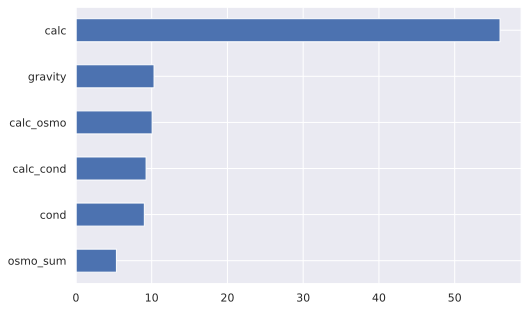

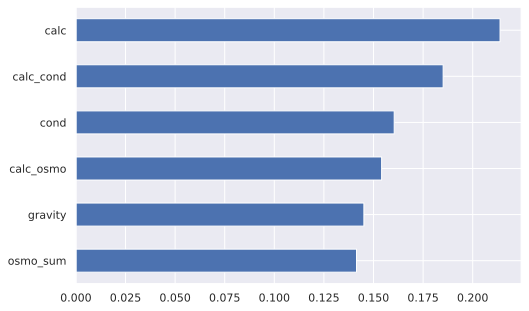

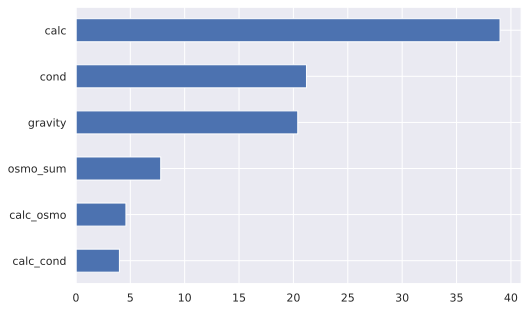

In [431]:
f_imp_by_model = [list(pd.DataFrame(features_imp_cbc).T.mean(axis=1)), \
                  list(pd.DataFrame(features_imp_xgb).T.mean(axis=1)), \
                  list(pd.DataFrame(features_imp_lgbm).T.mean(axis=1))]
for f_imp in f_imp_by_model:
    pd.DataFrame(data={'score': f_imp}, index=X.columns).sort_values(by='score').plot(kind='barh', grid=True, legend=False)

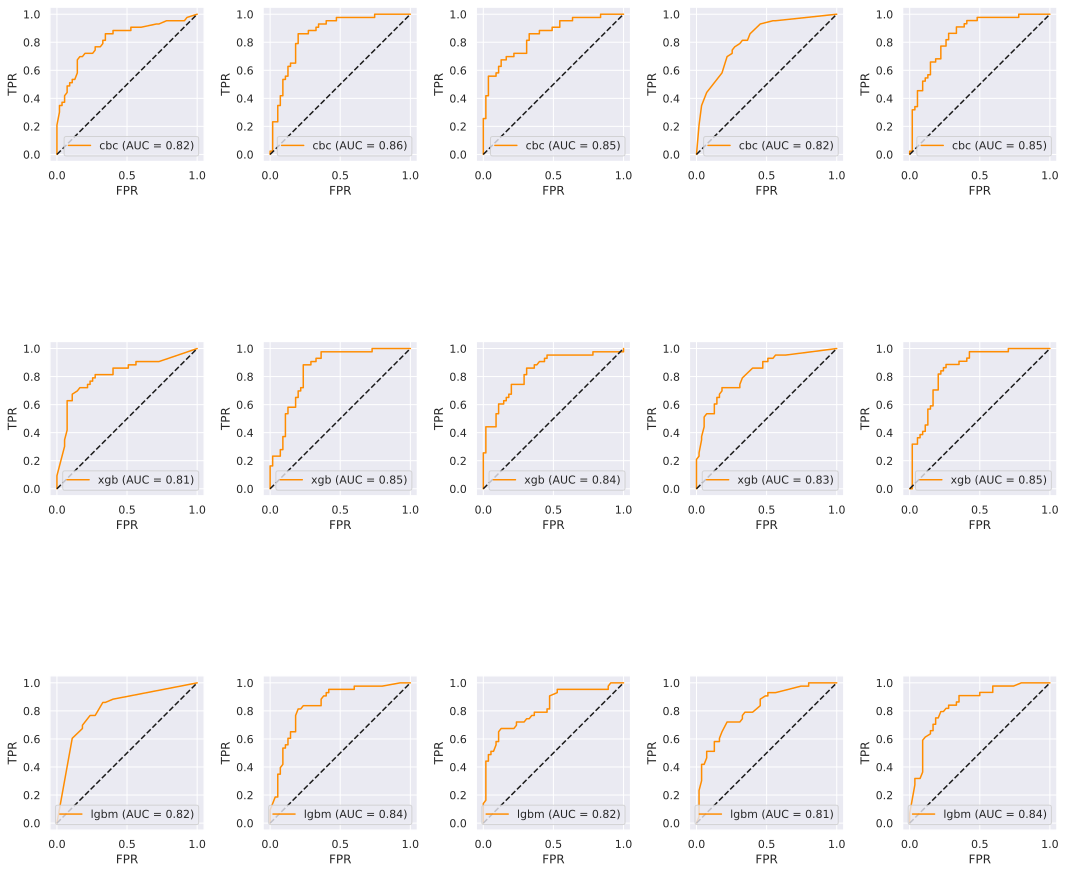

In [433]:
def draw_roc_curve(models_preds, ncols=5, nrows=3):
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 15))
    
    for i, preds in enumerate(models_preds):
        for j in range(5):
            ax = axes[i][j]
            RocCurveDisplay.from_predictions(
                preds[0][j][0], 
                preds[0][j][1], 
                color="darkorange",
                name=preds[1],
                ax=ax,
            )
            ax.axis('square')
            ax.plot([0, 1], [0, 1], "k--")
            ax.set_xlabel('FPR')
            ax.set_ylabel('TPR')
    fig.tight_layout()
    
draw_roc_curve([(valid_cbc, 'cbc'), (valid_xgb, 'xgb'), (valid_lgbm, 'lgbm')])

In [434]:
# Ensemble
predict = pd.DataFrame([preds_cbc[1], preds_xgb[4], preds_lgbm[4]]).T.mean(axis=1)

In [435]:
# Submission
ids = pd.read_csv("/content/playground/test.csv")['id']
submission = pd.DataFrame(data={'id': ids, 
                                'target': predict})
submission.to_csv('Ensemble.csv', index=False)